##Read dataset base

In [ ]:
!gdown 1XcS4t7iRXG9T7a_EGpwO2fo7NDTf9-DN

Downloading...
From: https://drive.google.com/uc?id=1XcS4t7iRXG9T7a_EGpwO2fo7NDTf9-DN
To: /content/dataset_base.parquet
100% 32.3M/32.3M [00:00<00:00, 85.4MB/s]


In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
df = pd.read_parquet("dataset_base.parquet")
df.tail(3)

,musicId,acoustic,lyrics,arousal,valence,bert
602,985,"[7.818191000000001, 0.4787813, 0.0, 3.404724, ...",I live my day as if it was the last Live...,positive,positive,"[-0.0325904675, 0.0452854037, -0.0056039067, 0..."
603,993,"[8.378411999999999, 0.6805897, 0.0, 2.728126, ...",Waiting for the time to pass you by Hope the w...,positive,positive,"[0.0326712728, -0.00807604566, -0.0398680158, ..."
604,996,"[7.961765, 0.9235694, 0.0, 3.891528, 5.317545,...",I'm facing the battle Through all of my probl...,positive,neutral,"[-0.0557158515, 0.0489445478, -0.0287081152, -..."


In [ ]:
#normalizando a característica acústica

from sklearn.preprocessing import Normalizer
X = df.acoustic.tolist()
transformer = Normalizer().fit(X)
df["acoustic"] = transformer.transform(X).tolist()
df.tail()

,musicId,acoustic,lyrics,arousal,valence,bert
600,983,"[1.2061092262776778e-13, 4.177800474173587e-15...","Oh my, oh my, oh my Oh my, oh my, oh my Oh my,...",positive,neutral,"[0.00838607457, 0.00765613094, -0.0174218081, ..."
601,984,"[1.8732153637644468e-13, 1.4603031973869196e-1...",I didn't know that I could want you so deep As...,positive,positive,"[-0.03509091, 0.0096077, -0.00696577, 0.014552..."
602,985,"[2.94366150961083e-13, 1.8026805489037494e-14,...",I live my day as if it was the last Live...,positive,positive,"[-0.0325904675, 0.0452854037, -0.0056039067, 0..."
603,993,"[2.195766014483701e-13, 1.7836503302387823e-14...",Waiting for the time to pass you by Hope the w...,positive,positive,"[0.0326712728, -0.00807604566, -0.0398680158, ..."
604,996,"[1.9430354437586726e-13, 2.25393248729513e-14,...",I'm facing the battle Through all of my probl...,positive,neutral,"[-0.0557158515, 0.0489445478, -0.0287081152, -..."


##Plot confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set_theme()

sns.set(font_scale=1)

def compute_confusion_matrix(y_true, y_pred):
  return confusion_matrix(y_true, y_pred)

def plot_matrix(y_true, y_pred):
  cm = compute_confusion_matrix(y_true, y_pred)
  classes=['negative', "neutral", "positive"]
  ax = sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=classes, yticklabels=classes, cbar=False)
  ax.set(title="matriz de confusão", xlabel="predicted label", ylabel="true label")

##Data split

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
indexes = tuple(*sss.split(df.musicId, df.valence))
train_index, test_index = indexes[0], indexes[1]

df_train = df[df.index.isin(train_index)]
df_test = df[df.index.isin(test_index)]

In [ ]:
df_train.tail(3)

,musicId,acoustic,lyrics,arousal,valence,bert
599,979,"[2.9014731812137823e-12, 7.473036834700408e-14...",And I was just a kid I was always trying To do...,negative,neutral,"[-0.06977995, -0.02948299, -0.03845626, 0.0182..."
602,985,"[2.94366150961083e-13, 1.8026805489037494e-14,...",I live my day as if it was the last Live...,positive,positive,"[-0.0325904675, 0.0452854037, -0.0056039067, 0..."
604,996,"[1.9430354437586726e-13, 2.25393248729513e-14,...",I'm facing the battle Through all of my probl...,positive,neutral,"[-0.0557158515, 0.0489445478, -0.0287081152, -..."


In [ ]:
df_test.tail(3)

,musicId,acoustic,lyrics,arousal,valence,bert
600,983,"[1.2061092262776778e-13, 4.177800474173587e-15...","Oh my, oh my, oh my Oh my, oh my, oh my Oh my,...",positive,neutral,"[0.00838607457, 0.00765613094, -0.0174218081, ..."
601,984,"[1.8732153637644468e-13, 1.4603031973869196e-1...",I didn't know that I could want you so deep As...,positive,positive,"[-0.03509091, 0.0096077, -0.00696577, 0.014552..."
603,993,"[2.195766014483701e-13, 1.7836503302387823e-14...",Waiting for the time to pass you by Hope the w...,positive,positive,"[0.0326712728, -0.00807604566, -0.0398680158, ..."


##Baseline method

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.neural_network import MLPClassifier

def compute_baseline(df_train, df_test, feature, label="valence"):
  X_train = df_train[feature].tolist()
  y_train = df_train[label].tolist()

  X_test = df_test[feature].tolist()
  y_true = df_test[label].tolist()

  clf = MLPClassifier(random_state=42, max_iter=50).fit(X_train, y_train)
  y_pred = clf.predict(X_test)

  accuracy = accuracy_score(y_true, y_pred)
  f1_macro = f1_score(y_true, y_pred, average='macro')
  print(f"Resultado usando {feature}")
  print(f'Accuracy: {accuracy:.4f}')
  print(f'F1 Macro: {f1_macro:.4f}')
  return y_true, y_pred

y_true, y_pred = compute_baseline(df_train, df_test, feature="acoustic", label="valence")

Resultado usando acoustic
Accuracy: 0.6033
F1 Macro: 0.2509


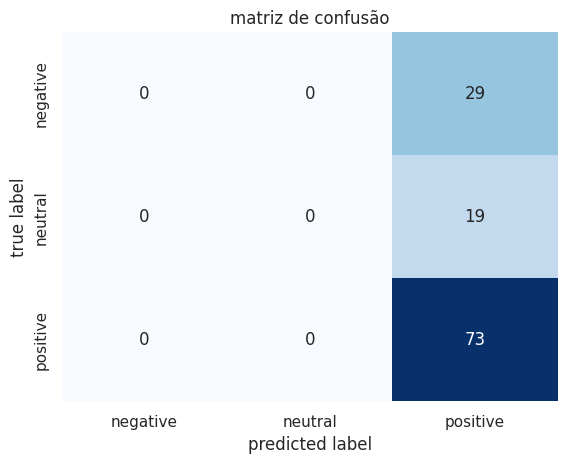

In [ ]:
plot_matrix(y_true, y_pred)

##Create features based on clustering or nearest neighborns to audio and textual modalities

In [ ]:
#RELACIONAMENTOS BASEADOS EM VIZINHOS MAIS PRÓXIMOS

from sklearn.neighbors import NearestNeighbors
import numpy as np

def get_Nearest_Neighbors(df_train, feature, n_neighbors=2):
  X = np.array(df_train[feature].tolist())
  nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
  distances, indices = nbrs.kneighbors(X)
  df_train["neighbors"] = indices.tolist()
  return df_train

df_train = get_Nearest_Neighbors(df_train, feature="bert", n_neighbors=3)
df_train.tail(3)

,musicId,acoustic,lyrics,arousal,valence,bert,neighbors
599,979,"[2.9014731812137823e-12, 7.473036834700408e-14...",And I was just a kid I was always trying To do...,negative,neutral,"[-0.06977995, -0.02948299, -0.03845626, 0.0182...","[481, 153, 362]"
602,985,"[2.94366150961083e-13, 1.8026805489037494e-14,...",I live my day as if it was the last Live...,positive,positive,"[-0.0325904675, 0.0452854037, -0.0056039067, 0...","[482, 298, 45]"
604,996,"[1.9430354437586726e-13, 2.25393248729513e-14,...",I'm facing the battle Through all of my probl...,positive,neutral,"[-0.0557158515, 0.0489445478, -0.0287081152, -...","[483, 92, 412]"


In [ ]:
#RELACIONAMENTOS BASEADOS EM AGRUPAMENTO

from sklearn.cluster import KMeans

def get_kmeans_cluster(df_train, feature, k=3):
  kmeans = KMeans(n_clusters=k, random_state=42, init='random').fit(df_train[feature].to_list())
  df_train[f'{feature}_cluster'] = kmeans.labels_
  return df_train

df_train = get_kmeans_cluster(df_train, feature="bert", k=3)
df_train = get_kmeans_cluster(df_train, feature="acoustic", k=3)
df_train.tail(3)

,musicId,acoustic,lyrics,arousal,valence,bert,neighbors,bert_cluster,acoustic_cluster
599,979,"[2.9014731812137823e-12, 7.473036834700408e-14...",And I was just a kid I was always trying To do...,negative,neutral,"[-0.06977995, -0.02948299, -0.03845626, 0.0182...","[481, 153, 362]",0,1
602,985,"[2.94366150961083e-13, 1.8026805489037494e-14,...",I live my day as if it was the last Live...,positive,positive,"[-0.0325904675, 0.0452854037, -0.0056039067, 0...","[482, 298, 45]",0,2
604,996,"[1.9430354437586726e-13, 2.25393248729513e-14,...",I'm facing the battle Through all of my probl...,positive,neutral,"[-0.0557158515, 0.0489445478, -0.0287081152, -...","[483, 92, 412]",0,2


##Create heterogeneous graph with music features

####Create graph with train data

In [ ]:
import networkx as nx

def create_graph(G, df, label):
  #CRIANDO NÓS E ATRIBUINDO AS CARACTERÍSTICAS
  for index,row in df.iterrows():
    node_music = str(row['musicId'])+':music'
    node_audio = str(row['musicId'])+':audio'
    node_lyrics = str(row['musicId'])+':text'

    G.add_edge(node_music, node_audio)
    G.add_edge(node_music, node_lyrics)

    G.nodes[node_music]["label"] = row[label]
    G.nodes[node_music]['acoustic'] = row['acoustic']
    G.nodes[node_music]['bert'] = row['bert']

    G.nodes[node_audio]['acoustic'] = row['acoustic']
    G.nodes[node_audio]["label"] = row[label]

    G.nodes[node_lyrics]['bert'] = row['bert']
    G.nodes[node_lyrics]["label"] = row[label]

  #CRIANDO RELACIONAMENTOS ENTRE NÓS AUDIO
  unique_acoustic_clusters = df['acoustic_cluster'].unique()

  for cluster in unique_acoustic_clusters:
    df_tmp = df[df.acoustic_cluster==cluster]

    indexes = list(df_tmp.musicId)

    for i, from_acoustic in enumerate(indexes):
      for to_acoustic in indexes[i:]:
        G.add_edge(f"{from_acoustic}:audio", f"{to_acoustic}:audio")

  #CRIANDO RELACIONAMENTOS ENTRE NÓS LETRA
  for _, row in df.iterrows():
    for neighbor in row["neighbors"]:
      from_bert = row['musicId']
      to_bert = df.iloc[neighbor].musicId
      G.add_edge(f"{from_bert}:text", f"{to_bert}:text")

  return G

G_train = nx.Graph()
G_train = create_graph(G=G_train, df=df_train, label="valence")

In [ ]:
# print a quantidade de componentes que o grafo possui
# o ideal é termos apenas 1, indicando que o grafo é conexo
len(list(nx.connected_components(G_train)))

1

####Create graph with test data

In [ ]:
import networkx as nx
import numpy as np

labels = {'negative':0, 'neutral':1, 'positive':2}
def create_graph_test(G, df, label):
  for index,row in df.iterrows():
    node_music = str(row['musicId'])+':music'
    G.add_node(node_music)
    G.nodes[node_music]["label"] = np.array([labels[row[label]]])
    G.nodes[node_music]['embedding_final'] = np.append( row['bert'], row['acoustic'])

  return G

G_test = nx.Graph()
G_test = create_graph_test(G=G_test, df=df_test, label="valence")

##Graph regularization

In [ ]:
import networkx as nx
import numpy as np
import random

from tqdm.notebook import tqdm

# parâmetros:
# G: grafo: networkx
# dim: dimensão da embeddings/feature: int
# embedding_feature: nome da feature: str
# iterations: quantidade de iterações: int
def regularization(G, dim, embedding_feature: str = 'embedding', iterations=3, u=1.0):

  nodes = []

  # inicializando vetor f para todos os nodes
  for node in G.nodes():
      G.nodes[node]['f'] = np.array([0.0]*dim)
      if embedding_feature in G.nodes[node]:
        G.nodes[node]['f'] = np.array(G.nodes[node][embedding_feature]) * u
      nodes.append(node)

  pbar = tqdm(range(0, iterations))

  for iteration in pbar:
      random.shuffle(nodes)

      # percorrendo cada node
      for node in nodes:
          f_new = np.array([0.0]*dim)
          f_old = np.array(G.nodes[node]['f']) * u
          sum_w = 0.0

          # percorrendo vizinhos do node
          w = 1
          for neighbor in G.neighbors(node):

              f_new += G.nodes[neighbor]['f']

              sum_w += w

          f_new /= sum_w

          G.nodes[node]['f'] = f_new * u

          if embedding_feature in G.nodes[node]:
              G.nodes[node]['f'] = np.array(G.nodes[node][embedding_feature])

          G.nodes[node]['f_'+embedding_feature] = G.nodes[node]['f']

      iteration += 1
      message = 'Iteration '+str(iteration)
      pbar.set_description(message)

  return G

In [ ]:
# a regularização deve ser feito para cada tipo de feature
regularization(G_train, 6373, 'acoustic', iterations=30)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
regularization(G_train, 512, 'bert', iterations=30)

  0%|          | 0/30 [00:00<?, ?it/s]

In [ ]:
# após a regularização de todas as features, nós vamos concatenar todas elas em um vetor único
for node in G_train.nodes:
  G_train.nodes[node]["embedding_final"] = G_train.nodes[node]["f_bert"].tolist() + G_train.nodes[node]["f_acoustic"].tolist()

##Save and read graph

In [ ]:
# salvar grafo
import pickle
with open('grafo_train.gpickle', 'wb') as f:
    pickle.dump(G_train, f, pickle.HIGHEST_PROTOCOL)

with open('grafo_test.gpickle', 'wb') as f:
    pickle.dump(G_test, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# ler grafo
import pickle
with open(f'grafo_train.gpickle', 'rb') as f:
    G_train = pickle.load(f)

with open(f'grafo_test.gpickle', 'rb') as f:
    G_test = pickle.load(f)

##Model building and trainning

In [ ]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 6.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, Linear
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
import networkx as nx
import numpy as np

# Converter o grafo Networkx para o formato PyTorch Geometric  #já tem um método que faz isso
node_to_index = {node: idx for idx, node in enumerate(G_train.nodes())}
edge_index = torch.tensor([[node_to_index[edge[0]], node_to_index[edge[1]]] for edge in G_train.edges()]).t().contiguous()

labels = {'negative':0, 'neutral':1, 'positive':2}

features = np.array([G_train.nodes[node]["embedding_final"] for node in G_train.nodes])
label = np.array([labels[G_train.nodes[node]["label"]] for node in G_train.nodes])

# convertendo os vetores de características para tensores
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(label, dtype=torch.long)

# convertendo os dados em um formato esperado pelo Pytorch
data = Data(x=x, edge_index=edge_index, y=y)
batch_size = 4  # limite para o tamanho do batch de dados durante o treino
data_list = [data] * batch_size
data_loader = DataLoader(data_list, batch_size=batch_size, shuffle=True)

In [ ]:
# Defina a arquitetura da GCN
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels[0])
        self.conv2 = GCNConv(hidden_channels[0], hidden_channels[1])
        self.conv3 = GCNConv(hidden_channels[1], hidden_channels[2])
        self.out = Linear(hidden_channels[2], out_channels)
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(0.7)

    def forward(self, x, edge_index):
        x = self.activation(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.activation(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = self.activation(self.conv3(x, edge_index))
        x = self.dropout(x)
        x = self.out(x)
        return x


In [ ]:
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight

# Instanciando o modelo
model = GCN(in_channels=6885, hidden_channels=[2048, 1024, 256], out_channels=3)
model.to("cuda")

# Balanceando as classes
class_weights = compute_class_weight("balanced", classes=np.unique(y), y=label)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Definindo a função de perda e otimizador
criterion = nn.CrossEntropyLoss(weight=class_weights)
weight_decay = 1e-3  # utilizei um decaimento na lr
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=weight_decay)

# Definindo um critério de parada antecipada para interromper o treinamento caso o modelo não esteja aprendendo mais
early_stop_criteria = 100  # Paciência
best_loss = float('inf')
patience = 0

# Treinando o modelo com early stopping
num_epochs = 1500

for epoch in tqdm(range(num_epochs), total=num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch in data_loader:
        optimizer.zero_grad()
        out = model(batch.x.to('cuda'), batch.edge_index.to('cuda'))
        loss = criterion(out.to('cpu'), batch.y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calcular acurácia no conjunto de treinamento
        _, predicted_labels = out.max(dim=1)
        #print(predicted_labels)
        correct_predictions += predicted_labels.eq(batch.y.to('cuda')).sum().item()
        total_samples += batch.y.to('cpu').size(0)

    # Calcular a loss média no conjunto de treinamento
    average_loss = total_loss / len(data_loader)
    accuracy = correct_predictions / total_samples #accuracy não é usada no treinamento

    # Verificar se a perda atual é a melhor até agora
    if average_loss < best_loss:
        best_loss = average_loss
        patience = 0
    else:
        patience += 1

    # Imprimir a loss média a cada epoch
    print(f'Época [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f} Accuracy {accuracy:.3f}')

    # Verificar o critério de parada antecipada
    if patience == early_stop_criteria:
        print(f"Early stopping! O modelo não está melhorando nas últimas {early_stop_criteria} épocas")
        break


  0%|          | 1/1500 [00:01<47:15,  1.89s/it]

Época [1/1500], Loss: 1.0999 Accuracy 0.482


  0%|          | 2/1500 [00:02<30:24,  1.22s/it]

Época [2/1500], Loss: 1.0994 Accuracy 0.481


  0%|          | 3/1500 [00:03<24:55,  1.00it/s]

Época [3/1500], Loss: 1.0987 Accuracy 0.481


  0%|          | 4/1500 [00:03<20:34,  1.21it/s]

Época [4/1500], Loss: 1.0988 Accuracy 0.462


  0%|          | 5/1500 [00:04<19:37,  1.27it/s]

Época [5/1500], Loss: 1.0994 Accuracy 0.461


  0%|          | 6/1500 [00:05<17:36,  1.41it/s]

Época [6/1500], Loss: 1.0979 Accuracy 0.458


  0%|          | 7/1500 [00:05<14:57,  1.66it/s]

Época [7/1500], Loss: 1.0986 Accuracy 0.447


  1%|          | 8/1500 [00:05<13:14,  1.88it/s]

Época [8/1500], Loss: 1.0979 Accuracy 0.452


  1%|          | 9/1500 [00:06<12:05,  2.06it/s]

Época [9/1500], Loss: 1.0963 Accuracy 0.441


  1%|          | 10/1500 [00:06<11:21,  2.19it/s]

Época [10/1500], Loss: 1.0989 Accuracy 0.421


  1%|          | 11/1500 [00:07<10:45,  2.31it/s]

Época [11/1500], Loss: 1.0974 Accuracy 0.417


  1%|          | 12/1500 [00:07<10:20,  2.40it/s]

Época [12/1500], Loss: 1.0979 Accuracy 0.417


  1%|          | 13/1500 [00:07<10:06,  2.45it/s]

Época [13/1500], Loss: 1.0978 Accuracy 0.407


  1%|          | 14/1500 [00:08<09:56,  2.49it/s]

Época [14/1500], Loss: 1.0974 Accuracy 0.411


  1%|          | 15/1500 [00:08<09:49,  2.52it/s]

Época [15/1500], Loss: 1.0965 Accuracy 0.417


  1%|          | 16/1500 [00:09<09:43,  2.54it/s]

Época [16/1500], Loss: 1.0979 Accuracy 0.394


  1%|          | 17/1500 [00:09<09:39,  2.56it/s]

Época [17/1500], Loss: 1.0980 Accuracy 0.383


  1%|          | 18/1500 [00:09<09:37,  2.57it/s]

Época [18/1500], Loss: 1.0959 Accuracy 0.407


  1%|▏         | 19/1500 [00:10<09:34,  2.58it/s]

Época [19/1500], Loss: 1.0965 Accuracy 0.389


  1%|▏         | 20/1500 [00:10<09:32,  2.59it/s]

Época [20/1500], Loss: 1.0953 Accuracy 0.396


  1%|▏         | 21/1500 [00:10<09:26,  2.61it/s]

Época [21/1500], Loss: 1.0949 Accuracy 0.392


  1%|▏         | 22/1500 [00:11<09:26,  2.61it/s]

Época [22/1500], Loss: 1.0957 Accuracy 0.402


  2%|▏         | 23/1500 [00:11<09:26,  2.61it/s]

Época [23/1500], Loss: 1.0955 Accuracy 0.389


  2%|▏         | 24/1500 [00:12<09:27,  2.60it/s]

Época [24/1500], Loss: 1.0955 Accuracy 0.387


  2%|▏         | 25/1500 [00:12<09:26,  2.60it/s]

Época [25/1500], Loss: 1.0951 Accuracy 0.384


  2%|▏         | 26/1500 [00:12<09:27,  2.60it/s]

Época [26/1500], Loss: 1.0953 Accuracy 0.394


  2%|▏         | 27/1500 [00:13<09:26,  2.60it/s]

Época [27/1500], Loss: 1.0948 Accuracy 0.392


  2%|▏         | 28/1500 [00:13<09:28,  2.59it/s]

Época [28/1500], Loss: 1.0937 Accuracy 0.391


  2%|▏         | 29/1500 [00:14<10:45,  2.28it/s]

Época [29/1500], Loss: 1.0943 Accuracy 0.389


  2%|▏         | 30/1500 [00:14<10:57,  2.24it/s]

Época [30/1500], Loss: 1.0954 Accuracy 0.391


  2%|▏         | 31/1500 [00:15<11:11,  2.19it/s]

Época [31/1500], Loss: 1.0939 Accuracy 0.394


  2%|▏         | 32/1500 [00:16<14:28,  1.69it/s]

Época [32/1500], Loss: 1.0938 Accuracy 0.404


  2%|▏         | 33/1500 [00:16<13:07,  1.86it/s]

Época [33/1500], Loss: 1.0948 Accuracy 0.390


  2%|▏         | 34/1500 [00:17<16:46,  1.46it/s]

Época [34/1500], Loss: 1.0929 Accuracy 0.408


  2%|▏         | 35/1500 [00:17<14:43,  1.66it/s]

Época [35/1500], Loss: 1.0921 Accuracy 0.406


  2%|▏         | 36/1500 [00:18<13:16,  1.84it/s]

Época [36/1500], Loss: 1.0931 Accuracy 0.402


  2%|▏         | 37/1500 [00:18<12:22,  1.97it/s]

Época [37/1500], Loss: 1.0925 Accuracy 0.418


  3%|▎         | 38/1500 [00:19<11:46,  2.07it/s]

Época [38/1500], Loss: 1.0930 Accuracy 0.412


  3%|▎         | 39/1500 [00:19<11:15,  2.16it/s]

Época [39/1500], Loss: 1.0930 Accuracy 0.412


  3%|▎         | 40/1500 [00:19<10:42,  2.27it/s]

Época [40/1500], Loss: 1.0920 Accuracy 0.419


  3%|▎         | 41/1500 [00:20<10:17,  2.36it/s]

Época [41/1500], Loss: 1.0921 Accuracy 0.411


  3%|▎         | 42/1500 [00:20<10:01,  2.43it/s]

Época [42/1500], Loss: 1.0921 Accuracy 0.425


  3%|▎         | 43/1500 [00:21<09:50,  2.47it/s]

Época [43/1500], Loss: 1.0928 Accuracy 0.409


  3%|▎         | 44/1500 [00:21<09:44,  2.49it/s]

Época [44/1500], Loss: 1.0922 Accuracy 0.415


  3%|▎         | 45/1500 [00:21<09:35,  2.53it/s]

Época [45/1500], Loss: 1.0910 Accuracy 0.442


  3%|▎         | 46/1500 [00:22<09:30,  2.55it/s]

Época [46/1500], Loss: 1.0916 Accuracy 0.419


  3%|▎         | 47/1500 [00:22<09:26,  2.56it/s]

Época [47/1500], Loss: 1.0926 Accuracy 0.417


  3%|▎         | 48/1500 [00:23<09:24,  2.57it/s]

Época [48/1500], Loss: 1.0908 Accuracy 0.427


  3%|▎         | 49/1500 [00:23<09:23,  2.58it/s]

Época [49/1500], Loss: 1.0907 Accuracy 0.431


  3%|▎         | 50/1500 [00:23<09:22,  2.58it/s]

Época [50/1500], Loss: 1.0903 Accuracy 0.443


  3%|▎         | 51/1500 [00:24<09:22,  2.58it/s]

Época [51/1500], Loss: 1.0897 Accuracy 0.447


  3%|▎         | 52/1500 [00:24<09:24,  2.57it/s]

Época [52/1500], Loss: 1.0901 Accuracy 0.440


  4%|▎         | 53/1500 [00:25<09:21,  2.58it/s]

Época [53/1500], Loss: 1.0897 Accuracy 0.436


  4%|▎         | 54/1500 [00:25<09:22,  2.57it/s]

Época [54/1500], Loss: 1.0895 Accuracy 0.455


  4%|▎         | 55/1500 [00:25<09:22,  2.57it/s]

Época [55/1500], Loss: 1.0903 Accuracy 0.440


  4%|▎         | 56/1500 [00:26<09:34,  2.52it/s]

Época [56/1500], Loss: 1.0896 Accuracy 0.438


  4%|▍         | 57/1500 [00:26<09:25,  2.55it/s]

Época [57/1500], Loss: 1.0886 Accuracy 0.461


  4%|▍         | 58/1500 [00:26<09:20,  2.57it/s]

Época [58/1500], Loss: 1.0896 Accuracy 0.439


  4%|▍         | 59/1500 [00:27<09:18,  2.58it/s]

Época [59/1500], Loss: 1.0902 Accuracy 0.440


  4%|▍         | 60/1500 [00:27<09:16,  2.59it/s]

Época [60/1500], Loss: 1.0894 Accuracy 0.454


  4%|▍         | 61/1500 [00:28<09:15,  2.59it/s]

Época [61/1500], Loss: 1.0891 Accuracy 0.456


  4%|▍         | 62/1500 [00:28<09:14,  2.59it/s]

Época [62/1500], Loss: 1.0877 Accuracy 0.465


  4%|▍         | 63/1500 [00:28<09:13,  2.59it/s]

Época [63/1500], Loss: 1.0880 Accuracy 0.455


  4%|▍         | 64/1500 [00:29<09:14,  2.59it/s]

Época [64/1500], Loss: 1.0884 Accuracy 0.460


  4%|▍         | 65/1500 [00:29<09:14,  2.59it/s]

Época [65/1500], Loss: 1.0871 Accuracy 0.472


  4%|▍         | 66/1500 [00:30<09:22,  2.55it/s]

Época [66/1500], Loss: 1.0876 Accuracy 0.471


  4%|▍         | 67/1500 [00:30<09:29,  2.52it/s]

Época [67/1500], Loss: 1.0875 Accuracy 0.466


  5%|▍         | 68/1500 [00:30<09:29,  2.51it/s]

Época [68/1500], Loss: 1.0885 Accuracy 0.468


  5%|▍         | 69/1500 [00:31<09:32,  2.50it/s]

Época [69/1500], Loss: 1.0874 Accuracy 0.472


  5%|▍         | 70/1500 [00:31<09:35,  2.49it/s]

Época [70/1500], Loss: 1.0867 Accuracy 0.469


  5%|▍         | 71/1500 [00:32<09:41,  2.46it/s]

Época [71/1500], Loss: 1.0864 Accuracy 0.474


  5%|▍         | 72/1500 [00:32<09:47,  2.43it/s]

Época [72/1500], Loss: 1.0872 Accuracy 0.465


  5%|▍         | 73/1500 [00:32<09:47,  2.43it/s]

Época [73/1500], Loss: 1.0850 Accuracy 0.481


  5%|▍         | 74/1500 [00:33<09:52,  2.41it/s]

Época [74/1500], Loss: 1.0849 Accuracy 0.480


  5%|▌         | 75/1500 [00:33<09:46,  2.43it/s]

Época [75/1500], Loss: 1.0859 Accuracy 0.475


  5%|▌         | 76/1500 [00:34<09:34,  2.48it/s]

Época [76/1500], Loss: 1.0850 Accuracy 0.479


  5%|▌         | 77/1500 [00:34<09:27,  2.51it/s]

Época [77/1500], Loss: 1.0864 Accuracy 0.473


  5%|▌         | 78/1500 [00:34<09:20,  2.54it/s]

Época [78/1500], Loss: 1.0861 Accuracy 0.475


  5%|▌         | 79/1500 [00:35<09:18,  2.54it/s]

Época [79/1500], Loss: 1.0851 Accuracy 0.486


  5%|▌         | 80/1500 [00:35<09:13,  2.56it/s]

Época [80/1500], Loss: 1.0858 Accuracy 0.478


  5%|▌         | 81/1500 [00:36<09:11,  2.57it/s]

Época [81/1500], Loss: 1.0856 Accuracy 0.473


  5%|▌         | 82/1500 [00:36<09:09,  2.58it/s]

Época [82/1500], Loss: 1.0848 Accuracy 0.490


  6%|▌         | 83/1500 [00:36<09:07,  2.59it/s]

Época [83/1500], Loss: 1.0850 Accuracy 0.480


  6%|▌         | 84/1500 [00:37<09:05,  2.59it/s]

Época [84/1500], Loss: 1.0830 Accuracy 0.492


  6%|▌         | 85/1500 [00:37<09:05,  2.59it/s]

Época [85/1500], Loss: 1.0850 Accuracy 0.485


  6%|▌         | 86/1500 [00:38<09:04,  2.60it/s]

Época [86/1500], Loss: 1.0843 Accuracy 0.480


  6%|▌         | 87/1500 [00:38<09:04,  2.60it/s]

Época [87/1500], Loss: 1.0838 Accuracy 0.497


  6%|▌         | 88/1500 [00:38<09:04,  2.59it/s]

Época [88/1500], Loss: 1.0835 Accuracy 0.494


  6%|▌         | 89/1500 [00:39<09:03,  2.60it/s]

Época [89/1500], Loss: 1.0848 Accuracy 0.480


  6%|▌         | 90/1500 [00:39<09:02,  2.60it/s]

Época [90/1500], Loss: 1.0838 Accuracy 0.480


  6%|▌         | 91/1500 [00:39<09:01,  2.60it/s]

Época [91/1500], Loss: 1.0829 Accuracy 0.486


  6%|▌         | 92/1500 [00:40<09:01,  2.60it/s]

Época [92/1500], Loss: 1.0838 Accuracy 0.482


  6%|▌         | 93/1500 [00:40<09:02,  2.59it/s]

Época [93/1500], Loss: 1.0821 Accuracy 0.498


  6%|▋         | 94/1500 [00:41<09:02,  2.59it/s]

Época [94/1500], Loss: 1.0827 Accuracy 0.490


  6%|▋         | 95/1500 [00:41<09:01,  2.59it/s]

Época [95/1500], Loss: 1.0823 Accuracy 0.496


  6%|▋         | 96/1500 [00:41<09:01,  2.59it/s]

Época [96/1500], Loss: 1.0833 Accuracy 0.491


  6%|▋         | 97/1500 [00:42<09:04,  2.58it/s]

Época [97/1500], Loss: 1.0813 Accuracy 0.503


  7%|▋         | 98/1500 [00:42<09:03,  2.58it/s]

Época [98/1500], Loss: 1.0816 Accuracy 0.496


  7%|▋         | 99/1500 [00:43<09:06,  2.56it/s]

Época [99/1500], Loss: 1.0813 Accuracy 0.498


  7%|▋         | 100/1500 [00:43<09:04,  2.57it/s]

Época [100/1500], Loss: 1.0807 Accuracy 0.501


  7%|▋         | 101/1500 [00:43<09:13,  2.53it/s]

Época [101/1500], Loss: 1.0818 Accuracy 0.493


  7%|▋         | 102/1500 [00:44<09:21,  2.49it/s]

Época [102/1500], Loss: 1.0810 Accuracy 0.496


  7%|▋         | 103/1500 [00:44<09:24,  2.47it/s]

Época [103/1500], Loss: 1.0810 Accuracy 0.499


  7%|▋         | 104/1500 [00:45<09:23,  2.48it/s]

Época [104/1500], Loss: 1.0806 Accuracy 0.498


  7%|▋         | 105/1500 [00:45<09:24,  2.47it/s]

Época [105/1500], Loss: 1.0801 Accuracy 0.504


  7%|▋         | 106/1500 [00:45<09:27,  2.46it/s]

Época [106/1500], Loss: 1.0800 Accuracy 0.505


  7%|▋         | 107/1500 [00:46<09:30,  2.44it/s]

Época [107/1500], Loss: 1.0800 Accuracy 0.497


  7%|▋         | 108/1500 [00:46<09:31,  2.43it/s]

Época [108/1500], Loss: 1.0800 Accuracy 0.500


  7%|▋         | 109/1500 [00:47<09:29,  2.44it/s]

Época [109/1500], Loss: 1.0796 Accuracy 0.500


  7%|▋         | 110/1500 [00:47<09:29,  2.44it/s]

Época [110/1500], Loss: 1.0791 Accuracy 0.500


  7%|▋         | 111/1500 [00:47<09:28,  2.44it/s]

Época [111/1500], Loss: 1.0797 Accuracy 0.501


  7%|▋         | 112/1500 [00:48<09:18,  2.48it/s]

Época [112/1500], Loss: 1.0786 Accuracy 0.503


  8%|▊         | 113/1500 [00:48<09:10,  2.52it/s]

Época [113/1500], Loss: 1.0776 Accuracy 0.515


  8%|▊         | 114/1500 [00:49<09:05,  2.54it/s]

Época [114/1500], Loss: 1.0789 Accuracy 0.505


  8%|▊         | 115/1500 [00:49<09:04,  2.54it/s]

Época [115/1500], Loss: 1.0772 Accuracy 0.518


  8%|▊         | 116/1500 [00:49<09:01,  2.55it/s]

Época [116/1500], Loss: 1.0782 Accuracy 0.507


  8%|▊         | 117/1500 [00:50<08:58,  2.57it/s]

Época [117/1500], Loss: 1.0779 Accuracy 0.514


  8%|▊         | 118/1500 [00:50<08:57,  2.57it/s]

Época [118/1500], Loss: 1.0775 Accuracy 0.514


  8%|▊         | 119/1500 [00:51<08:57,  2.57it/s]

Época [119/1500], Loss: 1.0771 Accuracy 0.520


  8%|▊         | 120/1500 [00:51<08:56,  2.57it/s]

Época [120/1500], Loss: 1.0768 Accuracy 0.516


  8%|▊         | 121/1500 [00:51<08:54,  2.58it/s]

Época [121/1500], Loss: 1.0777 Accuracy 0.517


  8%|▊         | 122/1500 [00:52<08:52,  2.59it/s]

Época [122/1500], Loss: 1.0759 Accuracy 0.519


  8%|▊         | 123/1500 [00:52<08:52,  2.59it/s]

Época [123/1500], Loss: 1.0761 Accuracy 0.518


  8%|▊         | 124/1500 [00:52<08:52,  2.58it/s]

Época [124/1500], Loss: 1.0768 Accuracy 0.509


  8%|▊         | 125/1500 [00:53<08:52,  2.58it/s]

Época [125/1500], Loss: 1.0763 Accuracy 0.516


  8%|▊         | 126/1500 [00:53<08:51,  2.58it/s]

Época [126/1500], Loss: 1.0753 Accuracy 0.527


  8%|▊         | 127/1500 [00:54<08:51,  2.58it/s]

Época [127/1500], Loss: 1.0763 Accuracy 0.528


  9%|▊         | 128/1500 [00:54<08:47,  2.60it/s]

Época [128/1500], Loss: 1.0746 Accuracy 0.517


  9%|▊         | 129/1500 [00:54<08:51,  2.58it/s]

Época [129/1500], Loss: 1.0755 Accuracy 0.519


  9%|▊         | 130/1500 [00:55<08:50,  2.58it/s]

Época [130/1500], Loss: 1.0755 Accuracy 0.514


  9%|▊         | 131/1500 [00:55<08:51,  2.57it/s]

Época [131/1500], Loss: 1.0759 Accuracy 0.508


  9%|▉         | 132/1500 [00:56<08:50,  2.58it/s]

Época [132/1500], Loss: 1.0736 Accuracy 0.533


  9%|▉         | 133/1500 [00:56<08:48,  2.59it/s]

Época [133/1500], Loss: 1.0746 Accuracy 0.521


  9%|▉         | 134/1500 [00:56<08:55,  2.55it/s]

Época [134/1500], Loss: 1.0736 Accuracy 0.524


  9%|▉         | 135/1500 [00:57<08:52,  2.56it/s]

Época [135/1500], Loss: 1.0734 Accuracy 0.522


  9%|▉         | 136/1500 [00:57<08:51,  2.57it/s]

Época [136/1500], Loss: 1.0741 Accuracy 0.517


  9%|▉         | 137/1500 [00:58<09:03,  2.51it/s]

Época [137/1500], Loss: 1.0727 Accuracy 0.519


  9%|▉         | 138/1500 [00:58<09:07,  2.49it/s]

Época [138/1500], Loss: 1.0739 Accuracy 0.526


  9%|▉         | 139/1500 [00:58<09:07,  2.49it/s]

Época [139/1500], Loss: 1.0733 Accuracy 0.528


  9%|▉         | 140/1500 [00:59<09:09,  2.48it/s]

Época [140/1500], Loss: 1.0727 Accuracy 0.525


  9%|▉         | 141/1500 [00:59<09:12,  2.46it/s]

Época [141/1500], Loss: 1.0735 Accuracy 0.522


  9%|▉         | 142/1500 [01:00<09:15,  2.44it/s]

Época [142/1500], Loss: 1.0724 Accuracy 0.527


 10%|▉         | 143/1500 [01:00<09:14,  2.45it/s]

Época [143/1500], Loss: 1.0719 Accuracy 0.531


 10%|▉         | 144/1500 [01:00<09:13,  2.45it/s]

Época [144/1500], Loss: 1.0719 Accuracy 0.518


 10%|▉         | 145/1500 [01:01<09:12,  2.45it/s]

Época [145/1500], Loss: 1.0718 Accuracy 0.534


 10%|▉         | 146/1500 [01:01<09:13,  2.45it/s]

Época [146/1500], Loss: 1.0710 Accuracy 0.535


 10%|▉         | 147/1500 [01:02<09:30,  2.37it/s]

Época [147/1500], Loss: 1.0711 Accuracy 0.537


 10%|▉         | 148/1500 [01:02<10:56,  2.06it/s]

Época [148/1500], Loss: 1.0699 Accuracy 0.540


 10%|▉         | 149/1500 [01:03<10:14,  2.20it/s]

Época [149/1500], Loss: 1.0697 Accuracy 0.538


 10%|█         | 150/1500 [01:03<09:45,  2.30it/s]

Época [150/1500], Loss: 1.0697 Accuracy 0.528


 10%|█         | 151/1500 [01:03<09:26,  2.38it/s]

Época [151/1500], Loss: 1.0698 Accuracy 0.531


 10%|█         | 152/1500 [01:04<09:16,  2.42it/s]

Época [152/1500], Loss: 1.0714 Accuracy 0.521


 10%|█         | 153/1500 [01:04<09:06,  2.47it/s]

Época [153/1500], Loss: 1.0705 Accuracy 0.543


 10%|█         | 154/1500 [01:05<08:58,  2.50it/s]

Época [154/1500], Loss: 1.0690 Accuracy 0.533


 10%|█         | 155/1500 [01:05<08:52,  2.53it/s]

Época [155/1500], Loss: 1.0694 Accuracy 0.541


 10%|█         | 156/1500 [01:05<08:51,  2.53it/s]

Época [156/1500], Loss: 1.0680 Accuracy 0.534


 10%|█         | 157/1500 [01:06<08:52,  2.52it/s]

Época [157/1500], Loss: 1.0680 Accuracy 0.535


 11%|█         | 158/1500 [01:06<08:52,  2.52it/s]

Época [158/1500], Loss: 1.0683 Accuracy 0.533


 11%|█         | 159/1500 [01:07<08:48,  2.54it/s]

Época [159/1500], Loss: 1.0686 Accuracy 0.527


 11%|█         | 160/1500 [01:07<08:44,  2.55it/s]

Época [160/1500], Loss: 1.0672 Accuracy 0.548


 11%|█         | 161/1500 [01:07<08:41,  2.57it/s]

Época [161/1500], Loss: 1.0685 Accuracy 0.538


 11%|█         | 162/1500 [01:08<08:39,  2.57it/s]

Época [162/1500], Loss: 1.0674 Accuracy 0.535


 11%|█         | 163/1500 [01:08<08:38,  2.58it/s]

Época [163/1500], Loss: 1.0668 Accuracy 0.523


 11%|█         | 164/1500 [01:09<08:41,  2.56it/s]

Época [164/1500], Loss: 1.0670 Accuracy 0.544


 11%|█         | 165/1500 [01:09<08:41,  2.56it/s]

Época [165/1500], Loss: 1.0671 Accuracy 0.534


 11%|█         | 166/1500 [01:09<08:41,  2.56it/s]

Época [166/1500], Loss: 1.0660 Accuracy 0.544


 11%|█         | 167/1500 [01:10<08:39,  2.56it/s]

Época [167/1500], Loss: 1.0651 Accuracy 0.538


 11%|█         | 168/1500 [01:10<08:38,  2.57it/s]

Época [168/1500], Loss: 1.0656 Accuracy 0.535


 11%|█▏        | 169/1500 [01:11<08:38,  2.57it/s]

Época [169/1500], Loss: 1.0650 Accuracy 0.539


 11%|█▏        | 170/1500 [01:11<08:41,  2.55it/s]

Época [170/1500], Loss: 1.0654 Accuracy 0.539


 11%|█▏        | 171/1500 [01:11<08:40,  2.55it/s]

Época [171/1500], Loss: 1.0644 Accuracy 0.550


 11%|█▏        | 172/1500 [01:12<08:47,  2.52it/s]

Época [172/1500], Loss: 1.0636 Accuracy 0.539


 12%|█▏        | 173/1500 [01:12<08:58,  2.46it/s]

Época [173/1500], Loss: 1.0650 Accuracy 0.534


 12%|█▏        | 174/1500 [01:13<09:06,  2.43it/s]

Época [174/1500], Loss: 1.0644 Accuracy 0.545


 12%|█▏        | 175/1500 [01:13<09:04,  2.43it/s]

Época [175/1500], Loss: 1.0648 Accuracy 0.543


 12%|█▏        | 176/1500 [01:13<09:09,  2.41it/s]

Época [176/1500], Loss: 1.0643 Accuracy 0.540


 12%|█▏        | 177/1500 [01:14<09:05,  2.42it/s]

Época [177/1500], Loss: 1.0634 Accuracy 0.538


 12%|█▏        | 178/1500 [01:14<09:05,  2.42it/s]

Época [178/1500], Loss: 1.0625 Accuracy 0.546


 12%|█▏        | 179/1500 [01:15<09:08,  2.41it/s]

Época [179/1500], Loss: 1.0627 Accuracy 0.540


 12%|█▏        | 180/1500 [01:15<09:09,  2.40it/s]

Época [180/1500], Loss: 1.0621 Accuracy 0.545


 12%|█▏        | 181/1500 [01:15<09:07,  2.41it/s]

Época [181/1500], Loss: 1.0621 Accuracy 0.532


 12%|█▏        | 182/1500 [01:16<08:59,  2.44it/s]

Época [182/1500], Loss: 1.0621 Accuracy 0.539


 12%|█▏        | 183/1500 [01:16<08:51,  2.48it/s]

Época [183/1500], Loss: 1.0613 Accuracy 0.543


 12%|█▏        | 184/1500 [01:17<08:45,  2.50it/s]

Época [184/1500], Loss: 1.0608 Accuracy 0.551


 12%|█▏        | 185/1500 [01:17<08:41,  2.52it/s]

Época [185/1500], Loss: 1.0609 Accuracy 0.539


 12%|█▏        | 186/1500 [01:17<08:38,  2.53it/s]

Época [186/1500], Loss: 1.0603 Accuracy 0.544


 12%|█▏        | 187/1500 [01:18<08:36,  2.54it/s]

Época [187/1500], Loss: 1.0606 Accuracy 0.543


 13%|█▎        | 188/1500 [01:18<08:36,  2.54it/s]

Época [188/1500], Loss: 1.0608 Accuracy 0.554


 13%|█▎        | 189/1500 [01:19<08:36,  2.54it/s]

Época [189/1500], Loss: 1.0603 Accuracy 0.543


 13%|█▎        | 190/1500 [01:19<08:34,  2.55it/s]

Época [190/1500], Loss: 1.0588 Accuracy 0.541


 13%|█▎        | 191/1500 [01:19<08:33,  2.55it/s]

Época [191/1500], Loss: 1.0583 Accuracy 0.546


 13%|█▎        | 192/1500 [01:20<08:33,  2.55it/s]

Época [192/1500], Loss: 1.0588 Accuracy 0.546


 13%|█▎        | 193/1500 [01:20<08:33,  2.55it/s]

Época [193/1500], Loss: 1.0580 Accuracy 0.544


 13%|█▎        | 194/1500 [01:21<08:30,  2.56it/s]

Época [194/1500], Loss: 1.0585 Accuracy 0.539


 13%|█▎        | 195/1500 [01:21<08:31,  2.55it/s]

Época [195/1500], Loss: 1.0584 Accuracy 0.549


 13%|█▎        | 196/1500 [01:21<08:32,  2.54it/s]

Época [196/1500], Loss: 1.0579 Accuracy 0.551


 13%|█▎        | 197/1500 [01:22<08:32,  2.54it/s]

Época [197/1500], Loss: 1.0579 Accuracy 0.544


 13%|█▎        | 198/1500 [01:22<08:31,  2.55it/s]

Época [198/1500], Loss: 1.0571 Accuracy 0.548


 13%|█▎        | 199/1500 [01:23<08:29,  2.55it/s]

Época [199/1500], Loss: 1.0566 Accuracy 0.546


 13%|█▎        | 200/1500 [01:23<08:32,  2.54it/s]

Época [200/1500], Loss: 1.0570 Accuracy 0.549


 13%|█▎        | 201/1500 [01:23<08:31,  2.54it/s]

Época [201/1500], Loss: 1.0566 Accuracy 0.546


 13%|█▎        | 202/1500 [01:24<08:28,  2.55it/s]

Época [202/1500], Loss: 1.0565 Accuracy 0.540


 14%|█▎        | 203/1500 [01:24<08:28,  2.55it/s]

Época [203/1500], Loss: 1.0551 Accuracy 0.550


 14%|█▎        | 204/1500 [01:25<08:34,  2.52it/s]

Época [204/1500], Loss: 1.0545 Accuracy 0.553


 14%|█▎        | 205/1500 [01:25<08:34,  2.52it/s]

Época [205/1500], Loss: 1.0550 Accuracy 0.545


 14%|█▎        | 206/1500 [01:25<08:34,  2.52it/s]

Época [206/1500], Loss: 1.0546 Accuracy 0.549


 14%|█▍        | 207/1500 [01:26<08:34,  2.51it/s]

Época [207/1500], Loss: 1.0547 Accuracy 0.546


 14%|█▍        | 208/1500 [01:26<08:40,  2.48it/s]

Época [208/1500], Loss: 1.0549 Accuracy 0.546


 14%|█▍        | 209/1500 [01:27<08:46,  2.45it/s]

Época [209/1500], Loss: 1.0543 Accuracy 0.545


 14%|█▍        | 210/1500 [01:27<08:51,  2.43it/s]

Época [210/1500], Loss: 1.0538 Accuracy 0.546


 14%|█▍        | 211/1500 [01:27<08:53,  2.42it/s]

Época [211/1500], Loss: 1.0528 Accuracy 0.547


 14%|█▍        | 212/1500 [01:28<08:52,  2.42it/s]

Época [212/1500], Loss: 1.0536 Accuracy 0.546


 14%|█▍        | 213/1500 [01:28<08:54,  2.41it/s]

Época [213/1500], Loss: 1.0520 Accuracy 0.561


 14%|█▍        | 214/1500 [01:29<08:56,  2.40it/s]

Época [214/1500], Loss: 1.0530 Accuracy 0.548


 14%|█▍        | 215/1500 [01:29<08:56,  2.40it/s]

Época [215/1500], Loss: 1.0508 Accuracy 0.554


 14%|█▍        | 216/1500 [01:29<08:57,  2.39it/s]

Época [216/1500], Loss: 1.0518 Accuracy 0.548


 14%|█▍        | 217/1500 [01:30<08:54,  2.40it/s]

Época [217/1500], Loss: 1.0512 Accuracy 0.544


 15%|█▍        | 218/1500 [01:30<08:44,  2.45it/s]

Época [218/1500], Loss: 1.0509 Accuracy 0.552


 15%|█▍        | 219/1500 [01:31<08:37,  2.47it/s]

Época [219/1500], Loss: 1.0499 Accuracy 0.548


 15%|█▍        | 220/1500 [01:31<08:33,  2.49it/s]

Época [220/1500], Loss: 1.0497 Accuracy 0.551


 15%|█▍        | 221/1500 [01:31<08:29,  2.51it/s]

Época [221/1500], Loss: 1.0503 Accuracy 0.545


 15%|█▍        | 222/1500 [01:32<08:24,  2.53it/s]

Época [222/1500], Loss: 1.0510 Accuracy 0.550


 15%|█▍        | 223/1500 [01:32<08:22,  2.54it/s]

Época [223/1500], Loss: 1.0489 Accuracy 0.551


 15%|█▍        | 224/1500 [01:33<08:21,  2.54it/s]

Época [224/1500], Loss: 1.0489 Accuracy 0.564


 15%|█▌        | 225/1500 [01:33<08:20,  2.55it/s]

Época [225/1500], Loss: 1.0485 Accuracy 0.552


 15%|█▌        | 226/1500 [01:33<08:20,  2.54it/s]

Época [226/1500], Loss: 1.0479 Accuracy 0.551


 15%|█▌        | 227/1500 [01:34<08:21,  2.54it/s]

Época [227/1500], Loss: 1.0472 Accuracy 0.553


 15%|█▌        | 228/1500 [01:34<08:21,  2.53it/s]

Época [228/1500], Loss: 1.0483 Accuracy 0.553


 15%|█▌        | 229/1500 [01:35<08:21,  2.54it/s]

Época [229/1500], Loss: 1.0470 Accuracy 0.554


 15%|█▌        | 230/1500 [01:35<08:20,  2.54it/s]

Época [230/1500], Loss: 1.0483 Accuracy 0.551


 15%|█▌        | 231/1500 [01:35<08:14,  2.57it/s]

Época [231/1500], Loss: 1.0469 Accuracy 0.545


 15%|█▌        | 232/1500 [01:36<08:14,  2.56it/s]

Época [232/1500], Loss: 1.0462 Accuracy 0.552


 16%|█▌        | 233/1500 [01:36<08:15,  2.56it/s]

Época [233/1500], Loss: 1.0462 Accuracy 0.550


 16%|█▌        | 234/1500 [01:37<08:14,  2.56it/s]

Época [234/1500], Loss: 1.0460 Accuracy 0.548


 16%|█▌        | 235/1500 [01:37<08:13,  2.56it/s]

Época [235/1500], Loss: 1.0446 Accuracy 0.562


 16%|█▌        | 236/1500 [01:37<08:15,  2.55it/s]

Época [236/1500], Loss: 1.0450 Accuracy 0.552


 16%|█▌        | 237/1500 [01:38<08:17,  2.54it/s]

Época [237/1500], Loss: 1.0428 Accuracy 0.562


 16%|█▌        | 238/1500 [01:38<08:15,  2.54it/s]

Época [238/1500], Loss: 1.0447 Accuracy 0.550


 16%|█▌        | 239/1500 [01:38<08:14,  2.55it/s]

Época [239/1500], Loss: 1.0423 Accuracy 0.557


 16%|█▌        | 240/1500 [01:39<08:15,  2.55it/s]

Época [240/1500], Loss: 1.0429 Accuracy 0.565


 16%|█▌        | 241/1500 [01:39<08:14,  2.54it/s]

Época [241/1500], Loss: 1.0420 Accuracy 0.560


 16%|█▌        | 242/1500 [01:40<08:17,  2.53it/s]

Época [242/1500], Loss: 1.0428 Accuracy 0.554


 16%|█▌        | 243/1500 [01:40<08:24,  2.49it/s]

Época [243/1500], Loss: 1.0427 Accuracy 0.558


 16%|█▋        | 244/1500 [01:41<08:32,  2.45it/s]

Época [244/1500], Loss: 1.0419 Accuracy 0.559


 16%|█▋        | 245/1500 [01:41<08:36,  2.43it/s]

Época [245/1500], Loss: 1.0418 Accuracy 0.555


 16%|█▋        | 246/1500 [01:41<08:40,  2.41it/s]

Época [246/1500], Loss: 1.0415 Accuracy 0.559


 16%|█▋        | 247/1500 [01:42<08:39,  2.41it/s]

Época [247/1500], Loss: 1.0409 Accuracy 0.562


 17%|█▋        | 248/1500 [01:42<08:39,  2.41it/s]

Época [248/1500], Loss: 1.0406 Accuracy 0.557


 17%|█▋        | 249/1500 [01:43<08:38,  2.41it/s]

Época [249/1500], Loss: 1.0392 Accuracy 0.556


 17%|█▋        | 250/1500 [01:43<08:41,  2.40it/s]

Época [250/1500], Loss: 1.0388 Accuracy 0.561


 17%|█▋        | 251/1500 [01:43<08:40,  2.40it/s]

Época [251/1500], Loss: 1.0397 Accuracy 0.549


 17%|█▋        | 252/1500 [01:44<08:40,  2.40it/s]

Época [252/1500], Loss: 1.0391 Accuracy 0.557


 17%|█▋        | 253/1500 [01:44<08:31,  2.44it/s]

Época [253/1500], Loss: 1.0389 Accuracy 0.555


 17%|█▋        | 254/1500 [01:45<08:25,  2.46it/s]

Época [254/1500], Loss: 1.0398 Accuracy 0.540


 17%|█▋        | 255/1500 [01:45<08:20,  2.49it/s]

Época [255/1500], Loss: 1.0381 Accuracy 0.558


 17%|█▋        | 256/1500 [01:45<08:17,  2.50it/s]

Época [256/1500], Loss: 1.0377 Accuracy 0.564


 17%|█▋        | 257/1500 [01:46<08:15,  2.51it/s]

Época [257/1500], Loss: 1.0370 Accuracy 0.562


 17%|█▋        | 258/1500 [01:46<08:15,  2.51it/s]

Época [258/1500], Loss: 1.0360 Accuracy 0.565


 17%|█▋        | 259/1500 [01:47<08:12,  2.52it/s]

Época [259/1500], Loss: 1.0357 Accuracy 0.560


 17%|█▋        | 260/1500 [01:47<08:10,  2.53it/s]

Época [260/1500], Loss: 1.0354 Accuracy 0.559


 17%|█▋        | 261/1500 [01:47<08:08,  2.53it/s]

Época [261/1500], Loss: 1.0352 Accuracy 0.554


 17%|█▋        | 262/1500 [01:48<08:09,  2.53it/s]

Época [262/1500], Loss: 1.0343 Accuracy 0.565


 18%|█▊        | 263/1500 [01:48<08:08,  2.53it/s]

Época [263/1500], Loss: 1.0340 Accuracy 0.561


 18%|█▊        | 264/1500 [01:49<08:08,  2.53it/s]

Época [264/1500], Loss: 1.0343 Accuracy 0.563


 18%|█▊        | 265/1500 [01:49<08:10,  2.52it/s]

Época [265/1500], Loss: 1.0344 Accuracy 0.555


 18%|█▊        | 266/1500 [01:49<08:11,  2.51it/s]

Época [266/1500], Loss: 1.0341 Accuracy 0.554


 18%|█▊        | 267/1500 [01:50<08:10,  2.52it/s]

Época [267/1500], Loss: 1.0325 Accuracy 0.568


 18%|█▊        | 268/1500 [01:50<08:09,  2.52it/s]

Época [268/1500], Loss: 1.0339 Accuracy 0.562


 18%|█▊        | 269/1500 [01:51<08:06,  2.53it/s]

Época [269/1500], Loss: 1.0322 Accuracy 0.563


 18%|█▊        | 270/1500 [01:51<08:05,  2.53it/s]

Época [270/1500], Loss: 1.0331 Accuracy 0.560


 18%|█▊        | 271/1500 [01:51<08:03,  2.54it/s]

Época [271/1500], Loss: 1.0323 Accuracy 0.567


 18%|█▊        | 272/1500 [01:52<08:03,  2.54it/s]

Época [272/1500], Loss: 1.0319 Accuracy 0.554


 18%|█▊        | 273/1500 [01:52<08:01,  2.55it/s]

Época [273/1500], Loss: 1.0314 Accuracy 0.567


 18%|█▊        | 274/1500 [01:53<08:02,  2.54it/s]

Época [274/1500], Loss: 1.0300 Accuracy 0.566


 18%|█▊        | 275/1500 [01:53<08:00,  2.55it/s]

Época [275/1500], Loss: 1.0302 Accuracy 0.566


 18%|█▊        | 276/1500 [01:53<08:00,  2.55it/s]

Época [276/1500], Loss: 1.0295 Accuracy 0.552


 18%|█▊        | 277/1500 [01:54<08:00,  2.54it/s]

Época [277/1500], Loss: 1.0293 Accuracy 0.559


 19%|█▊        | 278/1500 [01:54<08:11,  2.49it/s]

Época [278/1500], Loss: 1.0297 Accuracy 0.560


 19%|█▊        | 279/1500 [01:55<08:20,  2.44it/s]

Época [279/1500], Loss: 1.0296 Accuracy 0.559


 19%|█▊        | 280/1500 [01:55<08:22,  2.43it/s]

Época [280/1500], Loss: 1.0279 Accuracy 0.568


 19%|█▊        | 281/1500 [01:55<08:20,  2.43it/s]

Época [281/1500], Loss: 1.0287 Accuracy 0.553


 19%|█▉        | 282/1500 [01:56<08:23,  2.42it/s]

Época [282/1500], Loss: 1.0271 Accuracy 0.562


 19%|█▉        | 283/1500 [01:56<08:26,  2.40it/s]

Época [283/1500], Loss: 1.0278 Accuracy 0.556


 19%|█▉        | 284/1500 [01:57<08:23,  2.41it/s]

Época [284/1500], Loss: 1.0269 Accuracy 0.556


 19%|█▉        | 285/1500 [01:57<08:26,  2.40it/s]

Época [285/1500], Loss: 1.0261 Accuracy 0.561


 19%|█▉        | 286/1500 [01:57<08:26,  2.40it/s]

Época [286/1500], Loss: 1.0261 Accuracy 0.575


 19%|█▉        | 287/1500 [01:58<08:27,  2.39it/s]

Época [287/1500], Loss: 1.0255 Accuracy 0.569


 19%|█▉        | 288/1500 [01:58<08:27,  2.39it/s]

Época [288/1500], Loss: 1.0247 Accuracy 0.566


 19%|█▉        | 289/1500 [01:59<08:17,  2.43it/s]

Época [289/1500], Loss: 1.0252 Accuracy 0.560


 19%|█▉        | 290/1500 [01:59<08:11,  2.46it/s]

Época [290/1500], Loss: 1.0242 Accuracy 0.570


 19%|█▉        | 291/1500 [02:00<08:11,  2.46it/s]

Época [291/1500], Loss: 1.0245 Accuracy 0.565


 19%|█▉        | 292/1500 [02:00<08:08,  2.47it/s]

Época [292/1500], Loss: 1.0238 Accuracy 0.565


 20%|█▉        | 293/1500 [02:00<08:06,  2.48it/s]

Época [293/1500], Loss: 1.0243 Accuracy 0.563


 20%|█▉        | 294/1500 [02:01<08:03,  2.49it/s]

Época [294/1500], Loss: 1.0242 Accuracy 0.566


 20%|█▉        | 295/1500 [02:01<08:02,  2.50it/s]

Época [295/1500], Loss: 1.0240 Accuracy 0.566


 20%|█▉        | 296/1500 [02:02<08:01,  2.50it/s]

Época [296/1500], Loss: 1.0228 Accuracy 0.571


 20%|█▉        | 297/1500 [02:02<08:00,  2.50it/s]

Época [297/1500], Loss: 1.0217 Accuracy 0.562


 20%|█▉        | 298/1500 [02:02<07:58,  2.51it/s]

Época [298/1500], Loss: 1.0210 Accuracy 0.572


 20%|█▉        | 299/1500 [02:03<07:57,  2.51it/s]

Época [299/1500], Loss: 1.0211 Accuracy 0.568


 20%|██        | 300/1500 [02:03<07:53,  2.53it/s]

Época [300/1500], Loss: 1.0206 Accuracy 0.570


 20%|██        | 301/1500 [02:04<07:53,  2.53it/s]

Época [301/1500], Loss: 1.0196 Accuracy 0.568


 20%|██        | 302/1500 [02:04<07:56,  2.51it/s]

Época [302/1500], Loss: 1.0201 Accuracy 0.565


 20%|██        | 303/1500 [02:04<07:59,  2.49it/s]

Época [303/1500], Loss: 1.0187 Accuracy 0.569


 20%|██        | 304/1500 [02:05<07:57,  2.51it/s]

Época [304/1500], Loss: 1.0177 Accuracy 0.563


 20%|██        | 305/1500 [02:05<07:54,  2.52it/s]

Época [305/1500], Loss: 1.0200 Accuracy 0.565


 20%|██        | 306/1500 [02:05<07:54,  2.51it/s]

Época [306/1500], Loss: 1.0191 Accuracy 0.560


 20%|██        | 307/1500 [02:06<07:53,  2.52it/s]

Época [307/1500], Loss: 1.0191 Accuracy 0.557


 21%|██        | 308/1500 [02:06<07:51,  2.53it/s]

Época [308/1500], Loss: 1.0180 Accuracy 0.557


 21%|██        | 309/1500 [02:07<07:51,  2.52it/s]

Época [309/1500], Loss: 1.0167 Accuracy 0.566


 21%|██        | 310/1500 [02:07<07:51,  2.52it/s]

Época [310/1500], Loss: 1.0164 Accuracy 0.564


 21%|██        | 311/1500 [02:07<07:52,  2.52it/s]

Época [311/1500], Loss: 1.0169 Accuracy 0.568


 21%|██        | 312/1500 [02:08<07:51,  2.52it/s]

Época [312/1500], Loss: 1.0168 Accuracy 0.563


 21%|██        | 313/1500 [02:08<07:51,  2.52it/s]

Época [313/1500], Loss: 1.0153 Accuracy 0.563


 21%|██        | 314/1500 [02:09<08:00,  2.47it/s]

Época [314/1500], Loss: 1.0149 Accuracy 0.564


 21%|██        | 315/1500 [02:09<08:04,  2.44it/s]

Época [315/1500], Loss: 1.0147 Accuracy 0.573


 21%|██        | 316/1500 [02:10<08:13,  2.40it/s]

Época [316/1500], Loss: 1.0135 Accuracy 0.563


 21%|██        | 317/1500 [02:10<08:14,  2.39it/s]

Época [317/1500], Loss: 1.0142 Accuracy 0.564


 21%|██        | 318/1500 [02:10<08:13,  2.39it/s]

Época [318/1500], Loss: 1.0134 Accuracy 0.571


 21%|██▏       | 319/1500 [02:11<08:17,  2.37it/s]

Época [319/1500], Loss: 1.0137 Accuracy 0.567


 21%|██▏       | 320/1500 [02:11<08:18,  2.37it/s]

Época [320/1500], Loss: 1.0128 Accuracy 0.573


 21%|██▏       | 321/1500 [02:12<08:17,  2.37it/s]

Época [321/1500], Loss: 1.0130 Accuracy 0.569


 21%|██▏       | 322/1500 [02:12<08:15,  2.38it/s]

Época [322/1500], Loss: 1.0114 Accuracy 0.573


 22%|██▏       | 323/1500 [02:13<08:20,  2.35it/s]

Época [323/1500], Loss: 1.0115 Accuracy 0.570


 22%|██▏       | 324/1500 [02:13<08:11,  2.39it/s]

Época [324/1500], Loss: 1.0109 Accuracy 0.570


 22%|██▏       | 325/1500 [02:13<08:03,  2.43it/s]

Época [325/1500], Loss: 1.0107 Accuracy 0.564


 22%|██▏       | 326/1500 [02:14<08:00,  2.44it/s]

Época [326/1500], Loss: 1.0105 Accuracy 0.572


 22%|██▏       | 327/1500 [02:14<07:55,  2.47it/s]

Época [327/1500], Loss: 1.0116 Accuracy 0.561


 22%|██▏       | 328/1500 [02:15<07:54,  2.47it/s]

Época [328/1500], Loss: 1.0100 Accuracy 0.575


 22%|██▏       | 329/1500 [02:15<07:54,  2.47it/s]

Época [329/1500], Loss: 1.0098 Accuracy 0.570


 22%|██▏       | 330/1500 [02:15<07:56,  2.45it/s]

Época [330/1500], Loss: 1.0101 Accuracy 0.571


 22%|██▏       | 331/1500 [02:16<07:56,  2.45it/s]

Época [331/1500], Loss: 1.0074 Accuracy 0.576


 22%|██▏       | 332/1500 [02:16<07:53,  2.47it/s]

Época [332/1500], Loss: 1.0078 Accuracy 0.574


 22%|██▏       | 333/1500 [02:17<07:51,  2.48it/s]

Época [333/1500], Loss: 1.0081 Accuracy 0.577


 22%|██▏       | 334/1500 [02:17<07:50,  2.48it/s]

Época [334/1500], Loss: 1.0070 Accuracy 0.569


 22%|██▏       | 335/1500 [02:17<07:50,  2.48it/s]

Época [335/1500], Loss: 1.0081 Accuracy 0.571


 22%|██▏       | 336/1500 [02:18<07:50,  2.47it/s]

Época [336/1500], Loss: 1.0067 Accuracy 0.571


 22%|██▏       | 337/1500 [02:18<07:50,  2.47it/s]

Época [337/1500], Loss: 1.0058 Accuracy 0.578


 23%|██▎       | 338/1500 [02:19<07:50,  2.47it/s]

Época [338/1500], Loss: 1.0059 Accuracy 0.578


 23%|██▎       | 339/1500 [02:19<07:50,  2.47it/s]

Época [339/1500], Loss: 1.0059 Accuracy 0.574


 23%|██▎       | 340/1500 [02:19<07:49,  2.47it/s]

Época [340/1500], Loss: 1.0035 Accuracy 0.579


 23%|██▎       | 341/1500 [02:20<07:50,  2.46it/s]

Época [341/1500], Loss: 1.0039 Accuracy 0.570


 23%|██▎       | 342/1500 [02:20<07:49,  2.46it/s]

Época [342/1500], Loss: 1.0044 Accuracy 0.574


 23%|██▎       | 343/1500 [02:21<07:49,  2.46it/s]

Época [343/1500], Loss: 1.0040 Accuracy 0.577


 23%|██▎       | 344/1500 [02:21<07:46,  2.48it/s]

Época [344/1500], Loss: 1.0040 Accuracy 0.575


 23%|██▎       | 345/1500 [02:21<07:44,  2.49it/s]

Época [345/1500], Loss: 1.0028 Accuracy 0.579


 23%|██▎       | 346/1500 [02:22<07:42,  2.50it/s]

Época [346/1500], Loss: 1.0028 Accuracy 0.573


 23%|██▎       | 347/1500 [02:22<07:44,  2.48it/s]

Época [347/1500], Loss: 1.0013 Accuracy 0.575


 23%|██▎       | 348/1500 [02:23<07:50,  2.45it/s]

Época [348/1500], Loss: 1.0012 Accuracy 0.569


 23%|██▎       | 349/1500 [02:23<07:56,  2.42it/s]

Época [349/1500], Loss: 1.0010 Accuracy 0.579


 23%|██▎       | 350/1500 [02:23<07:58,  2.40it/s]

Época [350/1500], Loss: 1.0015 Accuracy 0.566


 23%|██▎       | 351/1500 [02:24<08:01,  2.38it/s]

Época [351/1500], Loss: 1.0003 Accuracy 0.572


 23%|██▎       | 352/1500 [02:24<08:02,  2.38it/s]

Época [352/1500], Loss: 0.9995 Accuracy 0.563


 24%|██▎       | 353/1500 [02:25<08:08,  2.35it/s]

Época [353/1500], Loss: 0.9994 Accuracy 0.575


 24%|██▎       | 354/1500 [02:25<08:06,  2.36it/s]

Época [354/1500], Loss: 0.9981 Accuracy 0.577


 24%|██▎       | 355/1500 [02:26<08:05,  2.36it/s]

Época [355/1500], Loss: 0.9975 Accuracy 0.579


 24%|██▎       | 356/1500 [02:26<08:04,  2.36it/s]

Época [356/1500], Loss: 0.9982 Accuracy 0.581


 24%|██▍       | 357/1500 [02:26<08:10,  2.33it/s]

Época [357/1500], Loss: 0.9976 Accuracy 0.580


 24%|██▍       | 358/1500 [02:27<08:02,  2.37it/s]

Época [358/1500], Loss: 0.9970 Accuracy 0.575


 24%|██▍       | 359/1500 [02:27<07:56,  2.39it/s]

Época [359/1500], Loss: 0.9964 Accuracy 0.578


 24%|██▍       | 360/1500 [02:28<07:49,  2.43it/s]

Época [360/1500], Loss: 0.9965 Accuracy 0.587


 24%|██▍       | 361/1500 [02:28<07:45,  2.45it/s]

Época [361/1500], Loss: 0.9967 Accuracy 0.572


 24%|██▍       | 362/1500 [02:28<07:44,  2.45it/s]

Época [362/1500], Loss: 0.9967 Accuracy 0.584


 24%|██▍       | 363/1500 [02:29<07:43,  2.45it/s]

Época [363/1500], Loss: 0.9943 Accuracy 0.580


 24%|██▍       | 364/1500 [02:29<07:42,  2.46it/s]

Época [364/1500], Loss: 0.9941 Accuracy 0.578


 24%|██▍       | 365/1500 [02:30<07:42,  2.45it/s]

Época [365/1500], Loss: 0.9944 Accuracy 0.576


 24%|██▍       | 366/1500 [02:30<07:40,  2.46it/s]

Época [366/1500], Loss: 0.9938 Accuracy 0.581


 24%|██▍       | 367/1500 [02:31<07:40,  2.46it/s]

Época [367/1500], Loss: 0.9943 Accuracy 0.581


 25%|██▍       | 368/1500 [02:31<07:39,  2.46it/s]

Época [368/1500], Loss: 0.9937 Accuracy 0.578


 25%|██▍       | 369/1500 [02:31<07:39,  2.46it/s]

Época [369/1500], Loss: 0.9922 Accuracy 0.576


 25%|██▍       | 370/1500 [02:32<07:39,  2.46it/s]

Época [370/1500], Loss: 0.9927 Accuracy 0.583


 25%|██▍       | 371/1500 [02:32<07:38,  2.46it/s]

Época [371/1500], Loss: 0.9929 Accuracy 0.570


 25%|██▍       | 372/1500 [02:33<07:39,  2.46it/s]

Época [372/1500], Loss: 0.9925 Accuracy 0.582


 25%|██▍       | 373/1500 [02:33<07:38,  2.46it/s]

Época [373/1500], Loss: 0.9908 Accuracy 0.578


 25%|██▍       | 374/1500 [02:33<07:37,  2.46it/s]

Época [374/1500], Loss: 0.9908 Accuracy 0.580


 25%|██▌       | 375/1500 [02:34<07:37,  2.46it/s]

Época [375/1500], Loss: 0.9900 Accuracy 0.579


 25%|██▌       | 376/1500 [02:34<07:35,  2.47it/s]

Época [376/1500], Loss: 0.9895 Accuracy 0.586


 25%|██▌       | 377/1500 [02:35<07:35,  2.46it/s]

Época [377/1500], Loss: 0.9897 Accuracy 0.574


 25%|██▌       | 378/1500 [02:35<07:34,  2.47it/s]

Época [378/1500], Loss: 0.9901 Accuracy 0.580


 25%|██▌       | 379/1500 [02:35<07:35,  2.46it/s]

Época [379/1500], Loss: 0.9885 Accuracy 0.570


 25%|██▌       | 380/1500 [02:36<07:34,  2.46it/s]

Época [380/1500], Loss: 0.9891 Accuracy 0.578


 25%|██▌       | 381/1500 [02:36<07:34,  2.46it/s]

Época [381/1500], Loss: 0.9873 Accuracy 0.575


 25%|██▌       | 382/1500 [02:37<07:34,  2.46it/s]

Época [382/1500], Loss: 0.9870 Accuracy 0.588


 26%|██▌       | 383/1500 [02:37<07:42,  2.42it/s]

Época [383/1500], Loss: 0.9871 Accuracy 0.586


 26%|██▌       | 384/1500 [02:37<07:44,  2.40it/s]

Época [384/1500], Loss: 0.9869 Accuracy 0.577


 26%|██▌       | 385/1500 [02:38<07:48,  2.38it/s]

Época [385/1500], Loss: 0.9867 Accuracy 0.585


 26%|██▌       | 386/1500 [02:38<07:49,  2.37it/s]

Época [386/1500], Loss: 0.9855 Accuracy 0.579


 26%|██▌       | 387/1500 [02:39<07:49,  2.37it/s]

Época [387/1500], Loss: 0.9863 Accuracy 0.580


 26%|██▌       | 388/1500 [02:39<07:48,  2.37it/s]

Época [388/1500], Loss: 0.9852 Accuracy 0.582


 26%|██▌       | 389/1500 [02:40<07:49,  2.37it/s]

Época [389/1500], Loss: 0.9844 Accuracy 0.586


 26%|██▌       | 390/1500 [02:40<07:49,  2.36it/s]

Época [390/1500], Loss: 0.9831 Accuracy 0.589


 26%|██▌       | 391/1500 [02:40<07:49,  2.36it/s]

Época [391/1500], Loss: 0.9829 Accuracy 0.587


 26%|██▌       | 392/1500 [02:41<07:49,  2.36it/s]

Época [392/1500], Loss: 0.9838 Accuracy 0.582


 26%|██▌       | 393/1500 [02:41<07:42,  2.40it/s]

Época [393/1500], Loss: 0.9828 Accuracy 0.588


 26%|██▋       | 394/1500 [02:42<07:35,  2.43it/s]

Época [394/1500], Loss: 0.9818 Accuracy 0.577


 26%|██▋       | 395/1500 [02:42<07:31,  2.45it/s]

Época [395/1500], Loss: 0.9820 Accuracy 0.590


 26%|██▋       | 396/1500 [02:42<07:28,  2.46it/s]

Época [396/1500], Loss: 0.9794 Accuracy 0.591


 26%|██▋       | 397/1500 [02:43<07:26,  2.47it/s]

Época [397/1500], Loss: 0.9820 Accuracy 0.588


 27%|██▋       | 398/1500 [02:43<07:23,  2.49it/s]

Época [398/1500], Loss: 0.9803 Accuracy 0.588


 27%|██▋       | 399/1500 [02:44<07:21,  2.49it/s]

Época [399/1500], Loss: 0.9795 Accuracy 0.590


 27%|██▋       | 400/1500 [02:44<07:19,  2.50it/s]

Época [400/1500], Loss: 0.9799 Accuracy 0.588


 27%|██▋       | 401/1500 [02:44<07:19,  2.50it/s]

Época [401/1500], Loss: 0.9795 Accuracy 0.583


 27%|██▋       | 402/1500 [02:45<07:20,  2.49it/s]

Época [402/1500], Loss: 0.9799 Accuracy 0.587


 27%|██▋       | 403/1500 [02:45<07:18,  2.50it/s]

Época [403/1500], Loss: 0.9788 Accuracy 0.586


 27%|██▋       | 404/1500 [02:46<07:18,  2.50it/s]

Época [404/1500], Loss: 0.9792 Accuracy 0.583


 27%|██▋       | 405/1500 [02:46<07:17,  2.50it/s]

Época [405/1500], Loss: 0.9775 Accuracy 0.580


 27%|██▋       | 406/1500 [02:46<07:16,  2.51it/s]

Época [406/1500], Loss: 0.9773 Accuracy 0.583


 27%|██▋       | 407/1500 [02:47<07:15,  2.51it/s]

Época [407/1500], Loss: 0.9776 Accuracy 0.579


 27%|██▋       | 408/1500 [02:47<07:15,  2.51it/s]

Época [408/1500], Loss: 0.9773 Accuracy 0.586


 27%|██▋       | 409/1500 [02:48<07:15,  2.50it/s]

Época [409/1500], Loss: 0.9757 Accuracy 0.588


 27%|██▋       | 410/1500 [02:48<07:16,  2.50it/s]

Época [410/1500], Loss: 0.9752 Accuracy 0.588


 27%|██▋       | 411/1500 [02:49<09:11,  1.98it/s]

Época [411/1500], Loss: 0.9754 Accuracy 0.582


 27%|██▋       | 412/1500 [02:49<08:37,  2.10it/s]

Época [412/1500], Loss: 0.9747 Accuracy 0.586


 28%|██▊       | 413/1500 [02:50<08:12,  2.21it/s]

Época [413/1500], Loss: 0.9747 Accuracy 0.595


 28%|██▊       | 414/1500 [02:50<07:53,  2.30it/s]

Época [414/1500], Loss: 0.9749 Accuracy 0.588


 28%|██▊       | 415/1500 [02:50<07:41,  2.35it/s]

Época [415/1500], Loss: 0.9728 Accuracy 0.591


 28%|██▊       | 416/1500 [02:51<07:32,  2.39it/s]

Época [416/1500], Loss: 0.9739 Accuracy 0.589


 28%|██▊       | 417/1500 [02:51<07:35,  2.38it/s]

Época [417/1500], Loss: 0.9735 Accuracy 0.591


 28%|██▊       | 418/1500 [02:52<07:38,  2.36it/s]

Época [418/1500], Loss: 0.9725 Accuracy 0.596


 28%|██▊       | 419/1500 [02:52<07:39,  2.35it/s]

Época [419/1500], Loss: 0.9719 Accuracy 0.591


 28%|██▊       | 420/1500 [02:53<07:35,  2.37it/s]

Época [420/1500], Loss: 0.9725 Accuracy 0.597


 28%|██▊       | 421/1500 [02:53<07:35,  2.37it/s]

Época [421/1500], Loss: 0.9700 Accuracy 0.595


 28%|██▊       | 422/1500 [02:53<07:32,  2.38it/s]

Época [422/1500], Loss: 0.9695 Accuracy 0.605


 28%|██▊       | 423/1500 [02:54<07:36,  2.36it/s]

Época [423/1500], Loss: 0.9695 Accuracy 0.594


 28%|██▊       | 424/1500 [02:54<07:34,  2.37it/s]

Época [424/1500], Loss: 0.9692 Accuracy 0.597


 28%|██▊       | 425/1500 [02:55<07:34,  2.37it/s]

Época [425/1500], Loss: 0.9684 Accuracy 0.598


 28%|██▊       | 426/1500 [02:55<07:36,  2.35it/s]

Época [426/1500], Loss: 0.9674 Accuracy 0.595


 28%|██▊       | 427/1500 [02:55<07:27,  2.40it/s]

Época [427/1500], Loss: 0.9682 Accuracy 0.599


 29%|██▊       | 428/1500 [02:56<07:24,  2.41it/s]

Época [428/1500], Loss: 0.9668 Accuracy 0.598


 29%|██▊       | 429/1500 [02:56<07:19,  2.44it/s]

Época [429/1500], Loss: 0.9679 Accuracy 0.590


 29%|██▊       | 430/1500 [02:57<07:15,  2.46it/s]

Época [430/1500], Loss: 0.9658 Accuracy 0.598


 29%|██▊       | 431/1500 [02:57<07:11,  2.47it/s]

Época [431/1500], Loss: 0.9673 Accuracy 0.585


 29%|██▉       | 432/1500 [02:57<07:10,  2.48it/s]

Época [432/1500], Loss: 0.9659 Accuracy 0.599


 29%|██▉       | 433/1500 [02:58<07:08,  2.49it/s]

Época [433/1500], Loss: 0.9658 Accuracy 0.605


 29%|██▉       | 434/1500 [02:58<07:07,  2.50it/s]

Época [434/1500], Loss: 0.9653 Accuracy 0.593


 29%|██▉       | 435/1500 [02:59<07:06,  2.50it/s]

Época [435/1500], Loss: 0.9652 Accuracy 0.593


 29%|██▉       | 436/1500 [02:59<07:07,  2.49it/s]

Época [436/1500], Loss: 0.9637 Accuracy 0.592


 29%|██▉       | 437/1500 [02:59<07:06,  2.49it/s]

Época [437/1500], Loss: 0.9642 Accuracy 0.596


 29%|██▉       | 438/1500 [03:00<07:03,  2.51it/s]

Época [438/1500], Loss: 0.9629 Accuracy 0.597


 29%|██▉       | 439/1500 [03:00<07:03,  2.51it/s]

Época [439/1500], Loss: 0.9630 Accuracy 0.595


 29%|██▉       | 440/1500 [03:01<07:03,  2.51it/s]

Época [440/1500], Loss: 0.9629 Accuracy 0.597


 29%|██▉       | 441/1500 [03:01<07:04,  2.50it/s]

Época [441/1500], Loss: 0.9625 Accuracy 0.602


 29%|██▉       | 442/1500 [03:01<07:03,  2.50it/s]

Época [442/1500], Loss: 0.9617 Accuracy 0.600


 30%|██▉       | 443/1500 [03:02<07:02,  2.50it/s]

Época [443/1500], Loss: 0.9605 Accuracy 0.599


 30%|██▉       | 444/1500 [03:02<07:01,  2.51it/s]

Época [444/1500], Loss: 0.9602 Accuracy 0.599


 30%|██▉       | 445/1500 [03:03<07:01,  2.50it/s]

Época [445/1500], Loss: 0.9597 Accuracy 0.617


 30%|██▉       | 446/1500 [03:03<07:00,  2.50it/s]

Época [446/1500], Loss: 0.9618 Accuracy 0.601


 30%|██▉       | 447/1500 [03:03<06:59,  2.51it/s]

Época [447/1500], Loss: 0.9598 Accuracy 0.598


 30%|██▉       | 448/1500 [03:04<06:59,  2.51it/s]

Época [448/1500], Loss: 0.9595 Accuracy 0.601


 30%|██▉       | 449/1500 [03:04<06:58,  2.51it/s]

Época [449/1500], Loss: 0.9596 Accuracy 0.607


 30%|███       | 450/1500 [03:05<06:57,  2.51it/s]

Época [450/1500], Loss: 0.9585 Accuracy 0.604


 30%|███       | 451/1500 [03:05<06:58,  2.51it/s]

Época [451/1500], Loss: 0.9588 Accuracy 0.602


 30%|███       | 452/1500 [03:05<07:07,  2.45it/s]

Época [452/1500], Loss: 0.9570 Accuracy 0.599


 30%|███       | 453/1500 [03:06<07:15,  2.40it/s]

Época [453/1500], Loss: 0.9567 Accuracy 0.605


 30%|███       | 454/1500 [03:06<07:21,  2.37it/s]

Época [454/1500], Loss: 0.9561 Accuracy 0.608


 30%|███       | 455/1500 [03:07<07:22,  2.36it/s]

Época [455/1500], Loss: 0.9571 Accuracy 0.603


 30%|███       | 456/1500 [03:07<07:28,  2.33it/s]

Época [456/1500], Loss: 0.9567 Accuracy 0.606


 30%|███       | 457/1500 [03:08<07:24,  2.35it/s]

Época [457/1500], Loss: 0.9551 Accuracy 0.602


 31%|███       | 458/1500 [03:08<07:22,  2.35it/s]

Época [458/1500], Loss: 0.9550 Accuracy 0.606


 31%|███       | 459/1500 [03:08<07:22,  2.35it/s]

Época [459/1500], Loss: 0.9543 Accuracy 0.608


 31%|███       | 460/1500 [03:09<07:22,  2.35it/s]

Época [460/1500], Loss: 0.9542 Accuracy 0.602


 31%|███       | 461/1500 [03:09<07:20,  2.36it/s]

Época [461/1500], Loss: 0.9529 Accuracy 0.613


 31%|███       | 462/1500 [03:10<07:11,  2.40it/s]

Época [462/1500], Loss: 0.9546 Accuracy 0.609


 31%|███       | 463/1500 [03:10<07:07,  2.42it/s]

Época [463/1500], Loss: 0.9528 Accuracy 0.604


 31%|███       | 464/1500 [03:11<07:02,  2.45it/s]

Época [464/1500], Loss: 0.9504 Accuracy 0.615


 31%|███       | 465/1500 [03:11<06:58,  2.47it/s]

Época [465/1500], Loss: 0.9532 Accuracy 0.604


 31%|███       | 466/1500 [03:11<06:56,  2.48it/s]

Época [466/1500], Loss: 0.9509 Accuracy 0.604


 31%|███       | 467/1500 [03:12<06:53,  2.50it/s]

Época [467/1500], Loss: 0.9504 Accuracy 0.617


 31%|███       | 468/1500 [03:12<06:51,  2.51it/s]

Época [468/1500], Loss: 0.9502 Accuracy 0.606


 31%|███▏      | 469/1500 [03:13<06:51,  2.51it/s]

Época [469/1500], Loss: 0.9508 Accuracy 0.613


 31%|███▏      | 470/1500 [03:13<06:51,  2.50it/s]

Época [470/1500], Loss: 0.9503 Accuracy 0.603


 31%|███▏      | 471/1500 [03:13<06:50,  2.51it/s]

Época [471/1500], Loss: 0.9497 Accuracy 0.612


 31%|███▏      | 472/1500 [03:14<06:49,  2.51it/s]

Época [472/1500], Loss: 0.9479 Accuracy 0.608


 32%|███▏      | 473/1500 [03:14<06:48,  2.51it/s]

Época [473/1500], Loss: 0.9495 Accuracy 0.611


 32%|███▏      | 474/1500 [03:15<06:49,  2.51it/s]

Época [474/1500], Loss: 0.9488 Accuracy 0.601


 32%|███▏      | 475/1500 [03:15<06:48,  2.51it/s]

Época [475/1500], Loss: 0.9460 Accuracy 0.621


 32%|███▏      | 476/1500 [03:15<06:47,  2.51it/s]

Época [476/1500], Loss: 0.9470 Accuracy 0.607


 32%|███▏      | 477/1500 [03:16<06:49,  2.50it/s]

Época [477/1500], Loss: 0.9477 Accuracy 0.612


 32%|███▏      | 478/1500 [03:16<06:50,  2.49it/s]

Época [478/1500], Loss: 0.9464 Accuracy 0.611


 32%|███▏      | 479/1500 [03:17<06:49,  2.50it/s]

Época [479/1500], Loss: 0.9454 Accuracy 0.614


 32%|███▏      | 480/1500 [03:17<06:49,  2.49it/s]

Época [480/1500], Loss: 0.9447 Accuracy 0.613


 32%|███▏      | 481/1500 [03:17<06:48,  2.49it/s]

Época [481/1500], Loss: 0.9445 Accuracy 0.603


 32%|███▏      | 482/1500 [03:18<06:49,  2.49it/s]

Época [482/1500], Loss: 0.9433 Accuracy 0.615


 32%|███▏      | 483/1500 [03:18<06:49,  2.48it/s]

Época [483/1500], Loss: 0.9425 Accuracy 0.620


 32%|███▏      | 484/1500 [03:19<06:51,  2.47it/s]

Época [484/1500], Loss: 0.9436 Accuracy 0.609


 32%|███▏      | 485/1500 [03:19<06:51,  2.47it/s]

Época [485/1500], Loss: 0.9427 Accuracy 0.605


 32%|███▏      | 486/1500 [03:19<06:49,  2.47it/s]

Época [486/1500], Loss: 0.9424 Accuracy 0.612


 32%|███▏      | 487/1500 [03:20<06:55,  2.44it/s]

Época [487/1500], Loss: 0.9429 Accuracy 0.619


 33%|███▎      | 488/1500 [03:20<06:59,  2.41it/s]

Época [488/1500], Loss: 0.9427 Accuracy 0.610


 33%|███▎      | 489/1500 [03:21<07:01,  2.40it/s]

Época [489/1500], Loss: 0.9399 Accuracy 0.624


 33%|███▎      | 490/1500 [03:21<07:02,  2.39it/s]

Época [490/1500], Loss: 0.9399 Accuracy 0.626


 33%|███▎      | 491/1500 [03:21<07:01,  2.39it/s]

Época [491/1500], Loss: 0.9397 Accuracy 0.615


 33%|███▎      | 492/1500 [03:22<07:02,  2.38it/s]

Época [492/1500], Loss: 0.9400 Accuracy 0.614


 33%|███▎      | 493/1500 [03:22<07:03,  2.38it/s]

Época [493/1500], Loss: 0.9406 Accuracy 0.612


 33%|███▎      | 494/1500 [03:23<07:04,  2.37it/s]

Época [494/1500], Loss: 0.9413 Accuracy 0.607


 33%|███▎      | 495/1500 [03:23<07:06,  2.36it/s]

Época [495/1500], Loss: 0.9394 Accuracy 0.616


 33%|███▎      | 496/1500 [03:24<07:06,  2.36it/s]

Época [496/1500], Loss: 0.9375 Accuracy 0.619


 33%|███▎      | 497/1500 [03:24<07:00,  2.39it/s]

Época [497/1500], Loss: 0.9378 Accuracy 0.629


 33%|███▎      | 498/1500 [03:24<06:55,  2.41it/s]

Época [498/1500], Loss: 0.9367 Accuracy 0.624


 33%|███▎      | 499/1500 [03:25<06:53,  2.42it/s]

Época [499/1500], Loss: 0.9357 Accuracy 0.627


 33%|███▎      | 500/1500 [03:25<06:50,  2.44it/s]

Época [500/1500], Loss: 0.9383 Accuracy 0.609


 33%|███▎      | 501/1500 [03:26<06:47,  2.45it/s]

Época [501/1500], Loss: 0.9358 Accuracy 0.632


 33%|███▎      | 502/1500 [03:26<06:44,  2.47it/s]

Época [502/1500], Loss: 0.9358 Accuracy 0.628


 34%|███▎      | 503/1500 [03:26<06:42,  2.48it/s]

Época [503/1500], Loss: 0.9349 Accuracy 0.627


 34%|███▎      | 504/1500 [03:27<06:41,  2.48it/s]

Época [504/1500], Loss: 0.9340 Accuracy 0.625


 34%|███▎      | 505/1500 [03:27<06:40,  2.48it/s]

Época [505/1500], Loss: 0.9339 Accuracy 0.624


 34%|███▎      | 506/1500 [03:28<06:38,  2.49it/s]

Época [506/1500], Loss: 0.9352 Accuracy 0.619


 34%|███▍      | 507/1500 [03:28<06:38,  2.49it/s]

Época [507/1500], Loss: 0.9336 Accuracy 0.626


 34%|███▍      | 508/1500 [03:28<06:36,  2.50it/s]

Época [508/1500], Loss: 0.9324 Accuracy 0.630


 34%|███▍      | 509/1500 [03:29<06:37,  2.49it/s]

Época [509/1500], Loss: 0.9328 Accuracy 0.624


 34%|███▍      | 510/1500 [03:29<06:35,  2.50it/s]

Época [510/1500], Loss: 0.9318 Accuracy 0.621


 34%|███▍      | 511/1500 [03:30<06:35,  2.50it/s]

Época [511/1500], Loss: 0.9321 Accuracy 0.625


 34%|███▍      | 512/1500 [03:30<06:33,  2.51it/s]

Época [512/1500], Loss: 0.9317 Accuracy 0.621


 34%|███▍      | 513/1500 [03:30<06:33,  2.51it/s]

Época [513/1500], Loss: 0.9300 Accuracy 0.623


 34%|███▍      | 514/1500 [03:31<06:34,  2.50it/s]

Época [514/1500], Loss: 0.9300 Accuracy 0.625


 34%|███▍      | 515/1500 [03:31<06:33,  2.50it/s]

Época [515/1500], Loss: 0.9298 Accuracy 0.629


 34%|███▍      | 516/1500 [03:32<06:32,  2.51it/s]

Época [516/1500], Loss: 0.9302 Accuracy 0.628


 34%|███▍      | 517/1500 [03:32<06:32,  2.50it/s]

Época [517/1500], Loss: 0.9288 Accuracy 0.621


 35%|███▍      | 518/1500 [03:32<06:34,  2.49it/s]

Época [518/1500], Loss: 0.9285 Accuracy 0.623


 35%|███▍      | 519/1500 [03:33<06:36,  2.48it/s]

Época [519/1500], Loss: 0.9289 Accuracy 0.629


 35%|███▍      | 520/1500 [03:33<06:34,  2.49it/s]

Época [520/1500], Loss: 0.9279 Accuracy 0.622


 35%|███▍      | 521/1500 [03:34<06:38,  2.45it/s]

Época [521/1500], Loss: 0.9263 Accuracy 0.624


 35%|███▍      | 522/1500 [03:34<06:45,  2.41it/s]

Época [522/1500], Loss: 0.9278 Accuracy 0.629


 35%|███▍      | 523/1500 [03:34<06:46,  2.40it/s]

Época [523/1500], Loss: 0.9262 Accuracy 0.631


 35%|███▍      | 524/1500 [03:35<06:46,  2.40it/s]

Época [524/1500], Loss: 0.9257 Accuracy 0.627


 35%|███▌      | 525/1500 [03:35<06:49,  2.38it/s]

Época [525/1500], Loss: 0.9252 Accuracy 0.624


 35%|███▌      | 526/1500 [03:36<06:50,  2.37it/s]

Época [526/1500], Loss: 0.9254 Accuracy 0.624


 35%|███▌      | 527/1500 [03:36<06:51,  2.37it/s]

Época [527/1500], Loss: 0.9260 Accuracy 0.626


 35%|███▌      | 528/1500 [03:37<06:48,  2.38it/s]

Época [528/1500], Loss: 0.9223 Accuracy 0.637


 35%|███▌      | 529/1500 [03:37<06:51,  2.36it/s]

Época [529/1500], Loss: 0.9226 Accuracy 0.636


 35%|███▌      | 530/1500 [03:37<06:53,  2.35it/s]

Época [530/1500], Loss: 0.9233 Accuracy 0.636


 35%|███▌      | 531/1500 [03:38<06:50,  2.36it/s]

Época [531/1500], Loss: 0.9231 Accuracy 0.636


 35%|███▌      | 532/1500 [03:38<06:42,  2.40it/s]

Época [532/1500], Loss: 0.9231 Accuracy 0.642


 36%|███▌      | 533/1500 [03:39<06:37,  2.43it/s]

Época [533/1500], Loss: 0.9211 Accuracy 0.630


 36%|███▌      | 534/1500 [03:39<06:34,  2.45it/s]

Época [534/1500], Loss: 0.9207 Accuracy 0.633


 36%|███▌      | 535/1500 [03:39<06:33,  2.45it/s]

Época [535/1500], Loss: 0.9210 Accuracy 0.645


 36%|███▌      | 536/1500 [03:40<06:33,  2.45it/s]

Época [536/1500], Loss: 0.9187 Accuracy 0.636


 36%|███▌      | 537/1500 [03:40<06:34,  2.44it/s]

Época [537/1500], Loss: 0.9192 Accuracy 0.636


 36%|███▌      | 538/1500 [03:41<06:30,  2.46it/s]

Época [538/1500], Loss: 0.9199 Accuracy 0.631


 36%|███▌      | 539/1500 [03:41<06:29,  2.47it/s]

Época [539/1500], Loss: 0.9197 Accuracy 0.632


 36%|███▌      | 540/1500 [03:41<06:26,  2.48it/s]

Época [540/1500], Loss: 0.9178 Accuracy 0.637


 36%|███▌      | 541/1500 [03:42<06:26,  2.48it/s]

Época [541/1500], Loss: 0.9191 Accuracy 0.640


 36%|███▌      | 542/1500 [03:42<06:25,  2.49it/s]

Época [542/1500], Loss: 0.9177 Accuracy 0.648


 36%|███▌      | 543/1500 [03:43<06:25,  2.48it/s]

Época [543/1500], Loss: 0.9184 Accuracy 0.634


 36%|███▋      | 544/1500 [03:43<06:23,  2.49it/s]

Época [544/1500], Loss: 0.9153 Accuracy 0.636


 36%|███▋      | 545/1500 [03:44<06:23,  2.49it/s]

Época [545/1500], Loss: 0.9177 Accuracy 0.644


 36%|███▋      | 546/1500 [03:44<06:23,  2.49it/s]

Época [546/1500], Loss: 0.9164 Accuracy 0.636


 36%|███▋      | 547/1500 [03:44<06:23,  2.48it/s]

Época [547/1500], Loss: 0.9152 Accuracy 0.643


 37%|███▋      | 548/1500 [03:45<06:21,  2.49it/s]

Época [548/1500], Loss: 0.9152 Accuracy 0.638


 37%|███▋      | 549/1500 [03:45<06:19,  2.50it/s]

Época [549/1500], Loss: 0.9144 Accuracy 0.634


 37%|███▋      | 550/1500 [03:45<06:18,  2.51it/s]

Época [550/1500], Loss: 0.9136 Accuracy 0.640


 37%|███▋      | 551/1500 [03:46<06:20,  2.50it/s]

Época [551/1500], Loss: 0.9136 Accuracy 0.640


 37%|███▋      | 552/1500 [03:46<06:21,  2.49it/s]

Época [552/1500], Loss: 0.9137 Accuracy 0.629


 37%|███▋      | 553/1500 [03:47<06:21,  2.48it/s]

Época [553/1500], Loss: 0.9120 Accuracy 0.639


 37%|███▋      | 554/1500 [03:47<06:21,  2.48it/s]

Época [554/1500], Loss: 0.9128 Accuracy 0.629


 37%|███▋      | 555/1500 [03:48<06:20,  2.48it/s]

Época [555/1500], Loss: 0.9129 Accuracy 0.629


 37%|███▋      | 556/1500 [03:48<06:18,  2.49it/s]

Época [556/1500], Loss: 0.9107 Accuracy 0.630


 37%|███▋      | 557/1500 [03:48<06:30,  2.42it/s]

Época [557/1500], Loss: 0.9083 Accuracy 0.640


 37%|███▋      | 558/1500 [03:49<06:33,  2.39it/s]

Época [558/1500], Loss: 0.9102 Accuracy 0.643


 37%|███▋      | 559/1500 [03:49<06:36,  2.37it/s]

Época [559/1500], Loss: 0.9097 Accuracy 0.631


 37%|███▋      | 560/1500 [03:50<06:37,  2.37it/s]

Época [560/1500], Loss: 0.9071 Accuracy 0.640


 37%|███▋      | 561/1500 [03:50<06:39,  2.35it/s]

Época [561/1500], Loss: 0.9098 Accuracy 0.634


 37%|███▋      | 562/1500 [03:51<06:39,  2.35it/s]

Época [562/1500], Loss: 0.9074 Accuracy 0.642


 38%|███▊      | 563/1500 [03:51<06:42,  2.33it/s]

Época [563/1500], Loss: 0.9075 Accuracy 0.640


 38%|███▊      | 564/1500 [03:51<06:40,  2.34it/s]

Época [564/1500], Loss: 0.9075 Accuracy 0.648


 38%|███▊      | 565/1500 [03:52<06:37,  2.35it/s]

Época [565/1500], Loss: 0.9068 Accuracy 0.647


 38%|███▊      | 566/1500 [03:52<06:38,  2.34it/s]

Época [566/1500], Loss: 0.9074 Accuracy 0.642


 38%|███▊      | 567/1500 [03:53<06:31,  2.38it/s]

Época [567/1500], Loss: 0.9050 Accuracy 0.647


 38%|███▊      | 568/1500 [03:53<06:24,  2.43it/s]

Época [568/1500], Loss: 0.9061 Accuracy 0.642


 38%|███▊      | 569/1500 [03:53<06:21,  2.44it/s]

Época [569/1500], Loss: 0.9051 Accuracy 0.645


 38%|███▊      | 570/1500 [03:54<06:17,  2.46it/s]

Época [570/1500], Loss: 0.9044 Accuracy 0.652


 38%|███▊      | 571/1500 [03:54<06:16,  2.47it/s]

Época [571/1500], Loss: 0.9058 Accuracy 0.650


 38%|███▊      | 572/1500 [03:55<06:13,  2.49it/s]

Época [572/1500], Loss: 0.9046 Accuracy 0.657


 38%|███▊      | 573/1500 [03:55<06:12,  2.49it/s]

Época [573/1500], Loss: 0.9034 Accuracy 0.651


 38%|███▊      | 574/1500 [03:55<06:10,  2.50it/s]

Época [574/1500], Loss: 0.9029 Accuracy 0.641


 38%|███▊      | 575/1500 [03:56<06:09,  2.50it/s]

Época [575/1500], Loss: 0.9028 Accuracy 0.645


 38%|███▊      | 576/1500 [03:56<06:08,  2.51it/s]

Época [576/1500], Loss: 0.9013 Accuracy 0.647


 38%|███▊      | 577/1500 [03:57<06:09,  2.50it/s]

Época [577/1500], Loss: 0.9007 Accuracy 0.647


 39%|███▊      | 578/1500 [03:57<06:10,  2.49it/s]

Época [578/1500], Loss: 0.9003 Accuracy 0.644


 39%|███▊      | 579/1500 [03:57<06:10,  2.48it/s]

Época [579/1500], Loss: 0.9006 Accuracy 0.641


 39%|███▊      | 580/1500 [03:58<06:11,  2.48it/s]

Época [580/1500], Loss: 0.8998 Accuracy 0.647


 39%|███▊      | 581/1500 [03:58<06:10,  2.48it/s]

Época [581/1500], Loss: 0.8992 Accuracy 0.651


 39%|███▉      | 582/1500 [03:59<06:10,  2.48it/s]

Época [582/1500], Loss: 0.8998 Accuracy 0.642


 39%|███▉      | 583/1500 [03:59<06:09,  2.48it/s]

Época [583/1500], Loss: 0.8997 Accuracy 0.658


 39%|███▉      | 584/1500 [03:59<06:07,  2.49it/s]

Época [584/1500], Loss: 0.8972 Accuracy 0.653


 39%|███▉      | 585/1500 [04:00<06:07,  2.49it/s]

Época [585/1500], Loss: 0.8977 Accuracy 0.653


 39%|███▉      | 586/1500 [04:00<06:07,  2.49it/s]

Época [586/1500], Loss: 0.8977 Accuracy 0.648


 39%|███▉      | 587/1500 [04:01<06:08,  2.47it/s]

Época [587/1500], Loss: 0.8956 Accuracy 0.649


 39%|███▉      | 588/1500 [04:01<06:10,  2.46it/s]

Época [588/1500], Loss: 0.8965 Accuracy 0.643


 39%|███▉      | 589/1500 [04:01<06:08,  2.47it/s]

Época [589/1500], Loss: 0.8961 Accuracy 0.638


 39%|███▉      | 590/1500 [04:02<06:08,  2.47it/s]

Época [590/1500], Loss: 0.8949 Accuracy 0.645


 39%|███▉      | 591/1500 [04:02<06:08,  2.46it/s]

Época [591/1500], Loss: 0.8968 Accuracy 0.651


 39%|███▉      | 592/1500 [04:03<06:15,  2.42it/s]

Época [592/1500], Loss: 0.8943 Accuracy 0.648


 40%|███▉      | 593/1500 [04:03<06:15,  2.41it/s]

Época [593/1500], Loss: 0.8923 Accuracy 0.657


 40%|███▉      | 594/1500 [04:04<06:16,  2.40it/s]

Época [594/1500], Loss: 0.8929 Accuracy 0.654


 40%|███▉      | 595/1500 [04:04<06:18,  2.39it/s]

Época [595/1500], Loss: 0.8939 Accuracy 0.661


 40%|███▉      | 596/1500 [04:04<06:19,  2.38it/s]

Época [596/1500], Loss: 0.8921 Accuracy 0.650


 40%|███▉      | 597/1500 [04:05<06:27,  2.33it/s]

Época [597/1500], Loss: 0.8947 Accuracy 0.653


 40%|███▉      | 598/1500 [04:05<06:26,  2.34it/s]

Época [598/1500], Loss: 0.8905 Accuracy 0.657


 40%|███▉      | 599/1500 [04:06<06:23,  2.35it/s]

Época [599/1500], Loss: 0.8912 Accuracy 0.648


 40%|████      | 600/1500 [04:06<06:22,  2.35it/s]

Época [600/1500], Loss: 0.8908 Accuracy 0.640


 40%|████      | 601/1500 [04:07<06:21,  2.36it/s]

Época [601/1500], Loss: 0.8901 Accuracy 0.660


 40%|████      | 602/1500 [04:07<06:17,  2.38it/s]

Época [602/1500], Loss: 0.8895 Accuracy 0.649


 40%|████      | 603/1500 [04:07<06:12,  2.41it/s]

Época [603/1500], Loss: 0.8891 Accuracy 0.661


 40%|████      | 604/1500 [04:08<06:07,  2.44it/s]

Época [604/1500], Loss: 0.8898 Accuracy 0.649


 40%|████      | 605/1500 [04:08<06:04,  2.46it/s]

Época [605/1500], Loss: 0.8878 Accuracy 0.662


 40%|████      | 606/1500 [04:09<06:04,  2.45it/s]

Época [606/1500], Loss: 0.8867 Accuracy 0.651


 40%|████      | 607/1500 [04:09<06:04,  2.45it/s]

Época [607/1500], Loss: 0.8890 Accuracy 0.652


 41%|████      | 608/1500 [04:09<06:01,  2.46it/s]

Época [608/1500], Loss: 0.8867 Accuracy 0.656


 41%|████      | 609/1500 [04:10<06:00,  2.47it/s]

Época [609/1500], Loss: 0.8871 Accuracy 0.647


 41%|████      | 610/1500 [04:10<06:01,  2.46it/s]

Época [610/1500], Loss: 0.8861 Accuracy 0.643


 41%|████      | 611/1500 [04:11<06:00,  2.47it/s]

Época [611/1500], Loss: 0.8855 Accuracy 0.647


 41%|████      | 612/1500 [04:11<05:59,  2.47it/s]

Época [612/1500], Loss: 0.8847 Accuracy 0.660


 41%|████      | 613/1500 [04:11<05:59,  2.47it/s]

Época [613/1500], Loss: 0.8838 Accuracy 0.659


 41%|████      | 614/1500 [04:12<05:58,  2.47it/s]

Época [614/1500], Loss: 0.8843 Accuracy 0.657


 41%|████      | 615/1500 [04:12<05:58,  2.47it/s]

Época [615/1500], Loss: 0.8846 Accuracy 0.655


 41%|████      | 616/1500 [04:13<05:58,  2.47it/s]

Época [616/1500], Loss: 0.8852 Accuracy 0.656


 41%|████      | 617/1500 [04:13<05:57,  2.47it/s]

Época [617/1500], Loss: 0.8808 Accuracy 0.665


 41%|████      | 618/1500 [04:13<05:57,  2.47it/s]

Época [618/1500], Loss: 0.8815 Accuracy 0.669


 41%|████▏     | 619/1500 [04:14<05:56,  2.47it/s]

Época [619/1500], Loss: 0.8818 Accuracy 0.660


 41%|████▏     | 620/1500 [04:14<05:55,  2.47it/s]

Época [620/1500], Loss: 0.8789 Accuracy 0.668


 41%|████▏     | 621/1500 [04:15<05:55,  2.47it/s]

Época [621/1500], Loss: 0.8797 Accuracy 0.669


 41%|████▏     | 622/1500 [04:15<05:58,  2.45it/s]

Época [622/1500], Loss: 0.8784 Accuracy 0.670


 42%|████▏     | 623/1500 [04:15<05:56,  2.46it/s]

Época [623/1500], Loss: 0.8794 Accuracy 0.666


 42%|████▏     | 624/1500 [04:16<05:55,  2.46it/s]

Época [624/1500], Loss: 0.8779 Accuracy 0.664


 42%|████▏     | 625/1500 [04:16<05:54,  2.47it/s]

Época [625/1500], Loss: 0.8772 Accuracy 0.669


 42%|████▏     | 626/1500 [04:17<05:57,  2.44it/s]

Época [626/1500], Loss: 0.8783 Accuracy 0.667


 42%|████▏     | 627/1500 [04:17<06:02,  2.41it/s]

Época [627/1500], Loss: 0.8771 Accuracy 0.664


 42%|████▏     | 628/1500 [04:18<06:04,  2.39it/s]

Época [628/1500], Loss: 0.8763 Accuracy 0.662


 42%|████▏     | 629/1500 [04:18<06:08,  2.36it/s]

Época [629/1500], Loss: 0.8781 Accuracy 0.654


 42%|████▏     | 630/1500 [04:18<06:08,  2.36it/s]

Época [630/1500], Loss: 0.8752 Accuracy 0.660


 42%|████▏     | 631/1500 [04:19<06:07,  2.37it/s]

Época [631/1500], Loss: 0.8751 Accuracy 0.660


 42%|████▏     | 632/1500 [04:19<06:11,  2.34it/s]

Época [632/1500], Loss: 0.8760 Accuracy 0.663


 42%|████▏     | 633/1500 [04:20<06:09,  2.35it/s]

Época [633/1500], Loss: 0.8752 Accuracy 0.662


 42%|████▏     | 634/1500 [04:20<06:08,  2.35it/s]

Época [634/1500], Loss: 0.8744 Accuracy 0.669


 42%|████▏     | 635/1500 [04:21<06:07,  2.35it/s]

Época [635/1500], Loss: 0.8739 Accuracy 0.674


 42%|████▏     | 636/1500 [04:21<06:08,  2.34it/s]

Época [636/1500], Loss: 0.8745 Accuracy 0.664


 42%|████▏     | 637/1500 [04:21<06:01,  2.39it/s]

Época [637/1500], Loss: 0.8742 Accuracy 0.665


 43%|████▎     | 638/1500 [04:22<05:56,  2.42it/s]

Época [638/1500], Loss: 0.8707 Accuracy 0.665


 43%|████▎     | 639/1500 [04:22<05:52,  2.45it/s]

Época [639/1500], Loss: 0.8708 Accuracy 0.671


 43%|████▎     | 640/1500 [04:23<05:48,  2.47it/s]

Época [640/1500], Loss: 0.8734 Accuracy 0.662


 43%|████▎     | 641/1500 [04:23<05:47,  2.47it/s]

Época [641/1500], Loss: 0.8694 Accuracy 0.675


 43%|████▎     | 642/1500 [04:23<05:47,  2.47it/s]

Época [642/1500], Loss: 0.8705 Accuracy 0.660


 43%|████▎     | 643/1500 [04:24<05:45,  2.48it/s]

Época [643/1500], Loss: 0.8702 Accuracy 0.673


 43%|████▎     | 644/1500 [04:24<05:45,  2.48it/s]

Época [644/1500], Loss: 0.8705 Accuracy 0.666


 43%|████▎     | 645/1500 [04:25<05:43,  2.49it/s]

Época [645/1500], Loss: 0.8686 Accuracy 0.661


 43%|████▎     | 646/1500 [04:25<05:44,  2.48it/s]

Época [646/1500], Loss: 0.8696 Accuracy 0.658


 43%|████▎     | 647/1500 [04:25<05:43,  2.48it/s]

Época [647/1500], Loss: 0.8685 Accuracy 0.678


 43%|████▎     | 648/1500 [04:26<05:43,  2.48it/s]

Época [648/1500], Loss: 0.8664 Accuracy 0.683


 43%|████▎     | 649/1500 [04:26<05:42,  2.49it/s]

Época [649/1500], Loss: 0.8656 Accuracy 0.673


 43%|████▎     | 650/1500 [04:27<05:41,  2.49it/s]

Época [650/1500], Loss: 0.8650 Accuracy 0.666


 43%|████▎     | 651/1500 [04:27<05:40,  2.49it/s]

Época [651/1500], Loss: 0.8659 Accuracy 0.671


 43%|████▎     | 652/1500 [04:27<05:40,  2.49it/s]

Época [652/1500], Loss: 0.8649 Accuracy 0.666


 44%|████▎     | 653/1500 [04:28<05:41,  2.48it/s]

Época [653/1500], Loss: 0.8646 Accuracy 0.669


 44%|████▎     | 654/1500 [04:28<05:43,  2.46it/s]

Época [654/1500], Loss: 0.8625 Accuracy 0.671


 44%|████▎     | 655/1500 [04:29<05:41,  2.47it/s]

Época [655/1500], Loss: 0.8651 Accuracy 0.666


 44%|████▎     | 656/1500 [04:29<05:41,  2.47it/s]

Época [656/1500], Loss: 0.8630 Accuracy 0.676


 44%|████▍     | 657/1500 [04:29<05:41,  2.47it/s]

Época [657/1500], Loss: 0.8634 Accuracy 0.666


 44%|████▍     | 658/1500 [04:30<05:39,  2.48it/s]

Época [658/1500], Loss: 0.8619 Accuracy 0.672


 44%|████▍     | 659/1500 [04:30<05:41,  2.46it/s]

Época [659/1500], Loss: 0.8619 Accuracy 0.668


 44%|████▍     | 660/1500 [04:31<05:43,  2.45it/s]

Época [660/1500], Loss: 0.8607 Accuracy 0.666


 44%|████▍     | 661/1500 [04:31<05:42,  2.45it/s]

Época [661/1500], Loss: 0.8612 Accuracy 0.666


 44%|████▍     | 662/1500 [04:31<05:47,  2.41it/s]

Época [662/1500], Loss: 0.8604 Accuracy 0.675


 44%|████▍     | 663/1500 [04:32<05:48,  2.40it/s]

Época [663/1500], Loss: 0.8609 Accuracy 0.672


 44%|████▍     | 664/1500 [04:32<05:51,  2.38it/s]

Época [664/1500], Loss: 0.8593 Accuracy 0.670


 44%|████▍     | 665/1500 [04:33<05:55,  2.35it/s]

Época [665/1500], Loss: 0.8605 Accuracy 0.674


 44%|████▍     | 666/1500 [04:33<05:59,  2.32it/s]

Época [666/1500], Loss: 0.8589 Accuracy 0.685


 44%|████▍     | 667/1500 [04:34<05:56,  2.34it/s]

Época [667/1500], Loss: 0.8593 Accuracy 0.680


 45%|████▍     | 668/1500 [04:34<05:58,  2.32it/s]

Época [668/1500], Loss: 0.8575 Accuracy 0.675


 45%|████▍     | 669/1500 [04:34<05:56,  2.33it/s]

Época [669/1500], Loss: 0.8563 Accuracy 0.676


 45%|████▍     | 670/1500 [04:35<06:07,  2.26it/s]

Época [670/1500], Loss: 0.8576 Accuracy 0.680


 45%|████▍     | 671/1500 [04:36<07:50,  1.76it/s]

Época [671/1500], Loss: 0.8573 Accuracy 0.673


 45%|████▍     | 672/1500 [04:36<07:07,  1.93it/s]

Época [672/1500], Loss: 0.8561 Accuracy 0.681


 45%|████▍     | 673/1500 [04:37<06:38,  2.08it/s]

Época [673/1500], Loss: 0.8545 Accuracy 0.682


 45%|████▍     | 674/1500 [04:37<06:17,  2.19it/s]

Época [674/1500], Loss: 0.8540 Accuracy 0.678


 45%|████▌     | 675/1500 [04:37<06:02,  2.28it/s]

Época [675/1500], Loss: 0.8549 Accuracy 0.677


 45%|████▌     | 676/1500 [04:38<05:53,  2.33it/s]

Época [676/1500], Loss: 0.8544 Accuracy 0.679


 45%|████▌     | 677/1500 [04:38<05:45,  2.38it/s]

Época [677/1500], Loss: 0.8529 Accuracy 0.672


 45%|████▌     | 678/1500 [04:39<05:42,  2.40it/s]

Época [678/1500], Loss: 0.8527 Accuracy 0.665


 45%|████▌     | 679/1500 [04:39<05:39,  2.42it/s]

Época [679/1500], Loss: 0.8541 Accuracy 0.685


 45%|████▌     | 680/1500 [04:39<05:35,  2.45it/s]

Época [680/1500], Loss: 0.8525 Accuracy 0.675


 45%|████▌     | 681/1500 [04:40<05:34,  2.45it/s]

Época [681/1500], Loss: 0.8505 Accuracy 0.674


 45%|████▌     | 682/1500 [04:40<05:31,  2.47it/s]

Época [682/1500], Loss: 0.8515 Accuracy 0.671


 46%|████▌     | 683/1500 [04:41<05:29,  2.48it/s]

Época [683/1500], Loss: 0.8503 Accuracy 0.672


 46%|████▌     | 684/1500 [04:41<05:28,  2.49it/s]

Época [684/1500], Loss: 0.8513 Accuracy 0.678


 46%|████▌     | 685/1500 [04:41<05:27,  2.49it/s]

Época [685/1500], Loss: 0.8513 Accuracy 0.684


 46%|████▌     | 686/1500 [04:42<05:27,  2.49it/s]

Época [686/1500], Loss: 0.8493 Accuracy 0.679


 46%|████▌     | 687/1500 [04:42<05:27,  2.48it/s]

Época [687/1500], Loss: 0.8485 Accuracy 0.678


 46%|████▌     | 688/1500 [04:43<05:25,  2.49it/s]

Época [688/1500], Loss: 0.8478 Accuracy 0.675


 46%|████▌     | 689/1500 [04:43<05:25,  2.49it/s]

Época [689/1500], Loss: 0.8471 Accuracy 0.677


 46%|████▌     | 690/1500 [04:43<05:25,  2.49it/s]

Época [690/1500], Loss: 0.8465 Accuracy 0.677


 46%|████▌     | 691/1500 [04:44<05:27,  2.47it/s]

Época [691/1500], Loss: 0.8444 Accuracy 0.686


 46%|████▌     | 692/1500 [04:44<05:26,  2.47it/s]

Época [692/1500], Loss: 0.8462 Accuracy 0.686


 46%|████▌     | 693/1500 [04:45<05:24,  2.49it/s]

Época [693/1500], Loss: 0.8450 Accuracy 0.685


 46%|████▋     | 694/1500 [04:45<05:23,  2.49it/s]

Época [694/1500], Loss: 0.8445 Accuracy 0.677


 46%|████▋     | 695/1500 [04:45<05:22,  2.49it/s]

Época [695/1500], Loss: 0.8442 Accuracy 0.687


 46%|████▋     | 696/1500 [04:46<05:29,  2.44it/s]

Época [696/1500], Loss: 0.8439 Accuracy 0.681


 46%|████▋     | 697/1500 [04:46<05:31,  2.42it/s]

Época [697/1500], Loss: 0.8439 Accuracy 0.686


 47%|████▋     | 698/1500 [04:47<05:33,  2.41it/s]

Época [698/1500], Loss: 0.8435 Accuracy 0.684


 47%|████▋     | 699/1500 [04:47<05:36,  2.38it/s]

Época [699/1500], Loss: 0.8427 Accuracy 0.679


 47%|████▋     | 700/1500 [04:48<05:38,  2.36it/s]

Época [700/1500], Loss: 0.8425 Accuracy 0.685


 47%|████▋     | 701/1500 [04:48<05:38,  2.36it/s]

Época [701/1500], Loss: 0.8405 Accuracy 0.684


 47%|████▋     | 702/1500 [04:48<05:36,  2.37it/s]

Época [702/1500], Loss: 0.8393 Accuracy 0.686


 47%|████▋     | 703/1500 [04:49<05:38,  2.35it/s]

Época [703/1500], Loss: 0.8414 Accuracy 0.683


 47%|████▋     | 704/1500 [04:49<05:38,  2.35it/s]

Época [704/1500], Loss: 0.8424 Accuracy 0.686


 47%|████▋     | 705/1500 [04:50<05:38,  2.35it/s]

Época [705/1500], Loss: 0.8379 Accuracy 0.685


 47%|████▋     | 706/1500 [04:50<05:40,  2.33it/s]

Época [706/1500], Loss: 0.8398 Accuracy 0.682


 47%|████▋     | 707/1500 [04:51<05:32,  2.39it/s]

Época [707/1500], Loss: 0.8385 Accuracy 0.684


 47%|████▋     | 708/1500 [04:51<05:29,  2.40it/s]

Época [708/1500], Loss: 0.8380 Accuracy 0.689


 47%|████▋     | 709/1500 [04:51<05:25,  2.43it/s]

Época [709/1500], Loss: 0.8365 Accuracy 0.678


 47%|████▋     | 710/1500 [04:52<05:21,  2.46it/s]

Época [710/1500], Loss: 0.8371 Accuracy 0.690


 47%|████▋     | 711/1500 [04:52<05:19,  2.47it/s]

Época [711/1500], Loss: 0.8362 Accuracy 0.678


 47%|████▋     | 712/1500 [04:53<05:19,  2.46it/s]

Época [712/1500], Loss: 0.8373 Accuracy 0.698


 48%|████▊     | 713/1500 [04:53<05:18,  2.47it/s]

Época [713/1500], Loss: 0.8359 Accuracy 0.695


 48%|████▊     | 714/1500 [04:53<05:16,  2.48it/s]

Época [714/1500], Loss: 0.8332 Accuracy 0.691


 48%|████▊     | 715/1500 [04:54<05:15,  2.49it/s]

Época [715/1500], Loss: 0.8335 Accuracy 0.686


 48%|████▊     | 716/1500 [04:54<05:15,  2.48it/s]

Época [716/1500], Loss: 0.8341 Accuracy 0.690


 48%|████▊     | 717/1500 [04:55<05:13,  2.50it/s]

Época [717/1500], Loss: 0.8340 Accuracy 0.687


 48%|████▊     | 718/1500 [04:55<05:14,  2.49it/s]

Época [718/1500], Loss: 0.8332 Accuracy 0.687


 48%|████▊     | 719/1500 [04:55<05:12,  2.50it/s]

Época [719/1500], Loss: 0.8326 Accuracy 0.697


 48%|████▊     | 720/1500 [04:56<05:12,  2.50it/s]

Época [720/1500], Loss: 0.8332 Accuracy 0.694


 48%|████▊     | 721/1500 [04:56<05:11,  2.50it/s]

Época [721/1500], Loss: 0.8314 Accuracy 0.686


 48%|████▊     | 722/1500 [04:57<05:11,  2.49it/s]

Época [722/1500], Loss: 0.8316 Accuracy 0.686


 48%|████▊     | 723/1500 [04:57<05:11,  2.49it/s]

Época [723/1500], Loss: 0.8294 Accuracy 0.683


 48%|████▊     | 724/1500 [04:57<05:12,  2.49it/s]

Época [724/1500], Loss: 0.8298 Accuracy 0.682


 48%|████▊     | 725/1500 [04:58<05:13,  2.48it/s]

Época [725/1500], Loss: 0.8293 Accuracy 0.695


 48%|████▊     | 726/1500 [04:58<05:12,  2.48it/s]

Época [726/1500], Loss: 0.8295 Accuracy 0.699


 48%|████▊     | 727/1500 [04:59<05:11,  2.48it/s]

Época [727/1500], Loss: 0.8294 Accuracy 0.693


 49%|████▊     | 728/1500 [04:59<05:12,  2.47it/s]

Época [728/1500], Loss: 0.8296 Accuracy 0.687


 49%|████▊     | 729/1500 [04:59<05:12,  2.46it/s]

Época [729/1500], Loss: 0.8269 Accuracy 0.694


 49%|████▊     | 730/1500 [05:00<05:15,  2.44it/s]

Época [730/1500], Loss: 0.8259 Accuracy 0.702


 49%|████▊     | 731/1500 [05:00<05:16,  2.43it/s]

Época [731/1500], Loss: 0.8268 Accuracy 0.700


 49%|████▉     | 732/1500 [05:01<05:21,  2.39it/s]

Época [732/1500], Loss: 0.8261 Accuracy 0.698


 49%|████▉     | 733/1500 [05:01<05:23,  2.37it/s]

Época [733/1500], Loss: 0.8258 Accuracy 0.695


 49%|████▉     | 734/1500 [05:02<05:22,  2.38it/s]

Época [734/1500], Loss: 0.8244 Accuracy 0.691


 49%|████▉     | 735/1500 [05:02<05:24,  2.36it/s]

Época [735/1500], Loss: 0.8246 Accuracy 0.684


 49%|████▉     | 736/1500 [05:02<05:24,  2.35it/s]

Época [736/1500], Loss: 0.8243 Accuracy 0.694


 49%|████▉     | 737/1500 [05:03<05:26,  2.34it/s]

Época [737/1500], Loss: 0.8245 Accuracy 0.691


 49%|████▉     | 738/1500 [05:03<05:25,  2.34it/s]

Época [738/1500], Loss: 0.8245 Accuracy 0.684


 49%|████▉     | 739/1500 [05:04<05:25,  2.34it/s]

Época [739/1500], Loss: 0.8228 Accuracy 0.689


 49%|████▉     | 740/1500 [05:04<05:24,  2.35it/s]

Época [740/1500], Loss: 0.8222 Accuracy 0.699


 49%|████▉     | 741/1500 [05:04<05:23,  2.35it/s]

Época [741/1500], Loss: 0.8207 Accuracy 0.696


 49%|████▉     | 742/1500 [05:05<05:16,  2.39it/s]

Época [742/1500], Loss: 0.8209 Accuracy 0.697


 50%|████▉     | 743/1500 [05:05<05:12,  2.43it/s]

Época [743/1500], Loss: 0.8215 Accuracy 0.694


 50%|████▉     | 744/1500 [05:06<05:08,  2.45it/s]

Época [744/1500], Loss: 0.8204 Accuracy 0.705


 50%|████▉     | 745/1500 [05:06<05:06,  2.47it/s]

Época [745/1500], Loss: 0.8205 Accuracy 0.691


 50%|████▉     | 746/1500 [05:06<05:04,  2.47it/s]

Época [746/1500], Loss: 0.8188 Accuracy 0.697


 50%|████▉     | 747/1500 [05:07<05:03,  2.48it/s]

Época [747/1500], Loss: 0.8196 Accuracy 0.693


 50%|████▉     | 748/1500 [05:07<05:02,  2.48it/s]

Época [748/1500], Loss: 0.8188 Accuracy 0.706


 50%|████▉     | 749/1500 [05:08<05:03,  2.48it/s]

Época [749/1500], Loss: 0.8166 Accuracy 0.701


 50%|█████     | 750/1500 [05:08<05:02,  2.48it/s]

Época [750/1500], Loss: 0.8168 Accuracy 0.699


 50%|█████     | 751/1500 [05:09<05:00,  2.49it/s]

Época [751/1500], Loss: 0.8163 Accuracy 0.704


 50%|█████     | 752/1500 [05:09<05:00,  2.49it/s]

Época [752/1500], Loss: 0.8147 Accuracy 0.686


 50%|█████     | 753/1500 [05:09<04:58,  2.50it/s]

Época [753/1500], Loss: 0.8169 Accuracy 0.694


 50%|█████     | 754/1500 [05:10<04:59,  2.49it/s]

Época [754/1500], Loss: 0.8165 Accuracy 0.690


 50%|█████     | 755/1500 [05:10<05:00,  2.48it/s]

Época [755/1500], Loss: 0.8137 Accuracy 0.700


 50%|█████     | 756/1500 [05:11<04:59,  2.48it/s]

Época [756/1500], Loss: 0.8110 Accuracy 0.696


 50%|█████     | 757/1500 [05:11<04:58,  2.49it/s]

Época [757/1500], Loss: 0.8138 Accuracy 0.706


 51%|█████     | 758/1500 [05:11<04:58,  2.48it/s]

Época [758/1500], Loss: 0.8144 Accuracy 0.701


 51%|█████     | 759/1500 [05:12<04:58,  2.48it/s]

Época [759/1500], Loss: 0.8125 Accuracy 0.693


 51%|█████     | 760/1500 [05:12<04:58,  2.48it/s]

Época [760/1500], Loss: 0.8113 Accuracy 0.704


 51%|█████     | 761/1500 [05:13<04:58,  2.48it/s]

Época [761/1500], Loss: 0.8131 Accuracy 0.695


 51%|█████     | 762/1500 [05:13<04:58,  2.47it/s]

Época [762/1500], Loss: 0.8110 Accuracy 0.698


 51%|█████     | 763/1500 [05:13<04:58,  2.47it/s]

Época [763/1500], Loss: 0.8099 Accuracy 0.696


 51%|█████     | 764/1500 [05:14<04:57,  2.47it/s]

Época [764/1500], Loss: 0.8110 Accuracy 0.695


 51%|█████     | 765/1500 [05:14<04:57,  2.47it/s]

Época [765/1500], Loss: 0.8094 Accuracy 0.702


 51%|█████     | 766/1500 [05:15<04:57,  2.46it/s]

Época [766/1500], Loss: 0.8084 Accuracy 0.698


 51%|█████     | 767/1500 [05:15<05:03,  2.42it/s]

Época [767/1500], Loss: 0.8089 Accuracy 0.698


 51%|█████     | 768/1500 [05:15<05:05,  2.40it/s]

Época [768/1500], Loss: 0.8081 Accuracy 0.701


 51%|█████▏    | 769/1500 [05:16<05:08,  2.37it/s]

Época [769/1500], Loss: 0.8061 Accuracy 0.703


 51%|█████▏    | 770/1500 [05:16<05:07,  2.37it/s]

Época [770/1500], Loss: 0.8063 Accuracy 0.693


 51%|█████▏    | 771/1500 [05:17<05:09,  2.36it/s]

Época [771/1500], Loss: 0.8072 Accuracy 0.701


 51%|█████▏    | 772/1500 [05:17<05:09,  2.35it/s]

Época [772/1500], Loss: 0.8056 Accuracy 0.695


 52%|█████▏    | 773/1500 [05:18<05:08,  2.35it/s]

Época [773/1500], Loss: 0.8048 Accuracy 0.703


 52%|█████▏    | 774/1500 [05:18<05:09,  2.35it/s]

Época [774/1500], Loss: 0.8065 Accuracy 0.710


 52%|█████▏    | 775/1500 [05:18<05:07,  2.36it/s]

Época [775/1500], Loss: 0.8041 Accuracy 0.717


 52%|█████▏    | 776/1500 [05:19<05:09,  2.34it/s]

Época [776/1500], Loss: 0.8043 Accuracy 0.708


 52%|█████▏    | 777/1500 [05:19<05:01,  2.39it/s]

Época [777/1500], Loss: 0.8050 Accuracy 0.713


 52%|█████▏    | 778/1500 [05:20<04:58,  2.42it/s]

Época [778/1500], Loss: 0.8048 Accuracy 0.710


 52%|█████▏    | 779/1500 [05:20<04:55,  2.44it/s]

Época [779/1500], Loss: 0.8019 Accuracy 0.714


 52%|█████▏    | 780/1500 [05:20<04:54,  2.45it/s]

Época [780/1500], Loss: 0.8022 Accuracy 0.706


 52%|█████▏    | 781/1500 [05:21<04:50,  2.47it/s]

Época [781/1500], Loss: 0.8025 Accuracy 0.700


 52%|█████▏    | 782/1500 [05:21<04:50,  2.48it/s]

Época [782/1500], Loss: 0.8013 Accuracy 0.714


 52%|█████▏    | 783/1500 [05:22<04:49,  2.48it/s]

Época [783/1500], Loss: 0.8026 Accuracy 0.703


 52%|█████▏    | 784/1500 [05:22<04:51,  2.46it/s]

Época [784/1500], Loss: 0.8002 Accuracy 0.710


 52%|█████▏    | 785/1500 [05:22<04:49,  2.47it/s]

Época [785/1500], Loss: 0.8004 Accuracy 0.717


 52%|█████▏    | 786/1500 [05:23<04:48,  2.48it/s]

Época [786/1500], Loss: 0.7979 Accuracy 0.706


 52%|█████▏    | 787/1500 [05:23<04:47,  2.48it/s]

Época [787/1500], Loss: 0.7997 Accuracy 0.700


 53%|█████▎    | 788/1500 [05:24<04:46,  2.48it/s]

Época [788/1500], Loss: 0.7978 Accuracy 0.700


 53%|█████▎    | 789/1500 [05:24<04:47,  2.48it/s]

Época [789/1500], Loss: 0.7964 Accuracy 0.711


 53%|█████▎    | 790/1500 [05:24<04:46,  2.48it/s]

Época [790/1500], Loss: 0.7968 Accuracy 0.706


 53%|█████▎    | 791/1500 [05:25<04:47,  2.47it/s]

Época [791/1500], Loss: 0.7974 Accuracy 0.700


 53%|█████▎    | 792/1500 [05:25<04:47,  2.46it/s]

Época [792/1500], Loss: 0.7966 Accuracy 0.704


 53%|█████▎    | 793/1500 [05:26<04:46,  2.47it/s]

Época [793/1500], Loss: 0.7948 Accuracy 0.713


 53%|█████▎    | 794/1500 [05:26<04:45,  2.47it/s]

Época [794/1500], Loss: 0.7934 Accuracy 0.713


 53%|█████▎    | 795/1500 [05:26<04:44,  2.48it/s]

Época [795/1500], Loss: 0.7959 Accuracy 0.703


 53%|█████▎    | 796/1500 [05:27<04:44,  2.48it/s]

Época [796/1500], Loss: 0.7942 Accuracy 0.714


 53%|█████▎    | 797/1500 [05:27<04:42,  2.49it/s]

Época [797/1500], Loss: 0.7931 Accuracy 0.708


 53%|█████▎    | 798/1500 [05:28<04:43,  2.48it/s]

Época [798/1500], Loss: 0.7937 Accuracy 0.710


 53%|█████▎    | 799/1500 [05:28<04:43,  2.47it/s]

Época [799/1500], Loss: 0.7933 Accuracy 0.699


 53%|█████▎    | 800/1500 [05:29<04:43,  2.47it/s]

Época [800/1500], Loss: 0.7945 Accuracy 0.700


 53%|█████▎    | 801/1500 [05:29<04:43,  2.47it/s]

Época [801/1500], Loss: 0.7907 Accuracy 0.712


 53%|█████▎    | 802/1500 [05:29<04:50,  2.40it/s]

Época [802/1500], Loss: 0.7922 Accuracy 0.720


 54%|█████▎    | 803/1500 [05:30<04:52,  2.38it/s]

Época [803/1500], Loss: 0.7902 Accuracy 0.709


 54%|█████▎    | 804/1500 [05:30<04:52,  2.38it/s]

Época [804/1500], Loss: 0.7880 Accuracy 0.714


 54%|█████▎    | 805/1500 [05:31<04:55,  2.35it/s]

Época [805/1500], Loss: 0.7900 Accuracy 0.715


 54%|█████▎    | 806/1500 [05:31<04:55,  2.35it/s]

Época [806/1500], Loss: 0.7914 Accuracy 0.709


 54%|█████▍    | 807/1500 [05:32<04:54,  2.35it/s]

Época [807/1500], Loss: 0.7885 Accuracy 0.712


 54%|█████▍    | 808/1500 [05:32<04:52,  2.37it/s]

Época [808/1500], Loss: 0.7885 Accuracy 0.704


 54%|█████▍    | 809/1500 [05:32<04:50,  2.37it/s]

Época [809/1500], Loss: 0.7882 Accuracy 0.718


 54%|█████▍    | 810/1500 [05:33<04:50,  2.37it/s]

Época [810/1500], Loss: 0.7864 Accuracy 0.719


 54%|█████▍    | 811/1500 [05:33<04:50,  2.37it/s]

Época [811/1500], Loss: 0.7860 Accuracy 0.710


 54%|█████▍    | 812/1500 [05:34<04:45,  2.41it/s]

Época [812/1500], Loss: 0.7854 Accuracy 0.705


 54%|█████▍    | 813/1500 [05:34<04:43,  2.42it/s]

Época [813/1500], Loss: 0.7876 Accuracy 0.710


 54%|█████▍    | 814/1500 [05:34<04:42,  2.43it/s]

Época [814/1500], Loss: 0.7836 Accuracy 0.712


 54%|█████▍    | 815/1500 [05:35<04:40,  2.44it/s]

Época [815/1500], Loss: 0.7826 Accuracy 0.718


 54%|█████▍    | 816/1500 [05:35<04:37,  2.46it/s]

Época [816/1500], Loss: 0.7850 Accuracy 0.714


 54%|█████▍    | 817/1500 [05:36<04:35,  2.48it/s]

Época [817/1500], Loss: 0.7846 Accuracy 0.716


 55%|█████▍    | 818/1500 [05:36<04:34,  2.49it/s]

Época [818/1500], Loss: 0.7824 Accuracy 0.710


 55%|█████▍    | 819/1500 [05:36<04:34,  2.48it/s]

Época [819/1500], Loss: 0.7843 Accuracy 0.707


 55%|█████▍    | 820/1500 [05:37<04:35,  2.47it/s]

Época [820/1500], Loss: 0.7823 Accuracy 0.722


 55%|█████▍    | 821/1500 [05:37<04:35,  2.47it/s]

Época [821/1500], Loss: 0.7812 Accuracy 0.721


 55%|█████▍    | 822/1500 [05:38<04:35,  2.46it/s]

Época [822/1500], Loss: 0.7810 Accuracy 0.723


 55%|█████▍    | 823/1500 [05:38<04:34,  2.47it/s]

Época [823/1500], Loss: 0.7823 Accuracy 0.712


 55%|█████▍    | 824/1500 [05:38<04:34,  2.47it/s]

Época [824/1500], Loss: 0.7784 Accuracy 0.716


 55%|█████▌    | 825/1500 [05:39<04:34,  2.46it/s]

Época [825/1500], Loss: 0.7780 Accuracy 0.723


 55%|█████▌    | 826/1500 [05:39<04:33,  2.46it/s]

Época [826/1500], Loss: 0.7801 Accuracy 0.721


 55%|█████▌    | 827/1500 [05:40<04:32,  2.47it/s]

Época [827/1500], Loss: 0.7784 Accuracy 0.720


 55%|█████▌    | 828/1500 [05:40<04:32,  2.47it/s]

Época [828/1500], Loss: 0.7784 Accuracy 0.716


 55%|█████▌    | 829/1500 [05:40<04:32,  2.47it/s]

Época [829/1500], Loss: 0.7793 Accuracy 0.719


 55%|█████▌    | 830/1500 [05:41<04:31,  2.47it/s]

Época [830/1500], Loss: 0.7772 Accuracy 0.726


 55%|█████▌    | 831/1500 [05:41<04:30,  2.47it/s]

Época [831/1500], Loss: 0.7761 Accuracy 0.722


 55%|█████▌    | 832/1500 [05:42<04:30,  2.47it/s]

Época [832/1500], Loss: 0.7750 Accuracy 0.727


 56%|█████▌    | 833/1500 [05:42<04:30,  2.46it/s]

Época [833/1500], Loss: 0.7779 Accuracy 0.714


 56%|█████▌    | 834/1500 [05:42<04:30,  2.46it/s]

Época [834/1500], Loss: 0.7747 Accuracy 0.711


 56%|█████▌    | 835/1500 [05:43<04:30,  2.46it/s]

Época [835/1500], Loss: 0.7756 Accuracy 0.725


 56%|█████▌    | 836/1500 [05:43<04:30,  2.45it/s]

Época [836/1500], Loss: 0.7763 Accuracy 0.710


 56%|█████▌    | 837/1500 [05:44<04:35,  2.41it/s]

Época [837/1500], Loss: 0.7738 Accuracy 0.725


 56%|█████▌    | 838/1500 [05:44<04:36,  2.40it/s]

Época [838/1500], Loss: 0.7740 Accuracy 0.709


 56%|█████▌    | 839/1500 [05:45<04:36,  2.39it/s]

Época [839/1500], Loss: 0.7733 Accuracy 0.720


 56%|█████▌    | 840/1500 [05:45<04:35,  2.40it/s]

Época [840/1500], Loss: 0.7723 Accuracy 0.715


 56%|█████▌    | 841/1500 [05:45<04:37,  2.38it/s]

Época [841/1500], Loss: 0.7712 Accuracy 0.720


 56%|█████▌    | 842/1500 [05:46<04:37,  2.37it/s]

Época [842/1500], Loss: 0.7709 Accuracy 0.723


 56%|█████▌    | 843/1500 [05:46<04:37,  2.37it/s]

Época [843/1500], Loss: 0.7736 Accuracy 0.722


 56%|█████▋    | 844/1500 [05:47<04:39,  2.35it/s]

Época [844/1500], Loss: 0.7704 Accuracy 0.717


 56%|█████▋    | 845/1500 [05:47<04:39,  2.34it/s]

Época [845/1500], Loss: 0.7703 Accuracy 0.727


 56%|█████▋    | 846/1500 [05:48<04:39,  2.34it/s]

Época [846/1500], Loss: 0.7689 Accuracy 0.709


 56%|█████▋    | 847/1500 [05:48<04:33,  2.39it/s]

Época [847/1500], Loss: 0.7703 Accuracy 0.714


 57%|█████▋    | 848/1500 [05:48<04:30,  2.41it/s]

Época [848/1500], Loss: 0.7673 Accuracy 0.718


 57%|█████▋    | 849/1500 [05:49<04:27,  2.43it/s]

Época [849/1500], Loss: 0.7693 Accuracy 0.721


 57%|█████▋    | 850/1500 [05:49<04:25,  2.45it/s]

Época [850/1500], Loss: 0.7683 Accuracy 0.724


 57%|█████▋    | 851/1500 [05:50<04:24,  2.45it/s]

Época [851/1500], Loss: 0.7680 Accuracy 0.715


 57%|█████▋    | 852/1500 [05:50<04:23,  2.46it/s]

Época [852/1500], Loss: 0.7654 Accuracy 0.717


 57%|█████▋    | 853/1500 [05:50<04:21,  2.47it/s]

Época [853/1500], Loss: 0.7673 Accuracy 0.731


 57%|█████▋    | 854/1500 [05:51<04:20,  2.48it/s]

Época [854/1500], Loss: 0.7629 Accuracy 0.730


 57%|█████▋    | 855/1500 [05:51<04:21,  2.47it/s]

Época [855/1500], Loss: 0.7653 Accuracy 0.724


 57%|█████▋    | 856/1500 [05:52<04:20,  2.47it/s]

Época [856/1500], Loss: 0.7657 Accuracy 0.734


 57%|█████▋    | 857/1500 [05:52<04:21,  2.46it/s]

Época [857/1500], Loss: 0.7654 Accuracy 0.717


 57%|█████▋    | 858/1500 [05:52<04:19,  2.47it/s]

Época [858/1500], Loss: 0.7634 Accuracy 0.717


 57%|█████▋    | 859/1500 [05:53<04:19,  2.47it/s]

Época [859/1500], Loss: 0.7633 Accuracy 0.723


 57%|█████▋    | 860/1500 [05:53<04:19,  2.47it/s]

Época [860/1500], Loss: 0.7630 Accuracy 0.725


 57%|█████▋    | 861/1500 [05:54<04:19,  2.47it/s]

Época [861/1500], Loss: 0.7618 Accuracy 0.722


 57%|█████▋    | 862/1500 [05:54<04:18,  2.47it/s]

Época [862/1500], Loss: 0.7619 Accuracy 0.723


 58%|█████▊    | 863/1500 [05:54<04:17,  2.47it/s]

Época [863/1500], Loss: 0.7618 Accuracy 0.726


 58%|█████▊    | 864/1500 [05:55<04:16,  2.48it/s]

Época [864/1500], Loss: 0.7603 Accuracy 0.727


 58%|█████▊    | 865/1500 [05:55<04:15,  2.48it/s]

Época [865/1500], Loss: 0.7599 Accuracy 0.720


 58%|█████▊    | 866/1500 [05:56<04:14,  2.49it/s]

Época [866/1500], Loss: 0.7602 Accuracy 0.725


 58%|█████▊    | 867/1500 [05:56<04:13,  2.50it/s]

Época [867/1500], Loss: 0.7578 Accuracy 0.723


 58%|█████▊    | 868/1500 [05:56<04:13,  2.50it/s]

Época [868/1500], Loss: 0.7607 Accuracy 0.726


 58%|█████▊    | 869/1500 [05:57<04:11,  2.51it/s]

Época [869/1500], Loss: 0.7579 Accuracy 0.723


 58%|█████▊    | 870/1500 [05:57<04:10,  2.51it/s]

Época [870/1500], Loss: 0.7558 Accuracy 0.723


 58%|█████▊    | 871/1500 [05:58<04:11,  2.50it/s]

Época [871/1500], Loss: 0.7575 Accuracy 0.726


 58%|█████▊    | 872/1500 [05:58<04:16,  2.44it/s]

Época [872/1500], Loss: 0.7575 Accuracy 0.726


 58%|█████▊    | 873/1500 [05:58<04:21,  2.40it/s]

Época [873/1500], Loss: 0.7559 Accuracy 0.732


 58%|█████▊    | 874/1500 [05:59<04:23,  2.38it/s]

Época [874/1500], Loss: 0.7554 Accuracy 0.731


 58%|█████▊    | 875/1500 [05:59<04:23,  2.37it/s]

Época [875/1500], Loss: 0.7544 Accuracy 0.720


 58%|█████▊    | 876/1500 [06:00<04:24,  2.36it/s]

Época [876/1500], Loss: 0.7556 Accuracy 0.735


 58%|█████▊    | 877/1500 [06:00<04:26,  2.33it/s]

Época [877/1500], Loss: 0.7537 Accuracy 0.734


 59%|█████▊    | 878/1500 [06:01<04:25,  2.34it/s]

Época [878/1500], Loss: 0.7549 Accuracy 0.729


 59%|█████▊    | 879/1500 [06:01<04:23,  2.36it/s]

Época [879/1500], Loss: 0.7549 Accuracy 0.726


 59%|█████▊    | 880/1500 [06:01<04:22,  2.36it/s]

Época [880/1500], Loss: 0.7506 Accuracy 0.726


 59%|█████▊    | 881/1500 [06:02<04:24,  2.34it/s]

Época [881/1500], Loss: 0.7512 Accuracy 0.727


 59%|█████▉    | 882/1500 [06:02<04:19,  2.38it/s]

Época [882/1500], Loss: 0.7513 Accuracy 0.731


 59%|█████▉    | 883/1500 [06:03<04:16,  2.40it/s]

Época [883/1500], Loss: 0.7512 Accuracy 0.732


 59%|█████▉    | 884/1500 [06:03<04:12,  2.44it/s]

Época [884/1500], Loss: 0.7519 Accuracy 0.727


 59%|█████▉    | 885/1500 [06:04<04:10,  2.46it/s]

Época [885/1500], Loss: 0.7491 Accuracy 0.731


 59%|█████▉    | 886/1500 [06:04<04:09,  2.47it/s]

Época [886/1500], Loss: 0.7481 Accuracy 0.735


 59%|█████▉    | 887/1500 [06:04<04:08,  2.46it/s]

Época [887/1500], Loss: 0.7496 Accuracy 0.727


 59%|█████▉    | 888/1500 [06:05<04:07,  2.47it/s]

Época [888/1500], Loss: 0.7486 Accuracy 0.736


 59%|█████▉    | 889/1500 [06:05<04:05,  2.49it/s]

Época [889/1500], Loss: 0.7477 Accuracy 0.732


 59%|█████▉    | 890/1500 [06:06<04:04,  2.49it/s]

Época [890/1500], Loss: 0.7486 Accuracy 0.721


 59%|█████▉    | 891/1500 [06:06<04:04,  2.49it/s]

Época [891/1500], Loss: 0.7465 Accuracy 0.731


 59%|█████▉    | 892/1500 [06:06<04:04,  2.49it/s]

Época [892/1500], Loss: 0.7462 Accuracy 0.732


 60%|█████▉    | 893/1500 [06:07<04:02,  2.51it/s]

Época [893/1500], Loss: 0.7477 Accuracy 0.723


 60%|█████▉    | 894/1500 [06:07<04:01,  2.51it/s]

Época [894/1500], Loss: 0.7460 Accuracy 0.724


 60%|█████▉    | 895/1500 [06:08<04:01,  2.50it/s]

Época [895/1500], Loss: 0.7453 Accuracy 0.721


 60%|█████▉    | 896/1500 [06:08<04:01,  2.50it/s]

Época [896/1500], Loss: 0.7452 Accuracy 0.731


 60%|█████▉    | 897/1500 [06:08<04:02,  2.49it/s]

Época [897/1500], Loss: 0.7459 Accuracy 0.733


 60%|█████▉    | 898/1500 [06:09<04:01,  2.49it/s]

Época [898/1500], Loss: 0.7446 Accuracy 0.736


 60%|█████▉    | 899/1500 [06:09<04:00,  2.50it/s]

Época [899/1500], Loss: 0.7419 Accuracy 0.731


 60%|██████    | 900/1500 [06:10<04:00,  2.49it/s]

Época [900/1500], Loss: 0.7441 Accuracy 0.726


 60%|██████    | 901/1500 [06:10<04:00,  2.49it/s]

Época [901/1500], Loss: 0.7419 Accuracy 0.736


 60%|██████    | 902/1500 [06:10<04:00,  2.49it/s]

Época [902/1500], Loss: 0.7419 Accuracy 0.730


 60%|██████    | 903/1500 [06:11<03:59,  2.49it/s]

Época [903/1500], Loss: 0.7425 Accuracy 0.727


 60%|██████    | 904/1500 [06:11<03:59,  2.49it/s]

Época [904/1500], Loss: 0.7397 Accuracy 0.739


 60%|██████    | 905/1500 [06:12<03:58,  2.49it/s]

Época [905/1500], Loss: 0.7397 Accuracy 0.728


 60%|██████    | 906/1500 [06:12<03:59,  2.48it/s]

Época [906/1500], Loss: 0.7392 Accuracy 0.732


 60%|██████    | 907/1500 [06:12<04:04,  2.43it/s]

Época [907/1500], Loss: 0.7386 Accuracy 0.734


 61%|██████    | 908/1500 [06:13<04:05,  2.41it/s]

Época [908/1500], Loss: 0.7384 Accuracy 0.728


 61%|██████    | 909/1500 [06:13<04:07,  2.39it/s]

Época [909/1500], Loss: 0.7392 Accuracy 0.737


 61%|██████    | 910/1500 [06:14<04:06,  2.39it/s]

Época [910/1500], Loss: 0.7401 Accuracy 0.736


 61%|██████    | 911/1500 [06:14<04:06,  2.39it/s]

Época [911/1500], Loss: 0.7365 Accuracy 0.745


 61%|██████    | 912/1500 [06:14<04:06,  2.38it/s]

Época [912/1500], Loss: 0.7370 Accuracy 0.734


 61%|██████    | 913/1500 [06:15<04:07,  2.37it/s]

Época [913/1500], Loss: 0.7360 Accuracy 0.732


 61%|██████    | 914/1500 [06:15<04:07,  2.37it/s]

Época [914/1500], Loss: 0.7377 Accuracy 0.733


 61%|██████    | 915/1500 [06:16<04:06,  2.37it/s]

Época [915/1500], Loss: 0.7349 Accuracy 0.729


 61%|██████    | 916/1500 [06:16<04:08,  2.35it/s]

Época [916/1500], Loss: 0.7356 Accuracy 0.724


 61%|██████    | 917/1500 [06:17<04:03,  2.39it/s]

Época [917/1500], Loss: 0.7362 Accuracy 0.726


 61%|██████    | 918/1500 [06:17<03:59,  2.43it/s]

Época [918/1500], Loss: 0.7333 Accuracy 0.730


 61%|██████▏   | 919/1500 [06:17<03:57,  2.45it/s]

Época [919/1500], Loss: 0.7345 Accuracy 0.730


 61%|██████▏   | 920/1500 [06:18<03:54,  2.47it/s]

Época [920/1500], Loss: 0.7338 Accuracy 0.733


 61%|██████▏   | 921/1500 [06:18<03:56,  2.45it/s]

Época [921/1500], Loss: 0.7332 Accuracy 0.732


 61%|██████▏   | 922/1500 [06:19<03:53,  2.47it/s]

Época [922/1500], Loss: 0.7327 Accuracy 0.729


 62%|██████▏   | 923/1500 [06:19<03:53,  2.47it/s]

Época [923/1500], Loss: 0.7316 Accuracy 0.736


 62%|██████▏   | 924/1500 [06:19<03:51,  2.49it/s]

Época [924/1500], Loss: 0.7323 Accuracy 0.726


 62%|██████▏   | 925/1500 [06:20<03:51,  2.49it/s]

Época [925/1500], Loss: 0.7327 Accuracy 0.732


 62%|██████▏   | 926/1500 [06:20<03:50,  2.49it/s]

Época [926/1500], Loss: 0.7300 Accuracy 0.741


 62%|██████▏   | 927/1500 [06:21<03:49,  2.50it/s]

Época [927/1500], Loss: 0.7312 Accuracy 0.740


 62%|██████▏   | 928/1500 [06:21<03:48,  2.50it/s]

Época [928/1500], Loss: 0.7288 Accuracy 0.739


 62%|██████▏   | 929/1500 [06:21<03:48,  2.50it/s]

Época [929/1500], Loss: 0.7290 Accuracy 0.738


 62%|██████▏   | 930/1500 [06:22<03:48,  2.50it/s]

Época [930/1500], Loss: 0.7291 Accuracy 0.744


 62%|██████▏   | 931/1500 [06:22<03:47,  2.50it/s]

Época [931/1500], Loss: 0.7292 Accuracy 0.742


 62%|██████▏   | 932/1500 [06:23<03:47,  2.50it/s]

Época [932/1500], Loss: 0.7283 Accuracy 0.728


 62%|██████▏   | 933/1500 [06:23<03:47,  2.49it/s]

Época [933/1500], Loss: 0.7260 Accuracy 0.742


 62%|██████▏   | 934/1500 [06:23<03:47,  2.49it/s]

Época [934/1500], Loss: 0.7280 Accuracy 0.734


 62%|██████▏   | 935/1500 [06:24<03:48,  2.47it/s]

Época [935/1500], Loss: 0.7276 Accuracy 0.732


 62%|██████▏   | 936/1500 [06:24<03:48,  2.47it/s]

Época [936/1500], Loss: 0.7253 Accuracy 0.739


 62%|██████▏   | 937/1500 [06:25<03:47,  2.48it/s]

Época [937/1500], Loss: 0.7272 Accuracy 0.743


 63%|██████▎   | 938/1500 [06:25<03:46,  2.48it/s]

Época [938/1500], Loss: 0.7226 Accuracy 0.735


 63%|██████▎   | 939/1500 [06:25<03:48,  2.46it/s]

Época [939/1500], Loss: 0.7255 Accuracy 0.732


 63%|██████▎   | 940/1500 [06:26<03:46,  2.47it/s]

Época [940/1500], Loss: 0.7249 Accuracy 0.735


 63%|██████▎   | 941/1500 [06:26<03:46,  2.47it/s]

Época [941/1500], Loss: 0.7238 Accuracy 0.725


 63%|██████▎   | 942/1500 [06:27<03:49,  2.44it/s]

Época [942/1500], Loss: 0.7225 Accuracy 0.737


 63%|██████▎   | 943/1500 [06:27<03:50,  2.41it/s]

Época [943/1500], Loss: 0.7227 Accuracy 0.736


 63%|██████▎   | 944/1500 [06:28<03:51,  2.40it/s]

Época [944/1500], Loss: 0.7239 Accuracy 0.730


 63%|██████▎   | 945/1500 [06:28<03:53,  2.37it/s]

Época [945/1500], Loss: 0.7215 Accuracy 0.737


 63%|██████▎   | 946/1500 [06:28<03:52,  2.38it/s]

Época [946/1500], Loss: 0.7207 Accuracy 0.733


 63%|██████▎   | 947/1500 [06:29<03:53,  2.37it/s]

Época [947/1500], Loss: 0.7220 Accuracy 0.731


 63%|██████▎   | 948/1500 [06:29<03:53,  2.37it/s]

Época [948/1500], Loss: 0.7191 Accuracy 0.737


 63%|██████▎   | 949/1500 [06:30<03:52,  2.37it/s]

Época [949/1500], Loss: 0.7208 Accuracy 0.747


 63%|██████▎   | 950/1500 [06:30<03:53,  2.35it/s]

Época [950/1500], Loss: 0.7197 Accuracy 0.739


 63%|██████▎   | 951/1500 [06:31<03:55,  2.33it/s]

Época [951/1500], Loss: 0.7181 Accuracy 0.747


 63%|██████▎   | 952/1500 [06:31<03:50,  2.37it/s]

Época [952/1500], Loss: 0.7193 Accuracy 0.735


 64%|██████▎   | 953/1500 [06:31<03:47,  2.40it/s]

Época [953/1500], Loss: 0.7189 Accuracy 0.743


 64%|██████▎   | 954/1500 [06:32<03:44,  2.44it/s]

Época [954/1500], Loss: 0.7171 Accuracy 0.746


 64%|██████▎   | 955/1500 [06:32<03:42,  2.45it/s]

Época [955/1500], Loss: 0.7176 Accuracy 0.744


 64%|██████▎   | 956/1500 [06:33<03:41,  2.46it/s]

Época [956/1500], Loss: 0.7184 Accuracy 0.740


 64%|██████▍   | 957/1500 [06:33<03:40,  2.46it/s]

Época [957/1500], Loss: 0.7161 Accuracy 0.744


 64%|██████▍   | 958/1500 [06:33<03:39,  2.47it/s]

Época [958/1500], Loss: 0.7158 Accuracy 0.743


 64%|██████▍   | 959/1500 [06:34<03:38,  2.48it/s]

Época [959/1500], Loss: 0.7141 Accuracy 0.738


 64%|██████▍   | 960/1500 [06:34<03:37,  2.48it/s]

Época [960/1500], Loss: 0.7139 Accuracy 0.745


 64%|██████▍   | 961/1500 [06:35<03:38,  2.47it/s]

Época [961/1500], Loss: 0.7159 Accuracy 0.736


 64%|██████▍   | 962/1500 [06:35<03:36,  2.48it/s]

Época [962/1500], Loss: 0.7135 Accuracy 0.743


 64%|██████▍   | 963/1500 [06:35<03:36,  2.48it/s]

Época [963/1500], Loss: 0.7154 Accuracy 0.738


 64%|██████▍   | 964/1500 [06:36<03:36,  2.48it/s]

Época [964/1500], Loss: 0.7127 Accuracy 0.748


 64%|██████▍   | 965/1500 [06:36<03:36,  2.48it/s]

Época [965/1500], Loss: 0.7134 Accuracy 0.731


 64%|██████▍   | 966/1500 [06:37<03:35,  2.47it/s]

Época [966/1500], Loss: 0.7126 Accuracy 0.735


 64%|██████▍   | 967/1500 [06:37<03:35,  2.47it/s]

Época [967/1500], Loss: 0.7121 Accuracy 0.748


 65%|██████▍   | 968/1500 [06:37<03:34,  2.48it/s]

Época [968/1500], Loss: 0.7105 Accuracy 0.739


 65%|██████▍   | 969/1500 [06:38<03:34,  2.48it/s]

Época [969/1500], Loss: 0.7097 Accuracy 0.746


 65%|██████▍   | 970/1500 [06:38<03:33,  2.49it/s]

Época [970/1500], Loss: 0.7090 Accuracy 0.749


 65%|██████▍   | 971/1500 [06:39<03:32,  2.49it/s]

Época [971/1500], Loss: 0.7117 Accuracy 0.737


 65%|██████▍   | 972/1500 [06:39<03:31,  2.50it/s]

Época [972/1500], Loss: 0.7103 Accuracy 0.739


 65%|██████▍   | 973/1500 [06:39<03:31,  2.49it/s]

Época [973/1500], Loss: 0.7097 Accuracy 0.743


 65%|██████▍   | 974/1500 [06:40<03:30,  2.50it/s]

Época [974/1500], Loss: 0.7096 Accuracy 0.745


 65%|██████▌   | 975/1500 [06:40<03:29,  2.51it/s]

Época [975/1500], Loss: 0.7085 Accuracy 0.752


 65%|██████▌   | 976/1500 [06:41<03:28,  2.51it/s]

Época [976/1500], Loss: 0.7079 Accuracy 0.749


 65%|██████▌   | 977/1500 [06:41<03:34,  2.44it/s]

Época [977/1500], Loss: 0.7080 Accuracy 0.761


 65%|██████▌   | 978/1500 [06:41<03:37,  2.40it/s]

Época [978/1500], Loss: 0.7056 Accuracy 0.750


 65%|██████▌   | 979/1500 [06:42<03:37,  2.39it/s]

Época [979/1500], Loss: 0.7078 Accuracy 0.746


 65%|██████▌   | 980/1500 [06:42<03:37,  2.39it/s]

Época [980/1500], Loss: 0.7059 Accuracy 0.753


 65%|██████▌   | 981/1500 [06:43<03:38,  2.38it/s]

Época [981/1500], Loss: 0.7049 Accuracy 0.751


 65%|██████▌   | 982/1500 [06:43<03:39,  2.36it/s]

Época [982/1500], Loss: 0.7067 Accuracy 0.735


 66%|██████▌   | 983/1500 [06:44<03:38,  2.37it/s]

Época [983/1500], Loss: 0.7058 Accuracy 0.744


 66%|██████▌   | 984/1500 [06:44<03:38,  2.36it/s]

Época [984/1500], Loss: 0.7057 Accuracy 0.747


 66%|██████▌   | 985/1500 [06:44<03:37,  2.36it/s]

Época [985/1500], Loss: 0.7048 Accuracy 0.743


 66%|██████▌   | 986/1500 [06:45<03:36,  2.37it/s]

Época [986/1500], Loss: 0.7035 Accuracy 0.756


 66%|██████▌   | 987/1500 [06:45<03:33,  2.41it/s]

Época [987/1500], Loss: 0.7009 Accuracy 0.741


 66%|██████▌   | 988/1500 [06:46<03:30,  2.43it/s]

Época [988/1500], Loss: 0.7032 Accuracy 0.754


 66%|██████▌   | 989/1500 [06:46<03:28,  2.46it/s]

Época [989/1500], Loss: 0.7008 Accuracy 0.756


 66%|██████▌   | 990/1500 [06:46<03:26,  2.47it/s]

Época [990/1500], Loss: 0.7027 Accuracy 0.737


 66%|██████▌   | 991/1500 [06:47<03:24,  2.49it/s]

Época [991/1500], Loss: 0.7011 Accuracy 0.747


 66%|██████▌   | 992/1500 [06:47<03:23,  2.49it/s]

Época [992/1500], Loss: 0.7005 Accuracy 0.746


 66%|██████▌   | 993/1500 [06:48<03:23,  2.50it/s]

Época [993/1500], Loss: 0.6977 Accuracy 0.752


 66%|██████▋   | 994/1500 [06:48<03:22,  2.50it/s]

Época [994/1500], Loss: 0.6987 Accuracy 0.745


 66%|██████▋   | 995/1500 [06:48<03:22,  2.49it/s]

Época [995/1500], Loss: 0.6997 Accuracy 0.753


 66%|██████▋   | 996/1500 [06:49<03:23,  2.48it/s]

Época [996/1500], Loss: 0.7012 Accuracy 0.748


 66%|██████▋   | 997/1500 [06:49<03:22,  2.49it/s]

Época [997/1500], Loss: 0.6976 Accuracy 0.755


 67%|██████▋   | 998/1500 [06:50<03:21,  2.49it/s]

Época [998/1500], Loss: 0.6985 Accuracy 0.752


 67%|██████▋   | 999/1500 [06:50<03:20,  2.50it/s]

Época [999/1500], Loss: 0.6962 Accuracy 0.744


 67%|██████▋   | 1000/1500 [06:50<03:20,  2.50it/s]

Época [1000/1500], Loss: 0.6988 Accuracy 0.743


 67%|██████▋   | 1001/1500 [06:51<03:19,  2.50it/s]

Época [1001/1500], Loss: 0.6951 Accuracy 0.756


 67%|██████▋   | 1002/1500 [06:51<03:18,  2.51it/s]

Época [1002/1500], Loss: 0.6951 Accuracy 0.749


 67%|██████▋   | 1003/1500 [06:52<03:17,  2.51it/s]

Época [1003/1500], Loss: 0.6959 Accuracy 0.750


 67%|██████▋   | 1004/1500 [06:52<03:16,  2.52it/s]

Época [1004/1500], Loss: 0.6949 Accuracy 0.753


 67%|██████▋   | 1005/1500 [06:52<03:16,  2.52it/s]

Época [1005/1500], Loss: 0.6957 Accuracy 0.747


 67%|██████▋   | 1006/1500 [06:53<03:17,  2.50it/s]

Época [1006/1500], Loss: 0.6941 Accuracy 0.743


 67%|██████▋   | 1007/1500 [06:53<03:24,  2.41it/s]

Época [1007/1500], Loss: 0.6954 Accuracy 0.742


 67%|██████▋   | 1008/1500 [06:54<03:21,  2.44it/s]

Época [1008/1500], Loss: 0.6948 Accuracy 0.738


 67%|██████▋   | 1009/1500 [06:54<03:19,  2.46it/s]

Época [1009/1500], Loss: 0.6933 Accuracy 0.745


 67%|██████▋   | 1010/1500 [06:54<03:18,  2.47it/s]

Época [1010/1500], Loss: 0.6925 Accuracy 0.748


 67%|██████▋   | 1011/1500 [06:55<03:18,  2.47it/s]

Época [1011/1500], Loss: 0.6906 Accuracy 0.755


 67%|██████▋   | 1012/1500 [06:55<03:20,  2.43it/s]

Época [1012/1500], Loss: 0.6902 Accuracy 0.753


 68%|██████▊   | 1013/1500 [06:56<03:22,  2.40it/s]

Época [1013/1500], Loss: 0.6907 Accuracy 0.756


 68%|██████▊   | 1014/1500 [06:56<03:22,  2.40it/s]

Época [1014/1500], Loss: 0.6905 Accuracy 0.753


 68%|██████▊   | 1015/1500 [06:57<03:23,  2.38it/s]

Época [1015/1500], Loss: 0.6924 Accuracy 0.750


 68%|██████▊   | 1016/1500 [06:57<03:25,  2.35it/s]

Época [1016/1500], Loss: 0.6923 Accuracy 0.759


 68%|██████▊   | 1017/1500 [06:57<03:24,  2.37it/s]

Época [1017/1500], Loss: 0.6876 Accuracy 0.754


 68%|██████▊   | 1018/1500 [06:58<03:23,  2.36it/s]

Época [1018/1500], Loss: 0.6913 Accuracy 0.748


 68%|██████▊   | 1019/1500 [06:58<03:22,  2.37it/s]

Época [1019/1500], Loss: 0.6879 Accuracy 0.751


 68%|██████▊   | 1020/1500 [06:59<03:21,  2.38it/s]

Época [1020/1500], Loss: 0.6900 Accuracy 0.739


 68%|██████▊   | 1021/1500 [06:59<03:20,  2.39it/s]

Época [1021/1500], Loss: 0.6896 Accuracy 0.763


 68%|██████▊   | 1022/1500 [06:59<03:17,  2.42it/s]

Época [1022/1500], Loss: 0.6874 Accuracy 0.752


 68%|██████▊   | 1023/1500 [07:00<03:16,  2.43it/s]

Época [1023/1500], Loss: 0.6861 Accuracy 0.756


 68%|██████▊   | 1024/1500 [07:00<03:13,  2.46it/s]

Época [1024/1500], Loss: 0.6879 Accuracy 0.749


 68%|██████▊   | 1025/1500 [07:01<03:11,  2.48it/s]

Época [1025/1500], Loss: 0.6854 Accuracy 0.755


 68%|██████▊   | 1026/1500 [07:01<03:11,  2.48it/s]

Época [1026/1500], Loss: 0.6852 Accuracy 0.755


 68%|██████▊   | 1027/1500 [07:01<03:09,  2.50it/s]

Época [1027/1500], Loss: 0.6864 Accuracy 0.752


 69%|██████▊   | 1028/1500 [07:02<03:09,  2.49it/s]

Época [1028/1500], Loss: 0.6844 Accuracy 0.755


 69%|██████▊   | 1029/1500 [07:02<03:09,  2.49it/s]

Época [1029/1500], Loss: 0.6858 Accuracy 0.752


 69%|██████▊   | 1030/1500 [07:03<03:08,  2.50it/s]

Época [1030/1500], Loss: 0.6857 Accuracy 0.751


 69%|██████▊   | 1031/1500 [07:03<03:08,  2.49it/s]

Época [1031/1500], Loss: 0.6845 Accuracy 0.756


 69%|██████▉   | 1032/1500 [07:03<03:08,  2.49it/s]

Época [1032/1500], Loss: 0.6838 Accuracy 0.752


 69%|██████▉   | 1033/1500 [07:04<03:08,  2.48it/s]

Época [1033/1500], Loss: 0.6817 Accuracy 0.755


 69%|██████▉   | 1034/1500 [07:04<03:08,  2.48it/s]

Época [1034/1500], Loss: 0.6815 Accuracy 0.762


 69%|██████▉   | 1035/1500 [07:05<03:08,  2.47it/s]

Época [1035/1500], Loss: 0.6827 Accuracy 0.757


 69%|██████▉   | 1036/1500 [07:05<03:07,  2.47it/s]

Época [1036/1500], Loss: 0.6807 Accuracy 0.749


 69%|██████▉   | 1037/1500 [07:06<03:07,  2.47it/s]

Época [1037/1500], Loss: 0.6816 Accuracy 0.761


 69%|██████▉   | 1038/1500 [07:06<03:07,  2.46it/s]

Época [1038/1500], Loss: 0.6811 Accuracy 0.758


 69%|██████▉   | 1039/1500 [07:06<03:06,  2.47it/s]

Época [1039/1500], Loss: 0.6805 Accuracy 0.750


 69%|██████▉   | 1040/1500 [07:07<03:06,  2.47it/s]

Época [1040/1500], Loss: 0.6801 Accuracy 0.752


 69%|██████▉   | 1041/1500 [07:07<03:06,  2.46it/s]

Época [1041/1500], Loss: 0.6801 Accuracy 0.754


 69%|██████▉   | 1042/1500 [07:08<03:06,  2.46it/s]

Época [1042/1500], Loss: 0.6783 Accuracy 0.763


 70%|██████▉   | 1043/1500 [07:08<03:05,  2.46it/s]

Época [1043/1500], Loss: 0.6772 Accuracy 0.755


 70%|██████▉   | 1044/1500 [07:08<03:05,  2.46it/s]

Época [1044/1500], Loss: 0.6779 Accuracy 0.748


 70%|██████▉   | 1045/1500 [07:09<03:05,  2.45it/s]

Época [1045/1500], Loss: 0.6791 Accuracy 0.756


 70%|██████▉   | 1046/1500 [07:09<03:05,  2.45it/s]

Época [1046/1500], Loss: 0.6783 Accuracy 0.750


 70%|██████▉   | 1047/1500 [07:10<03:08,  2.41it/s]

Época [1047/1500], Loss: 0.6790 Accuracy 0.747


 70%|██████▉   | 1048/1500 [07:10<03:08,  2.40it/s]

Época [1048/1500], Loss: 0.6774 Accuracy 0.759


 70%|██████▉   | 1049/1500 [07:10<03:07,  2.40it/s]

Época [1049/1500], Loss: 0.6753 Accuracy 0.750


 70%|███████   | 1050/1500 [07:11<03:07,  2.40it/s]

Época [1050/1500], Loss: 0.6760 Accuracy 0.752


 70%|███████   | 1051/1500 [07:11<03:07,  2.39it/s]

Época [1051/1500], Loss: 0.6755 Accuracy 0.758


 70%|███████   | 1052/1500 [07:12<03:07,  2.39it/s]

Época [1052/1500], Loss: 0.6763 Accuracy 0.748


 70%|███████   | 1053/1500 [07:12<03:07,  2.39it/s]

Época [1053/1500], Loss: 0.6747 Accuracy 0.751


 70%|███████   | 1054/1500 [07:13<03:07,  2.37it/s]

Época [1054/1500], Loss: 0.6735 Accuracy 0.767


 70%|███████   | 1055/1500 [07:13<03:07,  2.37it/s]

Época [1055/1500], Loss: 0.6737 Accuracy 0.755


 70%|███████   | 1056/1500 [07:13<03:08,  2.35it/s]

Época [1056/1500], Loss: 0.6730 Accuracy 0.770


 70%|███████   | 1057/1500 [07:14<03:05,  2.39it/s]

Época [1057/1500], Loss: 0.6730 Accuracy 0.759


 71%|███████   | 1058/1500 [07:14<03:02,  2.42it/s]

Época [1058/1500], Loss: 0.6726 Accuracy 0.749


 71%|███████   | 1059/1500 [07:15<02:59,  2.45it/s]

Época [1059/1500], Loss: 0.6709 Accuracy 0.760


 71%|███████   | 1060/1500 [07:15<02:58,  2.46it/s]

Época [1060/1500], Loss: 0.6716 Accuracy 0.760


 71%|███████   | 1061/1500 [07:15<02:57,  2.47it/s]

Época [1061/1500], Loss: 0.6690 Accuracy 0.757


 71%|███████   | 1062/1500 [07:16<02:56,  2.48it/s]

Época [1062/1500], Loss: 0.6706 Accuracy 0.771


 71%|███████   | 1063/1500 [07:16<02:55,  2.49it/s]

Época [1063/1500], Loss: 0.6701 Accuracy 0.765


 71%|███████   | 1064/1500 [07:17<02:55,  2.49it/s]

Época [1064/1500], Loss: 0.6703 Accuracy 0.763


 71%|███████   | 1065/1500 [07:17<02:54,  2.50it/s]

Época [1065/1500], Loss: 0.6702 Accuracy 0.757


 71%|███████   | 1066/1500 [07:17<02:54,  2.49it/s]

Época [1066/1500], Loss: 0.6678 Accuracy 0.749


 71%|███████   | 1067/1500 [07:18<02:53,  2.50it/s]

Época [1067/1500], Loss: 0.6696 Accuracy 0.749


 71%|███████   | 1068/1500 [07:18<02:53,  2.49it/s]

Época [1068/1500], Loss: 0.6679 Accuracy 0.755


 71%|███████▏  | 1069/1500 [07:19<02:52,  2.50it/s]

Época [1069/1500], Loss: 0.6671 Accuracy 0.754


 71%|███████▏  | 1070/1500 [07:19<02:52,  2.49it/s]

Época [1070/1500], Loss: 0.6670 Accuracy 0.757


 71%|███████▏  | 1071/1500 [07:19<02:51,  2.50it/s]

Época [1071/1500], Loss: 0.6662 Accuracy 0.764


 71%|███████▏  | 1072/1500 [07:20<02:51,  2.50it/s]

Época [1072/1500], Loss: 0.6673 Accuracy 0.753


 72%|███████▏  | 1073/1500 [07:20<02:50,  2.50it/s]

Época [1073/1500], Loss: 0.6658 Accuracy 0.752


 72%|███████▏  | 1074/1500 [07:21<02:50,  2.50it/s]

Época [1074/1500], Loss: 0.6657 Accuracy 0.761


 72%|███████▏  | 1075/1500 [07:21<02:49,  2.50it/s]

Época [1075/1500], Loss: 0.6658 Accuracy 0.751


 72%|███████▏  | 1076/1500 [07:21<02:49,  2.50it/s]

Época [1076/1500], Loss: 0.6640 Accuracy 0.753


 72%|███████▏  | 1077/1500 [07:22<02:48,  2.51it/s]

Época [1077/1500], Loss: 0.6629 Accuracy 0.764


 72%|███████▏  | 1078/1500 [07:22<02:48,  2.51it/s]

Época [1078/1500], Loss: 0.6637 Accuracy 0.752


 72%|███████▏  | 1079/1500 [07:23<02:48,  2.50it/s]

Época [1079/1500], Loss: 0.6633 Accuracy 0.760


 72%|███████▏  | 1080/1500 [07:23<02:47,  2.50it/s]

Época [1080/1500], Loss: 0.6630 Accuracy 0.760


 72%|███████▏  | 1081/1500 [07:23<02:47,  2.50it/s]

Época [1081/1500], Loss: 0.6645 Accuracy 0.758


 72%|███████▏  | 1082/1500 [07:24<02:49,  2.46it/s]

Época [1082/1500], Loss: 0.6624 Accuracy 0.770


 72%|███████▏  | 1083/1500 [07:24<02:52,  2.42it/s]

Época [1083/1500], Loss: 0.6626 Accuracy 0.764


 72%|███████▏  | 1084/1500 [07:25<02:53,  2.40it/s]

Época [1084/1500], Loss: 0.6617 Accuracy 0.765


 72%|███████▏  | 1085/1500 [07:25<02:54,  2.38it/s]

Época [1085/1500], Loss: 0.6601 Accuracy 0.757


 72%|███████▏  | 1086/1500 [07:26<02:55,  2.36it/s]

Época [1086/1500], Loss: 0.6613 Accuracy 0.762


 72%|███████▏  | 1087/1500 [07:26<02:54,  2.36it/s]

Época [1087/1500], Loss: 0.6618 Accuracy 0.756


 73%|███████▎  | 1088/1500 [07:26<02:53,  2.37it/s]

Época [1088/1500], Loss: 0.6591 Accuracy 0.764


 73%|███████▎  | 1089/1500 [07:27<02:54,  2.36it/s]

Época [1089/1500], Loss: 0.6618 Accuracy 0.761


 73%|███████▎  | 1090/1500 [07:27<02:55,  2.34it/s]

Época [1090/1500], Loss: 0.6581 Accuracy 0.747


 73%|███████▎  | 1091/1500 [07:28<02:54,  2.34it/s]

Época [1091/1500], Loss: 0.6583 Accuracy 0.756


 73%|███████▎  | 1092/1500 [07:28<02:52,  2.37it/s]

Época [1092/1500], Loss: 0.6580 Accuracy 0.761


 73%|███████▎  | 1093/1500 [07:28<02:48,  2.41it/s]

Época [1093/1500], Loss: 0.6582 Accuracy 0.755


 73%|███████▎  | 1094/1500 [07:29<02:46,  2.44it/s]

Época [1094/1500], Loss: 0.6586 Accuracy 0.759


 73%|███████▎  | 1095/1500 [07:29<02:44,  2.47it/s]

Época [1095/1500], Loss: 0.6585 Accuracy 0.763


 73%|███████▎  | 1096/1500 [07:30<02:42,  2.48it/s]

Época [1096/1500], Loss: 0.6577 Accuracy 0.768


 73%|███████▎  | 1097/1500 [07:30<02:42,  2.49it/s]

Época [1097/1500], Loss: 0.6568 Accuracy 0.764


 73%|███████▎  | 1098/1500 [07:30<02:41,  2.49it/s]

Época [1098/1500], Loss: 0.6580 Accuracy 0.754


 73%|███████▎  | 1099/1500 [07:31<02:41,  2.49it/s]

Época [1099/1500], Loss: 0.6572 Accuracy 0.773


 73%|███████▎  | 1100/1500 [07:31<02:40,  2.50it/s]

Época [1100/1500], Loss: 0.6552 Accuracy 0.756


 73%|███████▎  | 1101/1500 [07:32<02:39,  2.51it/s]

Época [1101/1500], Loss: 0.6563 Accuracy 0.754


 73%|███████▎  | 1102/1500 [07:32<02:39,  2.50it/s]

Época [1102/1500], Loss: 0.6552 Accuracy 0.762


 74%|███████▎  | 1103/1500 [07:32<02:38,  2.50it/s]

Época [1103/1500], Loss: 0.6543 Accuracy 0.765


 74%|███████▎  | 1104/1500 [07:33<02:38,  2.50it/s]

Época [1104/1500], Loss: 0.6530 Accuracy 0.763


 74%|███████▎  | 1105/1500 [07:33<02:37,  2.51it/s]

Época [1105/1500], Loss: 0.6540 Accuracy 0.767


 74%|███████▎  | 1106/1500 [07:34<02:37,  2.49it/s]

Época [1106/1500], Loss: 0.6523 Accuracy 0.764


 74%|███████▍  | 1107/1500 [07:34<02:37,  2.49it/s]

Época [1107/1500], Loss: 0.6530 Accuracy 0.762


 74%|███████▍  | 1108/1500 [07:34<02:37,  2.49it/s]

Época [1108/1500], Loss: 0.6539 Accuracy 0.763


 74%|███████▍  | 1109/1500 [07:35<02:37,  2.48it/s]

Época [1109/1500], Loss: 0.6528 Accuracy 0.761


 74%|███████▍  | 1110/1500 [07:35<02:37,  2.48it/s]

Época [1110/1500], Loss: 0.6511 Accuracy 0.764


 74%|███████▍  | 1111/1500 [07:36<02:37,  2.48it/s]

Época [1111/1500], Loss: 0.6505 Accuracy 0.767


 74%|███████▍  | 1112/1500 [07:36<02:36,  2.48it/s]

Época [1112/1500], Loss: 0.6526 Accuracy 0.769


 74%|███████▍  | 1113/1500 [07:37<02:36,  2.47it/s]

Época [1113/1500], Loss: 0.6498 Accuracy 0.764


 74%|███████▍  | 1114/1500 [07:37<02:37,  2.45it/s]

Época [1114/1500], Loss: 0.6490 Accuracy 0.756


 74%|███████▍  | 1115/1500 [07:37<02:35,  2.47it/s]

Época [1115/1500], Loss: 0.6491 Accuracy 0.775


 74%|███████▍  | 1116/1500 [07:38<02:35,  2.47it/s]

Época [1116/1500], Loss: 0.6488 Accuracy 0.760


 74%|███████▍  | 1117/1500 [07:38<02:37,  2.43it/s]

Época [1117/1500], Loss: 0.6504 Accuracy 0.760


 75%|███████▍  | 1118/1500 [07:39<02:37,  2.42it/s]

Época [1118/1500], Loss: 0.6477 Accuracy 0.763


 75%|███████▍  | 1119/1500 [07:39<02:40,  2.38it/s]

Época [1119/1500], Loss: 0.6491 Accuracy 0.762


 75%|███████▍  | 1120/1500 [07:39<02:38,  2.39it/s]

Época [1120/1500], Loss: 0.6456 Accuracy 0.763


 75%|███████▍  | 1121/1500 [07:40<02:38,  2.40it/s]

Época [1121/1500], Loss: 0.6479 Accuracy 0.763


 75%|███████▍  | 1122/1500 [07:40<02:38,  2.39it/s]

Época [1122/1500], Loss: 0.6484 Accuracy 0.761


 75%|███████▍  | 1123/1500 [07:41<02:37,  2.40it/s]

Época [1123/1500], Loss: 0.6474 Accuracy 0.770


 75%|███████▍  | 1124/1500 [07:41<02:37,  2.38it/s]

Época [1124/1500], Loss: 0.6471 Accuracy 0.758


 75%|███████▌  | 1125/1500 [07:42<02:37,  2.39it/s]

Época [1125/1500], Loss: 0.6445 Accuracy 0.765


 75%|███████▌  | 1126/1500 [07:42<02:36,  2.39it/s]

Época [1126/1500], Loss: 0.6449 Accuracy 0.765


 75%|███████▌  | 1127/1500 [07:42<02:37,  2.37it/s]

Época [1127/1500], Loss: 0.6454 Accuracy 0.768


 75%|███████▌  | 1128/1500 [07:43<02:34,  2.40it/s]

Época [1128/1500], Loss: 0.6460 Accuracy 0.759


 75%|███████▌  | 1129/1500 [07:43<02:33,  2.42it/s]

Época [1129/1500], Loss: 0.6431 Accuracy 0.773


 75%|███████▌  | 1130/1500 [07:44<02:31,  2.44it/s]

Época [1130/1500], Loss: 0.6432 Accuracy 0.768


 75%|███████▌  | 1131/1500 [07:44<02:30,  2.45it/s]

Época [1131/1500], Loss: 0.6413 Accuracy 0.770


 75%|███████▌  | 1132/1500 [07:44<02:29,  2.47it/s]

Época [1132/1500], Loss: 0.6434 Accuracy 0.772


 76%|███████▌  | 1133/1500 [07:45<02:27,  2.48it/s]

Época [1133/1500], Loss: 0.6409 Accuracy 0.760


 76%|███████▌  | 1134/1500 [07:45<02:27,  2.48it/s]

Época [1134/1500], Loss: 0.6423 Accuracy 0.770


 76%|███████▌  | 1135/1500 [07:46<02:26,  2.49it/s]

Época [1135/1500], Loss: 0.6408 Accuracy 0.762


 76%|███████▌  | 1136/1500 [07:46<02:25,  2.50it/s]

Época [1136/1500], Loss: 0.6399 Accuracy 0.768


 76%|███████▌  | 1137/1500 [07:46<02:25,  2.50it/s]

Época [1137/1500], Loss: 0.6411 Accuracy 0.763


 76%|███████▌  | 1138/1500 [07:47<02:24,  2.50it/s]

Época [1138/1500], Loss: 0.6414 Accuracy 0.764


 76%|███████▌  | 1139/1500 [07:47<02:24,  2.50it/s]

Época [1139/1500], Loss: 0.6427 Accuracy 0.771


 76%|███████▌  | 1140/1500 [07:48<02:23,  2.51it/s]

Época [1140/1500], Loss: 0.6420 Accuracy 0.759


 76%|███████▌  | 1141/1500 [07:48<02:22,  2.52it/s]

Época [1141/1500], Loss: 0.6382 Accuracy 0.764


 76%|███████▌  | 1142/1500 [07:48<02:22,  2.51it/s]

Época [1142/1500], Loss: 0.6412 Accuracy 0.759


 76%|███████▌  | 1143/1500 [07:49<02:22,  2.51it/s]

Época [1143/1500], Loss: 0.6391 Accuracy 0.769


 76%|███████▋  | 1144/1500 [07:49<02:22,  2.50it/s]

Época [1144/1500], Loss: 0.6380 Accuracy 0.770


 76%|███████▋  | 1145/1500 [07:50<02:22,  2.49it/s]

Época [1145/1500], Loss: 0.6399 Accuracy 0.766


 76%|███████▋  | 1146/1500 [07:50<02:21,  2.50it/s]

Época [1146/1500], Loss: 0.6379 Accuracy 0.767


 76%|███████▋  | 1147/1500 [07:50<02:21,  2.50it/s]

Época [1147/1500], Loss: 0.6387 Accuracy 0.771


 77%|███████▋  | 1148/1500 [07:51<02:20,  2.51it/s]

Época [1148/1500], Loss: 0.6388 Accuracy 0.767


 77%|███████▋  | 1149/1500 [07:51<02:20,  2.50it/s]

Época [1149/1500], Loss: 0.6385 Accuracy 0.769


 77%|███████▋  | 1150/1500 [07:52<02:19,  2.51it/s]

Época [1150/1500], Loss: 0.6359 Accuracy 0.768


 77%|███████▋  | 1151/1500 [07:52<02:19,  2.50it/s]

Época [1151/1500], Loss: 0.6366 Accuracy 0.768


 77%|███████▋  | 1152/1500 [07:52<02:19,  2.50it/s]

Época [1152/1500], Loss: 0.6354 Accuracy 0.770


 77%|███████▋  | 1153/1500 [07:53<02:20,  2.47it/s]

Época [1153/1500], Loss: 0.6353 Accuracy 0.767


 77%|███████▋  | 1154/1500 [07:53<02:22,  2.42it/s]

Época [1154/1500], Loss: 0.6354 Accuracy 0.774


 77%|███████▋  | 1155/1500 [07:54<02:23,  2.41it/s]

Época [1155/1500], Loss: 0.6339 Accuracy 0.771


 77%|███████▋  | 1156/1500 [07:54<02:25,  2.37it/s]

Época [1156/1500], Loss: 0.6326 Accuracy 0.773


 77%|███████▋  | 1157/1500 [07:54<02:25,  2.35it/s]

Época [1157/1500], Loss: 0.6339 Accuracy 0.772


 77%|███████▋  | 1158/1500 [07:55<02:27,  2.32it/s]

Época [1158/1500], Loss: 0.6339 Accuracy 0.765


 77%|███████▋  | 1159/1500 [07:55<02:25,  2.34it/s]

Época [1159/1500], Loss: 0.6321 Accuracy 0.763


 77%|███████▋  | 1160/1500 [07:56<02:25,  2.34it/s]

Época [1160/1500], Loss: 0.6321 Accuracy 0.767


 77%|███████▋  | 1161/1500 [07:56<02:24,  2.35it/s]

Época [1161/1500], Loss: 0.6320 Accuracy 0.777


 77%|███████▋  | 1162/1500 [07:57<02:23,  2.36it/s]

Época [1162/1500], Loss: 0.6333 Accuracy 0.780


 78%|███████▊  | 1163/1500 [07:57<02:20,  2.41it/s]

Época [1163/1500], Loss: 0.6332 Accuracy 0.762


 78%|███████▊  | 1164/1500 [07:57<02:17,  2.44it/s]

Época [1164/1500], Loss: 0.6299 Accuracy 0.765


 78%|███████▊  | 1165/1500 [07:58<02:16,  2.46it/s]

Época [1165/1500], Loss: 0.6312 Accuracy 0.768


 78%|███████▊  | 1166/1500 [07:58<02:14,  2.48it/s]

Época [1166/1500], Loss: 0.6342 Accuracy 0.768


 78%|███████▊  | 1167/1500 [07:59<02:14,  2.48it/s]

Época [1167/1500], Loss: 0.6297 Accuracy 0.766


 78%|███████▊  | 1168/1500 [07:59<02:13,  2.48it/s]

Época [1168/1500], Loss: 0.6315 Accuracy 0.757


 78%|███████▊  | 1169/1500 [07:59<02:13,  2.49it/s]

Época [1169/1500], Loss: 0.6285 Accuracy 0.766


 78%|███████▊  | 1170/1500 [08:00<02:12,  2.48it/s]

Época [1170/1500], Loss: 0.6296 Accuracy 0.764


 78%|███████▊  | 1171/1500 [08:00<02:11,  2.49it/s]

Época [1171/1500], Loss: 0.6292 Accuracy 0.775


 78%|███████▊  | 1172/1500 [08:01<02:11,  2.49it/s]

Época [1172/1500], Loss: 0.6309 Accuracy 0.772


 78%|███████▊  | 1173/1500 [08:01<02:11,  2.49it/s]

Época [1173/1500], Loss: 0.6272 Accuracy 0.774


 78%|███████▊  | 1174/1500 [08:01<02:10,  2.49it/s]

Época [1174/1500], Loss: 0.6268 Accuracy 0.777


 78%|███████▊  | 1175/1500 [08:02<02:10,  2.50it/s]

Época [1175/1500], Loss: 0.6281 Accuracy 0.767


 78%|███████▊  | 1176/1500 [08:02<02:09,  2.50it/s]

Época [1176/1500], Loss: 0.6279 Accuracy 0.773


 78%|███████▊  | 1177/1500 [08:03<02:09,  2.49it/s]

Época [1177/1500], Loss: 0.6283 Accuracy 0.773


 79%|███████▊  | 1178/1500 [08:03<02:09,  2.49it/s]

Época [1178/1500], Loss: 0.6247 Accuracy 0.781


 79%|███████▊  | 1179/1500 [08:03<02:08,  2.49it/s]

Época [1179/1500], Loss: 0.6259 Accuracy 0.775


 79%|███████▊  | 1180/1500 [08:04<02:08,  2.49it/s]

Época [1180/1500], Loss: 0.6253 Accuracy 0.755


 79%|███████▊  | 1181/1500 [08:04<02:07,  2.49it/s]

Época [1181/1500], Loss: 0.6246 Accuracy 0.768


 79%|███████▉  | 1182/1500 [08:05<02:07,  2.48it/s]

Época [1182/1500], Loss: 0.6253 Accuracy 0.770


 79%|███████▉  | 1183/1500 [08:05<02:07,  2.49it/s]

Época [1183/1500], Loss: 0.6234 Accuracy 0.772


 79%|███████▉  | 1184/1500 [08:05<02:06,  2.49it/s]

Época [1184/1500], Loss: 0.6239 Accuracy 0.776


 79%|███████▉  | 1185/1500 [08:06<02:06,  2.50it/s]

Época [1185/1500], Loss: 0.6248 Accuracy 0.766


 79%|███████▉  | 1186/1500 [08:06<02:05,  2.50it/s]

Época [1186/1500], Loss: 0.6252 Accuracy 0.767


 79%|███████▉  | 1187/1500 [08:07<02:05,  2.50it/s]

Época [1187/1500], Loss: 0.6248 Accuracy 0.763


 79%|███████▉  | 1188/1500 [08:07<02:06,  2.47it/s]

Época [1188/1500], Loss: 0.6248 Accuracy 0.766


 79%|███████▉  | 1189/1500 [08:07<02:08,  2.41it/s]

Época [1189/1500], Loss: 0.6224 Accuracy 0.773


 79%|███████▉  | 1190/1500 [08:08<02:11,  2.35it/s]

Época [1190/1500], Loss: 0.6223 Accuracy 0.774


 79%|███████▉  | 1191/1500 [08:08<02:11,  2.35it/s]

Época [1191/1500], Loss: 0.6216 Accuracy 0.783


 79%|███████▉  | 1192/1500 [08:09<02:12,  2.33it/s]

Época [1192/1500], Loss: 0.6217 Accuracy 0.771


 80%|███████▉  | 1193/1500 [08:09<02:11,  2.34it/s]

Época [1193/1500], Loss: 0.6228 Accuracy 0.773


 80%|███████▉  | 1194/1500 [08:10<02:10,  2.34it/s]

Época [1194/1500], Loss: 0.6216 Accuracy 0.775


 80%|███████▉  | 1195/1500 [08:10<02:10,  2.35it/s]

Época [1195/1500], Loss: 0.6225 Accuracy 0.771


 80%|███████▉  | 1196/1500 [08:11<02:09,  2.35it/s]

Época [1196/1500], Loss: 0.6193 Accuracy 0.768


 80%|███████▉  | 1197/1500 [08:11<02:10,  2.33it/s]

Época [1197/1500], Loss: 0.6194 Accuracy 0.779


 80%|███████▉  | 1198/1500 [08:11<02:06,  2.38it/s]

Época [1198/1500], Loss: 0.6203 Accuracy 0.777


 80%|███████▉  | 1199/1500 [08:12<02:04,  2.42it/s]

Época [1199/1500], Loss: 0.6171 Accuracy 0.772


 80%|████████  | 1200/1500 [08:12<02:02,  2.44it/s]

Época [1200/1500], Loss: 0.6175 Accuracy 0.777


 80%|████████  | 1201/1500 [08:13<02:01,  2.46it/s]

Época [1201/1500], Loss: 0.6198 Accuracy 0.772


 80%|████████  | 1202/1500 [08:13<02:01,  2.46it/s]

Época [1202/1500], Loss: 0.6187 Accuracy 0.772


 80%|████████  | 1203/1500 [08:13<02:01,  2.45it/s]

Época [1203/1500], Loss: 0.6199 Accuracy 0.778


 80%|████████  | 1204/1500 [08:14<02:00,  2.46it/s]

Época [1204/1500], Loss: 0.6170 Accuracy 0.769


 80%|████████  | 1205/1500 [08:14<01:59,  2.47it/s]

Época [1205/1500], Loss: 0.6197 Accuracy 0.772


 80%|████████  | 1206/1500 [08:15<01:59,  2.46it/s]

Época [1206/1500], Loss: 0.6167 Accuracy 0.777


 80%|████████  | 1207/1500 [08:15<01:58,  2.47it/s]

Época [1207/1500], Loss: 0.6176 Accuracy 0.771


 81%|████████  | 1208/1500 [08:15<01:58,  2.47it/s]

Época [1208/1500], Loss: 0.6163 Accuracy 0.766


 81%|████████  | 1209/1500 [08:16<01:57,  2.47it/s]

Época [1209/1500], Loss: 0.6166 Accuracy 0.772


 81%|████████  | 1210/1500 [08:16<01:57,  2.47it/s]

Época [1210/1500], Loss: 0.6160 Accuracy 0.766


 81%|████████  | 1211/1500 [08:17<01:56,  2.48it/s]

Época [1211/1500], Loss: 0.6150 Accuracy 0.780


 81%|████████  | 1212/1500 [08:17<01:55,  2.49it/s]

Época [1212/1500], Loss: 0.6155 Accuracy 0.775


 81%|████████  | 1213/1500 [08:17<01:54,  2.50it/s]

Época [1213/1500], Loss: 0.6140 Accuracy 0.781


 81%|████████  | 1214/1500 [08:18<01:54,  2.50it/s]

Época [1214/1500], Loss: 0.6143 Accuracy 0.782


 81%|████████  | 1215/1500 [08:18<01:54,  2.50it/s]

Época [1215/1500], Loss: 0.6145 Accuracy 0.776


 81%|████████  | 1216/1500 [08:19<01:53,  2.49it/s]

Época [1216/1500], Loss: 0.6151 Accuracy 0.764


 81%|████████  | 1217/1500 [08:19<01:53,  2.49it/s]

Época [1217/1500], Loss: 0.6135 Accuracy 0.769


 81%|████████  | 1218/1500 [08:19<01:53,  2.49it/s]

Época [1218/1500], Loss: 0.6137 Accuracy 0.773


 81%|████████▏ | 1219/1500 [08:20<01:52,  2.50it/s]

Época [1219/1500], Loss: 0.6124 Accuracy 0.770


 81%|████████▏ | 1220/1500 [08:20<01:52,  2.49it/s]

Época [1220/1500], Loss: 0.6113 Accuracy 0.775


 81%|████████▏ | 1221/1500 [08:21<01:51,  2.50it/s]

Época [1221/1500], Loss: 0.6137 Accuracy 0.764


 81%|████████▏ | 1222/1500 [08:21<01:51,  2.49it/s]

Época [1222/1500], Loss: 0.6135 Accuracy 0.762


 82%|████████▏ | 1223/1500 [08:21<01:54,  2.42it/s]

Época [1223/1500], Loss: 0.6104 Accuracy 0.776


 82%|████████▏ | 1224/1500 [08:22<01:55,  2.39it/s]

Época [1224/1500], Loss: 0.6101 Accuracy 0.777


 82%|████████▏ | 1225/1500 [08:22<01:55,  2.37it/s]

Época [1225/1500], Loss: 0.6105 Accuracy 0.775


 82%|████████▏ | 1226/1500 [08:23<01:54,  2.39it/s]

Época [1226/1500], Loss: 0.6115 Accuracy 0.777


 82%|████████▏ | 1227/1500 [08:23<01:54,  2.38it/s]

Época [1227/1500], Loss: 0.6106 Accuracy 0.783


 82%|████████▏ | 1228/1500 [08:24<01:54,  2.37it/s]

Época [1228/1500], Loss: 0.6104 Accuracy 0.783


 82%|████████▏ | 1229/1500 [08:24<01:54,  2.38it/s]

Época [1229/1500], Loss: 0.6081 Accuracy 0.778


 82%|████████▏ | 1230/1500 [08:24<01:54,  2.36it/s]

Época [1230/1500], Loss: 0.6092 Accuracy 0.773


 82%|████████▏ | 1231/1500 [08:25<01:53,  2.37it/s]

Época [1231/1500], Loss: 0.6085 Accuracy 0.769


 82%|████████▏ | 1232/1500 [08:25<01:53,  2.36it/s]

Época [1232/1500], Loss: 0.6087 Accuracy 0.776


 82%|████████▏ | 1233/1500 [08:26<01:51,  2.40it/s]

Época [1233/1500], Loss: 0.6082 Accuracy 0.769


 82%|████████▏ | 1234/1500 [08:26<01:49,  2.43it/s]

Época [1234/1500], Loss: 0.6077 Accuracy 0.776


 82%|████████▏ | 1235/1500 [08:26<01:48,  2.45it/s]

Época [1235/1500], Loss: 0.6087 Accuracy 0.778


 82%|████████▏ | 1236/1500 [08:27<01:47,  2.46it/s]

Época [1236/1500], Loss: 0.6076 Accuracy 0.774


 82%|████████▏ | 1237/1500 [08:27<01:46,  2.47it/s]

Época [1237/1500], Loss: 0.6058 Accuracy 0.780


 83%|████████▎ | 1238/1500 [08:28<01:45,  2.47it/s]

Época [1238/1500], Loss: 0.6068 Accuracy 0.784


 83%|████████▎ | 1239/1500 [08:28<01:45,  2.48it/s]

Época [1239/1500], Loss: 0.6067 Accuracy 0.780


 83%|████████▎ | 1240/1500 [08:28<01:44,  2.48it/s]

Época [1240/1500], Loss: 0.6061 Accuracy 0.780


 83%|████████▎ | 1241/1500 [08:29<01:44,  2.48it/s]

Época [1241/1500], Loss: 0.6072 Accuracy 0.785


 83%|████████▎ | 1242/1500 [08:29<01:43,  2.49it/s]

Época [1242/1500], Loss: 0.6057 Accuracy 0.779


 83%|████████▎ | 1243/1500 [08:30<01:43,  2.49it/s]

Época [1243/1500], Loss: 0.6059 Accuracy 0.777


 83%|████████▎ | 1244/1500 [08:30<01:43,  2.48it/s]

Época [1244/1500], Loss: 0.6036 Accuracy 0.775


 83%|████████▎ | 1245/1500 [08:30<01:42,  2.48it/s]

Época [1245/1500], Loss: 0.6027 Accuracy 0.774


 83%|████████▎ | 1246/1500 [08:31<01:42,  2.48it/s]

Época [1246/1500], Loss: 0.6028 Accuracy 0.768


 83%|████████▎ | 1247/1500 [08:31<01:41,  2.49it/s]

Época [1247/1500], Loss: 0.6040 Accuracy 0.779


 83%|████████▎ | 1248/1500 [08:32<01:41,  2.49it/s]

Época [1248/1500], Loss: 0.6009 Accuracy 0.775


 83%|████████▎ | 1249/1500 [08:32<01:40,  2.49it/s]

Época [1249/1500], Loss: 0.6039 Accuracy 0.784


 83%|████████▎ | 1250/1500 [08:32<01:40,  2.49it/s]

Época [1250/1500], Loss: 0.6035 Accuracy 0.785


 83%|████████▎ | 1251/1500 [08:33<01:40,  2.49it/s]

Época [1251/1500], Loss: 0.6041 Accuracy 0.773


 83%|████████▎ | 1252/1500 [08:33<01:39,  2.49it/s]

Época [1252/1500], Loss: 0.6041 Accuracy 0.772


 84%|████████▎ | 1253/1500 [08:34<01:39,  2.49it/s]

Época [1253/1500], Loss: 0.6046 Accuracy 0.775


 84%|████████▎ | 1254/1500 [08:34<01:38,  2.49it/s]

Época [1254/1500], Loss: 0.6014 Accuracy 0.779


 84%|████████▎ | 1255/1500 [08:34<01:38,  2.48it/s]

Época [1255/1500], Loss: 0.6003 Accuracy 0.783


 84%|████████▎ | 1256/1500 [08:35<01:38,  2.49it/s]

Época [1256/1500], Loss: 0.6018 Accuracy 0.775


 84%|████████▍ | 1257/1500 [08:35<01:37,  2.48it/s]

Época [1257/1500], Loss: 0.6004 Accuracy 0.780


 84%|████████▍ | 1258/1500 [08:36<01:38,  2.46it/s]

Época [1258/1500], Loss: 0.6005 Accuracy 0.781


 84%|████████▍ | 1259/1500 [08:36<01:38,  2.44it/s]

Época [1259/1500], Loss: 0.5988 Accuracy 0.781


 84%|████████▍ | 1260/1500 [08:37<01:39,  2.42it/s]

Época [1260/1500], Loss: 0.5983 Accuracy 0.789


 84%|████████▍ | 1261/1500 [08:37<01:39,  2.40it/s]

Época [1261/1500], Loss: 0.6016 Accuracy 0.781


 84%|████████▍ | 1262/1500 [08:37<01:39,  2.39it/s]

Época [1262/1500], Loss: 0.5995 Accuracy 0.778


 84%|████████▍ | 1263/1500 [08:38<01:38,  2.39it/s]

Época [1263/1500], Loss: 0.5996 Accuracy 0.777


 84%|████████▍ | 1264/1500 [08:38<01:38,  2.38it/s]

Época [1264/1500], Loss: 0.5984 Accuracy 0.775


 84%|████████▍ | 1265/1500 [08:39<01:39,  2.37it/s]

Época [1265/1500], Loss: 0.5967 Accuracy 0.784


 84%|████████▍ | 1266/1500 [08:39<01:38,  2.37it/s]

Época [1266/1500], Loss: 0.5964 Accuracy 0.778


 84%|████████▍ | 1267/1500 [08:40<01:38,  2.36it/s]

Época [1267/1500], Loss: 0.5959 Accuracy 0.780


 85%|████████▍ | 1268/1500 [08:40<01:39,  2.33it/s]

Época [1268/1500], Loss: 0.5981 Accuracy 0.770


 85%|████████▍ | 1269/1500 [08:40<01:37,  2.38it/s]

Época [1269/1500], Loss: 0.5955 Accuracy 0.774


 85%|████████▍ | 1270/1500 [08:41<01:35,  2.41it/s]

Época [1270/1500], Loss: 0.5966 Accuracy 0.785


 85%|████████▍ | 1271/1500 [08:41<01:33,  2.44it/s]

Época [1271/1500], Loss: 0.5968 Accuracy 0.784


 85%|████████▍ | 1272/1500 [08:42<01:32,  2.45it/s]

Época [1272/1500], Loss: 0.5972 Accuracy 0.779


 85%|████████▍ | 1273/1500 [08:42<01:31,  2.47it/s]

Época [1273/1500], Loss: 0.5946 Accuracy 0.785


 85%|████████▍ | 1274/1500 [08:42<01:31,  2.48it/s]

Época [1274/1500], Loss: 0.5954 Accuracy 0.772


 85%|████████▌ | 1275/1500 [08:43<01:30,  2.48it/s]

Época [1275/1500], Loss: 0.5944 Accuracy 0.783


 85%|████████▌ | 1276/1500 [08:43<01:30,  2.48it/s]

Época [1276/1500], Loss: 0.5950 Accuracy 0.776


 85%|████████▌ | 1277/1500 [08:44<01:29,  2.49it/s]

Época [1277/1500], Loss: 0.5961 Accuracy 0.778


 85%|████████▌ | 1278/1500 [08:44<01:29,  2.49it/s]

Época [1278/1500], Loss: 0.5949 Accuracy 0.783


 85%|████████▌ | 1279/1500 [08:44<01:28,  2.50it/s]

Época [1279/1500], Loss: 0.5930 Accuracy 0.780


 85%|████████▌ | 1280/1500 [08:45<01:27,  2.50it/s]

Época [1280/1500], Loss: 0.5922 Accuracy 0.776


 85%|████████▌ | 1281/1500 [08:45<01:27,  2.50it/s]

Época [1281/1500], Loss: 0.5932 Accuracy 0.779


 85%|████████▌ | 1282/1500 [08:46<01:27,  2.49it/s]

Época [1282/1500], Loss: 0.5920 Accuracy 0.775


 86%|████████▌ | 1283/1500 [08:46<01:27,  2.49it/s]

Época [1283/1500], Loss: 0.5931 Accuracy 0.772


 86%|████████▌ | 1284/1500 [08:46<01:27,  2.48it/s]

Época [1284/1500], Loss: 0.5908 Accuracy 0.783


 86%|████████▌ | 1285/1500 [08:47<01:27,  2.46it/s]

Época [1285/1500], Loss: 0.5940 Accuracy 0.776


 86%|████████▌ | 1286/1500 [08:47<01:26,  2.46it/s]

Época [1286/1500], Loss: 0.5922 Accuracy 0.774


 86%|████████▌ | 1287/1500 [08:48<01:26,  2.48it/s]

Época [1287/1500], Loss: 0.5925 Accuracy 0.781


 86%|████████▌ | 1288/1500 [08:48<01:25,  2.47it/s]

Época [1288/1500], Loss: 0.5900 Accuracy 0.784


 86%|████████▌ | 1289/1500 [08:48<01:24,  2.48it/s]

Época [1289/1500], Loss: 0.5901 Accuracy 0.778


 86%|████████▌ | 1290/1500 [08:49<01:24,  2.48it/s]

Época [1290/1500], Loss: 0.5901 Accuracy 0.790


 86%|████████▌ | 1291/1500 [08:49<01:24,  2.49it/s]

Época [1291/1500], Loss: 0.5900 Accuracy 0.789


 86%|████████▌ | 1292/1500 [08:50<01:23,  2.48it/s]

Época [1292/1500], Loss: 0.5881 Accuracy 0.779


 86%|████████▌ | 1293/1500 [08:50<01:24,  2.45it/s]

Época [1293/1500], Loss: 0.5879 Accuracy 0.783


 86%|████████▋ | 1294/1500 [08:50<01:24,  2.43it/s]

Época [1294/1500], Loss: 0.5909 Accuracy 0.787


 86%|████████▋ | 1295/1500 [08:51<01:24,  2.41it/s]

Época [1295/1500], Loss: 0.5892 Accuracy 0.781


 86%|████████▋ | 1296/1500 [08:51<01:25,  2.40it/s]

Época [1296/1500], Loss: 0.5877 Accuracy 0.783


 86%|████████▋ | 1297/1500 [08:52<01:25,  2.38it/s]

Época [1297/1500], Loss: 0.5869 Accuracy 0.781


 87%|████████▋ | 1298/1500 [08:52<01:25,  2.36it/s]

Época [1298/1500], Loss: 0.5859 Accuracy 0.778


 87%|████████▋ | 1299/1500 [08:53<01:26,  2.34it/s]

Época [1299/1500], Loss: 0.5884 Accuracy 0.780


 87%|████████▋ | 1300/1500 [08:53<01:26,  2.32it/s]

Época [1300/1500], Loss: 0.5871 Accuracy 0.774


 87%|████████▋ | 1301/1500 [08:54<01:33,  2.12it/s]

Época [1301/1500], Loss: 0.5867 Accuracy 0.787


 87%|████████▋ | 1302/1500 [08:54<01:46,  1.85it/s]

Época [1302/1500], Loss: 0.5869 Accuracy 0.785


 87%|████████▋ | 1303/1500 [08:55<01:49,  1.80it/s]

Época [1303/1500], Loss: 0.5870 Accuracy 0.783


 87%|████████▋ | 1304/1500 [08:55<01:43,  1.89it/s]

Época [1304/1500], Loss: 0.5865 Accuracy 0.791


 87%|████████▋ | 1305/1500 [08:56<01:45,  1.85it/s]

Época [1305/1500], Loss: 0.5847 Accuracy 0.784


 87%|████████▋ | 1306/1500 [08:57<01:50,  1.75it/s]

Época [1306/1500], Loss: 0.5840 Accuracy 0.790


 87%|████████▋ | 1307/1500 [08:57<01:45,  1.83it/s]

Época [1307/1500], Loss: 0.5848 Accuracy 0.790


 87%|████████▋ | 1308/1500 [08:58<01:44,  1.83it/s]

Época [1308/1500], Loss: 0.5857 Accuracy 0.787


 87%|████████▋ | 1309/1500 [08:58<01:40,  1.90it/s]

Época [1309/1500], Loss: 0.5856 Accuracy 0.787


 87%|████████▋ | 1310/1500 [08:59<01:36,  1.96it/s]

Época [1310/1500], Loss: 0.5837 Accuracy 0.789


 87%|████████▋ | 1311/1500 [08:59<01:32,  2.05it/s]

Época [1311/1500], Loss: 0.5829 Accuracy 0.782


 87%|████████▋ | 1312/1500 [09:00<01:33,  2.01it/s]

Época [1312/1500], Loss: 0.5826 Accuracy 0.790


 88%|████████▊ | 1313/1500 [09:00<01:33,  1.99it/s]

Época [1313/1500], Loss: 0.5815 Accuracy 0.779


 88%|████████▊ | 1314/1500 [09:01<01:50,  1.68it/s]

Época [1314/1500], Loss: 0.5837 Accuracy 0.788


 88%|████████▊ | 1315/1500 [09:01<01:53,  1.63it/s]

Época [1315/1500], Loss: 0.5829 Accuracy 0.785


 88%|████████▊ | 1316/1500 [09:02<01:41,  1.82it/s]

Época [1316/1500], Loss: 0.5827 Accuracy 0.791


 88%|████████▊ | 1317/1500 [09:02<01:32,  1.98it/s]

Época [1317/1500], Loss: 0.5811 Accuracy 0.785


 88%|████████▊ | 1318/1500 [09:03<01:25,  2.12it/s]

Época [1318/1500], Loss: 0.5824 Accuracy 0.772


 88%|████████▊ | 1319/1500 [09:03<01:21,  2.22it/s]

Época [1319/1500], Loss: 0.5827 Accuracy 0.786


 88%|████████▊ | 1320/1500 [09:03<01:18,  2.30it/s]

Época [1320/1500], Loss: 0.5819 Accuracy 0.784


 88%|████████▊ | 1321/1500 [09:04<01:16,  2.35it/s]

Época [1321/1500], Loss: 0.5816 Accuracy 0.791


 88%|████████▊ | 1322/1500 [09:04<01:14,  2.40it/s]

Época [1322/1500], Loss: 0.5828 Accuracy 0.775


 88%|████████▊ | 1323/1500 [09:05<01:12,  2.43it/s]

Época [1323/1500], Loss: 0.5788 Accuracy 0.783


 88%|████████▊ | 1324/1500 [09:05<01:13,  2.39it/s]

Época [1324/1500], Loss: 0.5818 Accuracy 0.779


 88%|████████▊ | 1325/1500 [09:06<01:13,  2.37it/s]

Época [1325/1500], Loss: 0.5770 Accuracy 0.785


 88%|████████▊ | 1326/1500 [09:06<01:13,  2.36it/s]

Época [1326/1500], Loss: 0.5801 Accuracy 0.789


 88%|████████▊ | 1327/1500 [09:06<01:13,  2.36it/s]

Época [1327/1500], Loss: 0.5787 Accuracy 0.786


 89%|████████▊ | 1328/1500 [09:07<01:12,  2.37it/s]

Época [1328/1500], Loss: 0.5802 Accuracy 0.788


 89%|████████▊ | 1329/1500 [09:07<01:12,  2.37it/s]

Época [1329/1500], Loss: 0.5804 Accuracy 0.787


 89%|████████▊ | 1330/1500 [09:08<01:11,  2.36it/s]

Época [1330/1500], Loss: 0.5758 Accuracy 0.788


 89%|████████▊ | 1331/1500 [09:08<01:11,  2.35it/s]

Época [1331/1500], Loss: 0.5781 Accuracy 0.787


 89%|████████▉ | 1332/1500 [09:09<01:11,  2.36it/s]

Época [1332/1500], Loss: 0.5764 Accuracy 0.775


 89%|████████▉ | 1333/1500 [09:09<01:10,  2.36it/s]

Época [1333/1500], Loss: 0.5786 Accuracy 0.788


 89%|████████▉ | 1334/1500 [09:09<01:09,  2.40it/s]

Época [1334/1500], Loss: 0.5780 Accuracy 0.780


 89%|████████▉ | 1335/1500 [09:10<01:07,  2.43it/s]

Época [1335/1500], Loss: 0.5788 Accuracy 0.777


 89%|████████▉ | 1336/1500 [09:10<01:06,  2.45it/s]

Época [1336/1500], Loss: 0.5767 Accuracy 0.778


 89%|████████▉ | 1337/1500 [09:11<01:05,  2.47it/s]

Época [1337/1500], Loss: 0.5753 Accuracy 0.779


 89%|████████▉ | 1338/1500 [09:11<01:05,  2.49it/s]

Época [1338/1500], Loss: 0.5758 Accuracy 0.793


 89%|████████▉ | 1339/1500 [09:11<01:04,  2.49it/s]

Época [1339/1500], Loss: 0.5742 Accuracy 0.783


 89%|████████▉ | 1340/1500 [09:12<01:04,  2.50it/s]

Época [1340/1500], Loss: 0.5743 Accuracy 0.785


 89%|████████▉ | 1341/1500 [09:12<01:03,  2.51it/s]

Época [1341/1500], Loss: 0.5765 Accuracy 0.797


 89%|████████▉ | 1342/1500 [09:13<01:03,  2.50it/s]

Época [1342/1500], Loss: 0.5734 Accuracy 0.788


 90%|████████▉ | 1343/1500 [09:13<01:03,  2.49it/s]

Época [1343/1500], Loss: 0.5727 Accuracy 0.803


 90%|████████▉ | 1344/1500 [09:13<01:02,  2.49it/s]

Época [1344/1500], Loss: 0.5757 Accuracy 0.781


 90%|████████▉ | 1345/1500 [09:14<01:02,  2.49it/s]

Época [1345/1500], Loss: 0.5744 Accuracy 0.794


 90%|████████▉ | 1346/1500 [09:14<01:01,  2.50it/s]

Época [1346/1500], Loss: 0.5735 Accuracy 0.789


 90%|████████▉ | 1347/1500 [09:15<01:01,  2.50it/s]

Época [1347/1500], Loss: 0.5732 Accuracy 0.789


 90%|████████▉ | 1348/1500 [09:15<01:00,  2.50it/s]

Época [1348/1500], Loss: 0.5748 Accuracy 0.792


 90%|████████▉ | 1349/1500 [09:15<01:00,  2.50it/s]

Época [1349/1500], Loss: 0.5716 Accuracy 0.788


 90%|█████████ | 1350/1500 [09:16<01:00,  2.50it/s]

Época [1350/1500], Loss: 0.5717 Accuracy 0.793


 90%|█████████ | 1351/1500 [09:16<00:59,  2.50it/s]

Época [1351/1500], Loss: 0.5717 Accuracy 0.778


 90%|█████████ | 1352/1500 [09:17<00:59,  2.51it/s]

Época [1352/1500], Loss: 0.5727 Accuracy 0.788


 90%|█████████ | 1353/1500 [09:17<00:58,  2.51it/s]

Época [1353/1500], Loss: 0.5722 Accuracy 0.785


 90%|█████████ | 1354/1500 [09:17<00:58,  2.51it/s]

Época [1354/1500], Loss: 0.5731 Accuracy 0.784


 90%|█████████ | 1355/1500 [09:18<00:58,  2.50it/s]

Época [1355/1500], Loss: 0.5687 Accuracy 0.787


 90%|█████████ | 1356/1500 [09:18<00:57,  2.48it/s]

Época [1356/1500], Loss: 0.5704 Accuracy 0.789


 90%|█████████ | 1357/1500 [09:19<00:57,  2.48it/s]

Época [1357/1500], Loss: 0.5705 Accuracy 0.789


 91%|█████████ | 1358/1500 [09:19<00:57,  2.47it/s]

Época [1358/1500], Loss: 0.5718 Accuracy 0.789


 91%|█████████ | 1359/1500 [09:19<00:57,  2.43it/s]

Época [1359/1500], Loss: 0.5688 Accuracy 0.793


 91%|█████████ | 1360/1500 [09:20<00:58,  2.40it/s]

Época [1360/1500], Loss: 0.5675 Accuracy 0.798


 91%|█████████ | 1361/1500 [09:20<00:58,  2.39it/s]

Época [1361/1500], Loss: 0.5691 Accuracy 0.786


 91%|█████████ | 1362/1500 [09:21<00:57,  2.38it/s]

Época [1362/1500], Loss: 0.5691 Accuracy 0.794


 91%|█████████ | 1363/1500 [09:21<00:57,  2.39it/s]

Época [1363/1500], Loss: 0.5678 Accuracy 0.798


 91%|█████████ | 1364/1500 [09:22<00:57,  2.36it/s]

Época [1364/1500], Loss: 0.5676 Accuracy 0.792


 91%|█████████ | 1365/1500 [09:22<00:57,  2.36it/s]

Época [1365/1500], Loss: 0.5697 Accuracy 0.794


 91%|█████████ | 1366/1500 [09:22<00:56,  2.35it/s]

Época [1366/1500], Loss: 0.5673 Accuracy 0.792


 91%|█████████ | 1367/1500 [09:23<00:56,  2.35it/s]

Época [1367/1500], Loss: 0.5699 Accuracy 0.792


 91%|█████████ | 1368/1500 [09:23<00:56,  2.35it/s]

Época [1368/1500], Loss: 0.5676 Accuracy 0.797


 91%|█████████▏| 1369/1500 [09:24<00:55,  2.36it/s]

Época [1369/1500], Loss: 0.5662 Accuracy 0.806


 91%|█████████▏| 1370/1500 [09:24<00:54,  2.40it/s]

Época [1370/1500], Loss: 0.5664 Accuracy 0.791


 91%|█████████▏| 1371/1500 [09:24<00:53,  2.43it/s]

Época [1371/1500], Loss: 0.5661 Accuracy 0.791


 91%|█████████▏| 1372/1500 [09:25<00:52,  2.45it/s]

Época [1372/1500], Loss: 0.5673 Accuracy 0.787


 92%|█████████▏| 1373/1500 [09:25<00:51,  2.46it/s]

Época [1373/1500], Loss: 0.5659 Accuracy 0.790


 92%|█████████▏| 1374/1500 [09:26<00:51,  2.46it/s]

Época [1374/1500], Loss: 0.5659 Accuracy 0.794


 92%|█████████▏| 1375/1500 [09:26<00:51,  2.45it/s]

Época [1375/1500], Loss: 0.5653 Accuracy 0.786


 92%|█████████▏| 1376/1500 [09:26<00:50,  2.45it/s]

Época [1376/1500], Loss: 0.5649 Accuracy 0.788


 92%|█████████▏| 1377/1500 [09:27<00:50,  2.46it/s]

Época [1377/1500], Loss: 0.5653 Accuracy 0.786


 92%|█████████▏| 1378/1500 [09:27<00:49,  2.46it/s]

Época [1378/1500], Loss: 0.5636 Accuracy 0.784


 92%|█████████▏| 1379/1500 [09:28<00:48,  2.47it/s]

Época [1379/1500], Loss: 0.5655 Accuracy 0.790


 92%|█████████▏| 1380/1500 [09:28<00:48,  2.46it/s]

Época [1380/1500], Loss: 0.5643 Accuracy 0.795


 92%|█████████▏| 1381/1500 [09:28<00:48,  2.48it/s]

Época [1381/1500], Loss: 0.5639 Accuracy 0.794


 92%|█████████▏| 1382/1500 [09:29<00:48,  2.45it/s]

Época [1382/1500], Loss: 0.5651 Accuracy 0.789


 92%|█████████▏| 1383/1500 [09:29<00:47,  2.47it/s]

Época [1383/1500], Loss: 0.5626 Accuracy 0.793


 92%|█████████▏| 1384/1500 [09:30<00:46,  2.48it/s]

Época [1384/1500], Loss: 0.5629 Accuracy 0.796


 92%|█████████▏| 1385/1500 [09:30<00:46,  2.49it/s]

Época [1385/1500], Loss: 0.5631 Accuracy 0.787


 92%|█████████▏| 1386/1500 [09:30<00:45,  2.49it/s]

Época [1386/1500], Loss: 0.5613 Accuracy 0.787


 92%|█████████▏| 1387/1500 [09:31<00:45,  2.50it/s]

Época [1387/1500], Loss: 0.5634 Accuracy 0.801


 93%|█████████▎| 1388/1500 [09:31<00:45,  2.48it/s]

Época [1388/1500], Loss: 0.5621 Accuracy 0.796


 93%|█████████▎| 1389/1500 [09:32<00:44,  2.50it/s]

Época [1389/1500], Loss: 0.5636 Accuracy 0.784


 93%|█████████▎| 1390/1500 [09:32<00:43,  2.50it/s]

Época [1390/1500], Loss: 0.5628 Accuracy 0.795


 93%|█████████▎| 1391/1500 [09:32<00:43,  2.50it/s]

Época [1391/1500], Loss: 0.5608 Accuracy 0.782


 93%|█████████▎| 1392/1500 [09:33<00:43,  2.50it/s]

Época [1392/1500], Loss: 0.5595 Accuracy 0.783


 93%|█████████▎| 1393/1500 [09:33<00:42,  2.50it/s]

Época [1393/1500], Loss: 0.5594 Accuracy 0.792


 93%|█████████▎| 1394/1500 [09:34<00:43,  2.46it/s]

Época [1394/1500], Loss: 0.5599 Accuracy 0.796


 93%|█████████▎| 1395/1500 [09:34<00:43,  2.41it/s]

Época [1395/1500], Loss: 0.5597 Accuracy 0.794


 93%|█████████▎| 1396/1500 [09:35<00:43,  2.40it/s]

Época [1396/1500], Loss: 0.5600 Accuracy 0.799


 93%|█████████▎| 1397/1500 [09:35<00:43,  2.36it/s]

Época [1397/1500], Loss: 0.5604 Accuracy 0.789


 93%|█████████▎| 1398/1500 [09:35<00:43,  2.33it/s]

Época [1398/1500], Loss: 0.5591 Accuracy 0.798


 93%|█████████▎| 1399/1500 [09:36<00:43,  2.32it/s]

Época [1399/1500], Loss: 0.5599 Accuracy 0.791


 93%|█████████▎| 1400/1500 [09:36<00:42,  2.33it/s]

Época [1400/1500], Loss: 0.5587 Accuracy 0.795


 93%|█████████▎| 1401/1500 [09:37<00:42,  2.34it/s]

Época [1401/1500], Loss: 0.5594 Accuracy 0.785


 93%|█████████▎| 1402/1500 [09:37<00:41,  2.35it/s]

Época [1402/1500], Loss: 0.5593 Accuracy 0.801


 94%|█████████▎| 1403/1500 [09:38<00:41,  2.36it/s]

Época [1403/1500], Loss: 0.5585 Accuracy 0.795


 94%|█████████▎| 1404/1500 [09:38<00:40,  2.35it/s]

Época [1404/1500], Loss: 0.5596 Accuracy 0.791


 94%|█████████▎| 1405/1500 [09:38<00:39,  2.38it/s]

Época [1405/1500], Loss: 0.5580 Accuracy 0.797


 94%|█████████▎| 1406/1500 [09:39<00:38,  2.41it/s]

Época [1406/1500], Loss: 0.5570 Accuracy 0.793


 94%|█████████▍| 1407/1500 [09:39<00:38,  2.44it/s]

Época [1407/1500], Loss: 0.5556 Accuracy 0.793


 94%|█████████▍| 1408/1500 [09:40<00:37,  2.44it/s]

Época [1408/1500], Loss: 0.5560 Accuracy 0.799


 94%|█████████▍| 1409/1500 [09:40<00:37,  2.45it/s]

Época [1409/1500], Loss: 0.5554 Accuracy 0.796


 94%|█████████▍| 1410/1500 [09:40<00:36,  2.46it/s]

Época [1410/1500], Loss: 0.5567 Accuracy 0.786


 94%|█████████▍| 1411/1500 [09:41<00:36,  2.47it/s]

Época [1411/1500], Loss: 0.5552 Accuracy 0.799


 94%|█████████▍| 1412/1500 [09:41<00:35,  2.46it/s]

Época [1412/1500], Loss: 0.5560 Accuracy 0.790


 94%|█████████▍| 1413/1500 [09:42<00:35,  2.47it/s]

Época [1413/1500], Loss: 0.5545 Accuracy 0.807


 94%|█████████▍| 1414/1500 [09:42<00:34,  2.47it/s]

Época [1414/1500], Loss: 0.5540 Accuracy 0.803


 94%|█████████▍| 1415/1500 [09:42<00:34,  2.47it/s]

Época [1415/1500], Loss: 0.5557 Accuracy 0.794


 94%|█████████▍| 1416/1500 [09:43<00:33,  2.47it/s]

Época [1416/1500], Loss: 0.5553 Accuracy 0.786


 94%|█████████▍| 1417/1500 [09:43<00:33,  2.49it/s]

Época [1417/1500], Loss: 0.5546 Accuracy 0.796


 95%|█████████▍| 1418/1500 [09:44<00:33,  2.47it/s]

Época [1418/1500], Loss: 0.5546 Accuracy 0.797


 95%|█████████▍| 1419/1500 [09:44<00:32,  2.47it/s]

Época [1419/1500], Loss: 0.5542 Accuracy 0.804


 95%|█████████▍| 1420/1500 [09:44<00:32,  2.47it/s]

Época [1420/1500], Loss: 0.5544 Accuracy 0.800


 95%|█████████▍| 1421/1500 [09:45<00:32,  2.46it/s]

Época [1421/1500], Loss: 0.5521 Accuracy 0.800


 95%|█████████▍| 1422/1500 [09:45<00:31,  2.47it/s]

Época [1422/1500], Loss: 0.5537 Accuracy 0.792


 95%|█████████▍| 1423/1500 [09:46<00:31,  2.47it/s]

Época [1423/1500], Loss: 0.5539 Accuracy 0.801


 95%|█████████▍| 1424/1500 [09:46<00:30,  2.46it/s]

Época [1424/1500], Loss: 0.5541 Accuracy 0.795


 95%|█████████▌| 1425/1500 [09:46<00:30,  2.47it/s]

Época [1425/1500], Loss: 0.5525 Accuracy 0.799


 95%|█████████▌| 1426/1500 [09:47<00:29,  2.48it/s]

Época [1426/1500], Loss: 0.5527 Accuracy 0.800


 95%|█████████▌| 1427/1500 [09:47<00:29,  2.47it/s]

Época [1427/1500], Loss: 0.5520 Accuracy 0.790


 95%|█████████▌| 1428/1500 [09:48<00:29,  2.47it/s]

Época [1428/1500], Loss: 0.5513 Accuracy 0.804


 95%|█████████▌| 1429/1500 [09:48<00:29,  2.41it/s]

Época [1429/1500], Loss: 0.5519 Accuracy 0.796


 95%|█████████▌| 1430/1500 [09:49<00:29,  2.41it/s]

Época [1430/1500], Loss: 0.5525 Accuracy 0.787


 95%|█████████▌| 1431/1500 [09:49<00:28,  2.40it/s]

Época [1431/1500], Loss: 0.5500 Accuracy 0.802


 95%|█████████▌| 1432/1500 [09:49<00:28,  2.40it/s]

Época [1432/1500], Loss: 0.5501 Accuracy 0.791


 96%|█████████▌| 1433/1500 [09:50<00:28,  2.37it/s]

Época [1433/1500], Loss: 0.5531 Accuracy 0.791


 96%|█████████▌| 1434/1500 [09:50<00:27,  2.38it/s]

Época [1434/1500], Loss: 0.5501 Accuracy 0.800


 96%|█████████▌| 1435/1500 [09:51<00:27,  2.38it/s]

Época [1435/1500], Loss: 0.5493 Accuracy 0.794


 96%|█████████▌| 1436/1500 [09:51<00:27,  2.35it/s]

Época [1436/1500], Loss: 0.5479 Accuracy 0.805


 96%|█████████▌| 1437/1500 [09:52<00:26,  2.35it/s]

Época [1437/1500], Loss: 0.5485 Accuracy 0.795


 96%|█████████▌| 1438/1500 [09:52<00:26,  2.34it/s]

Época [1438/1500], Loss: 0.5496 Accuracy 0.799


 96%|█████████▌| 1439/1500 [09:52<00:26,  2.32it/s]

Época [1439/1500], Loss: 0.5490 Accuracy 0.803


 96%|█████████▌| 1440/1500 [09:53<00:25,  2.37it/s]

Época [1440/1500], Loss: 0.5484 Accuracy 0.797


 96%|█████████▌| 1441/1500 [09:53<00:24,  2.41it/s]

Época [1441/1500], Loss: 0.5484 Accuracy 0.794


 96%|█████████▌| 1442/1500 [09:54<00:23,  2.44it/s]

Época [1442/1500], Loss: 0.5482 Accuracy 0.806


 96%|█████████▌| 1443/1500 [09:54<00:23,  2.45it/s]

Época [1443/1500], Loss: 0.5490 Accuracy 0.804


 96%|█████████▋| 1444/1500 [09:54<00:22,  2.46it/s]

Época [1444/1500], Loss: 0.5480 Accuracy 0.799


 96%|█████████▋| 1445/1500 [09:55<00:22,  2.49it/s]

Época [1445/1500], Loss: 0.5477 Accuracy 0.795


 96%|█████████▋| 1446/1500 [09:55<00:21,  2.48it/s]

Época [1446/1500], Loss: 0.5480 Accuracy 0.796


 96%|█████████▋| 1447/1500 [09:56<00:21,  2.49it/s]

Época [1447/1500], Loss: 0.5464 Accuracy 0.793


 97%|█████████▋| 1448/1500 [09:56<00:20,  2.49it/s]

Época [1448/1500], Loss: 0.5468 Accuracy 0.792


 97%|█████████▋| 1449/1500 [09:56<00:20,  2.49it/s]

Época [1449/1500], Loss: 0.5465 Accuracy 0.799


 97%|█████████▋| 1450/1500 [09:57<00:20,  2.49it/s]

Época [1450/1500], Loss: 0.5464 Accuracy 0.794


 97%|█████████▋| 1451/1500 [09:57<00:19,  2.49it/s]

Época [1451/1500], Loss: 0.5450 Accuracy 0.796


 97%|█████████▋| 1452/1500 [09:58<00:19,  2.49it/s]

Época [1452/1500], Loss: 0.5456 Accuracy 0.807


 97%|█████████▋| 1453/1500 [09:58<00:18,  2.48it/s]

Época [1453/1500], Loss: 0.5462 Accuracy 0.797


 97%|█████████▋| 1454/1500 [09:58<00:18,  2.48it/s]

Época [1454/1500], Loss: 0.5451 Accuracy 0.802


 97%|█████████▋| 1455/1500 [09:59<00:18,  2.48it/s]

Época [1455/1500], Loss: 0.5446 Accuracy 0.810


 97%|█████████▋| 1456/1500 [09:59<00:17,  2.46it/s]

Época [1456/1500], Loss: 0.5451 Accuracy 0.805


 97%|█████████▋| 1457/1500 [10:00<00:17,  2.46it/s]

Época [1457/1500], Loss: 0.5442 Accuracy 0.802


 97%|█████████▋| 1458/1500 [10:00<00:17,  2.43it/s]

Época [1458/1500], Loss: 0.5454 Accuracy 0.801


 97%|█████████▋| 1459/1500 [10:00<00:16,  2.46it/s]

Época [1459/1500], Loss: 0.5457 Accuracy 0.804


 97%|█████████▋| 1460/1500 [10:01<00:16,  2.47it/s]

Época [1460/1500], Loss: 0.5438 Accuracy 0.789


 97%|█████████▋| 1461/1500 [10:01<00:15,  2.48it/s]

Época [1461/1500], Loss: 0.5437 Accuracy 0.797


 97%|█████████▋| 1462/1500 [10:02<00:15,  2.49it/s]

Época [1462/1500], Loss: 0.5427 Accuracy 0.794


 98%|█████████▊| 1463/1500 [10:02<00:14,  2.47it/s]

Época [1463/1500], Loss: 0.5440 Accuracy 0.797


 98%|█████████▊| 1464/1500 [10:02<00:14,  2.48it/s]

Época [1464/1500], Loss: 0.5421 Accuracy 0.799


 98%|█████████▊| 1465/1500 [10:03<00:14,  2.42it/s]

Época [1465/1500], Loss: 0.5432 Accuracy 0.791


 98%|█████████▊| 1466/1500 [10:03<00:14,  2.39it/s]

Época [1466/1500], Loss: 0.5419 Accuracy 0.798


 98%|█████████▊| 1467/1500 [10:04<00:13,  2.36it/s]

Época [1467/1500], Loss: 0.5436 Accuracy 0.807


 98%|█████████▊| 1468/1500 [10:04<00:13,  2.35it/s]

Época [1468/1500], Loss: 0.5411 Accuracy 0.803


 98%|█████████▊| 1469/1500 [10:05<00:13,  2.34it/s]

Época [1469/1500], Loss: 0.5426 Accuracy 0.795


 98%|█████████▊| 1470/1500 [10:05<00:12,  2.35it/s]

Época [1470/1500], Loss: 0.5417 Accuracy 0.799


 98%|█████████▊| 1471/1500 [10:05<00:12,  2.37it/s]

Época [1471/1500], Loss: 0.5421 Accuracy 0.798


 98%|█████████▊| 1472/1500 [10:06<00:11,  2.35it/s]

Época [1472/1500], Loss: 0.5404 Accuracy 0.794


 98%|█████████▊| 1473/1500 [10:06<00:11,  2.36it/s]

Época [1473/1500], Loss: 0.5398 Accuracy 0.796


 98%|█████████▊| 1474/1500 [10:07<00:11,  2.35it/s]

Época [1474/1500], Loss: 0.5407 Accuracy 0.798


 98%|█████████▊| 1475/1500 [10:07<00:10,  2.38it/s]

Época [1475/1500], Loss: 0.5403 Accuracy 0.802


 98%|█████████▊| 1476/1500 [10:08<00:10,  2.37it/s]

Época [1476/1500], Loss: 0.5389 Accuracy 0.806


 98%|█████████▊| 1477/1500 [10:08<00:09,  2.41it/s]

Época [1477/1500], Loss: 0.5411 Accuracy 0.805


 99%|█████████▊| 1478/1500 [10:08<00:09,  2.44it/s]

Época [1478/1500], Loss: 0.5402 Accuracy 0.799


 99%|█████████▊| 1479/1500 [10:09<00:08,  2.46it/s]

Época [1479/1500], Loss: 0.5395 Accuracy 0.803


 99%|█████████▊| 1480/1500 [10:09<00:08,  2.47it/s]

Época [1480/1500], Loss: 0.5404 Accuracy 0.803


 99%|█████████▊| 1481/1500 [10:10<00:07,  2.49it/s]

Época [1481/1500], Loss: 0.5389 Accuracy 0.802


 99%|█████████▉| 1482/1500 [10:10<00:07,  2.49it/s]

Época [1482/1500], Loss: 0.5383 Accuracy 0.804


 99%|█████████▉| 1483/1500 [10:10<00:06,  2.49it/s]

Época [1483/1500], Loss: 0.5379 Accuracy 0.799


 99%|█████████▉| 1484/1500 [10:11<00:06,  2.50it/s]

Época [1484/1500], Loss: 0.5371 Accuracy 0.795


 99%|█████████▉| 1485/1500 [10:11<00:06,  2.49it/s]

Época [1485/1500], Loss: 0.5374 Accuracy 0.801


 99%|█████████▉| 1486/1500 [10:12<00:05,  2.50it/s]

Época [1486/1500], Loss: 0.5387 Accuracy 0.802


 99%|█████████▉| 1487/1500 [10:12<00:05,  2.50it/s]

Época [1487/1500], Loss: 0.5371 Accuracy 0.791


 99%|█████████▉| 1488/1500 [10:12<00:04,  2.50it/s]

Época [1488/1500], Loss: 0.5393 Accuracy 0.801


 99%|█████████▉| 1489/1500 [10:13<00:04,  2.50it/s]

Época [1489/1500], Loss: 0.5371 Accuracy 0.807


 99%|█████████▉| 1490/1500 [10:13<00:03,  2.50it/s]

Época [1490/1500], Loss: 0.5365 Accuracy 0.805


 99%|█████████▉| 1491/1500 [10:14<00:03,  2.51it/s]

Época [1491/1500], Loss: 0.5379 Accuracy 0.808


 99%|█████████▉| 1492/1500 [10:14<00:03,  2.52it/s]

Época [1492/1500], Loss: 0.5360 Accuracy 0.806


100%|█████████▉| 1493/1500 [10:14<00:02,  2.52it/s]

Época [1493/1500], Loss: 0.5357 Accuracy 0.813


100%|█████████▉| 1494/1500 [10:15<00:02,  2.52it/s]

Época [1494/1500], Loss: 0.5357 Accuracy 0.794


100%|█████████▉| 1495/1500 [10:15<00:01,  2.51it/s]

Época [1495/1500], Loss: 0.5361 Accuracy 0.803


100%|█████████▉| 1496/1500 [10:16<00:01,  2.51it/s]

Época [1496/1500], Loss: 0.5334 Accuracy 0.802


100%|█████████▉| 1497/1500 [10:16<00:01,  2.51it/s]

Época [1497/1500], Loss: 0.5355 Accuracy 0.793


100%|█████████▉| 1498/1500 [10:16<00:00,  2.51it/s]

Época [1498/1500], Loss: 0.5336 Accuracy 0.807


100%|█████████▉| 1499/1500 [10:17<00:00,  2.51it/s]

Época [1499/1500], Loss: 0.5344 Accuracy 0.801


100%|██████████| 1500/1500 [10:17<00:00,  2.43it/s]

Época [1500/1500], Loss: 0.5322 Accuracy 0.804


##Model testing

In [ ]:
# Convertendo o grafo no formato do Pytorch, sem precisar fazer manualemente
from torch_geometric.utils.convert import from_networkx
G_test1 = from_networkx(G_test, group_node_attrs=["embedding_final"])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
from torch_geometric.utils import from_networkx

test_data = G_test1

# Mudar o modelo para o modo de avaliação
model.eval()
model = model.double()

y_pred = []

# Fazendo as predições nos dados de teste
with torch.no_grad():
    pred = model(test_data.x.to('cuda'), test_data.edge_index.to('cuda'))
    y_pred.extend(pred.argmax(dim=1).cpu().numpy())

y_true = [labels[l] for l in df_test.valence]
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
f1_macro = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
print(f'Accuracy: {accuracy:.4f}')
print(f'F1 Macro: {f1_macro:.4f}')

Accuracy: 0.5207
F1 Macro: 0.4233


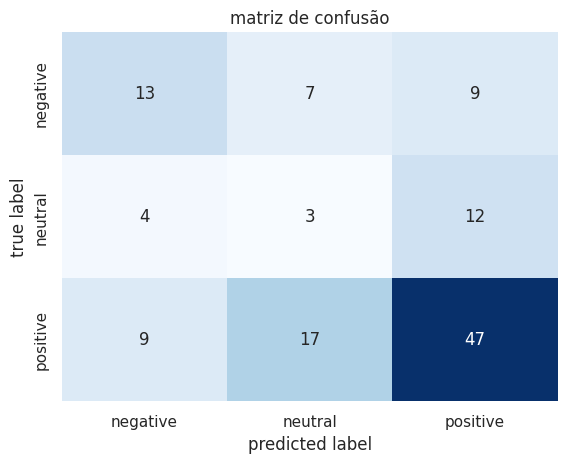

In [ ]:
plot_matrix(y_true=y_true, y_pred=y_pred)